In [1923]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import torch
from torch.nn.functional import conv2d, conv1d, relu_, sigmoid, hardtanh,  relu, unfold, fold
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

localConv=torch.nn.backends.thnn.backend.SpatialConvolutionLocal

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import seaborn as sns
import pickle as pkl
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

colors = ["r", "b", "y", "black", "orange"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1983]:
def calculateModuleScales(scales, numModules=4, clusters=None):
    model = KMeans(n_clusters=numModules)
    if clusters is None:
        clusters = model.fit_predict(scales.reshape(-1, 1))
    moduleScales = []
    numModules = int(np.max(clusters) - np.min(clusters)) + 1
    for i in range(numModules):
        values = clusters == i
        moduleScales.append(np.median(scales[values]))
    return(clusters, moduleScales)
    

In [1984]:
def calculatePathIntegrationSpeeds(vels, gcn, modules, simLength=20., dt=None):
    oldDt = gcn.dt
    if dt is not None:
        gcn.dt = dt
    numModules = int(np.max(modules) - np.min(modules)) + 1
    moduleSpeeds = np.zeros((len(vels), numModules))
    for i, vel in enumerate(vels):
        results, histResults, instResults = inhibGCN2.simulate(simLength,
                                           logFreq=int(0.01/gcn.dt),
                                           startFrom=simLength/2.,
                                           vel=vel,
                                           boosting=False)

        activityScales = compute_scales(results[:, :]/np.mean(results[:, :], axis=0,
                                                                 keepdims=True), filler=1000000)
        
        _, moduleScales = calculateModuleScales(activityScales, clusters=modules)
        
        moduleSpeeds[i] = moduleScales
        
    gcn.dt = oldDt
    moduleSpeeds[np.isnan(moduleSpeeds)] = 10000000
    return(moduleSpeeds)
        

In [1925]:
def compute_scales(W, filler=-1):
    num_gc = W.shape[1]
    scales = np.zeros(num_gc)
    for i in range(num_gc):
        f   = (W[:,i] > 1.).astype(float)
        df  = f[1:] - f[:-1]
        ind = np.where(df == -1.)[0]
        ind = ind.astype(float)

        if len(ind) > 1:
            scales[i] = np.median(ind[1:] - ind[:-1])

        else:
            scales[i] = filler

    return scales

In [3]:
def localConvolution(activity, weights, kernel):
    outputSize = (activity.shape[-2], activity.shape[-1])
    padding = tuple((k//2 for k in kernel))
    stride = (1, 1)
    unfoldedActivity = unfold(activity, kernel, 1, padding, stride)
    results = (weights*unfoldedActivity).sum(dim = 1)
    return (results.view(1, 1, outputSize[0], outputSize[1]))

In [1250]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.03
def w_0(x):
    """
    @param x (numpy array)
    A distance
    """
    a = 1.0
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    return a * np.exp(-gamma * x) - np.exp(-beta * x)

def w_1(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return -1*np.exp(-beta * x)


def mexican_hat(x, sigma=1.):
    a = 2./(np.sqrt(3*sigma)*np.power(np.pi, 0.25))
    b = (1. - (x/(.8*sigma))**2 )
    c = np.exp( - x**2/(2.*sigma**2))
    return a*b*c


# Random walk builder
def buildTrajectory(length, stepSize, width=1., directionStability=0.95, wrap=False):
    trajectory = np.zeros((int(length), 2))
    x = np.random.rand()
    y = np.random.rand()
    direction = np.random.rand() * 2 * np.pi
    twopi = 2*np.pi
    for i in range(int(length)):
        while True:
            # This is a random value between (-180, +180) scaled by directionStability
            dirChange = (((np.random.rand() * twopi) - np.pi) *
                       (1.0 - directionStability))
            direction = (direction + dirChange) % twopi
            rotation = np.asarray([np.cos(direction), np.sin(direction)])
            movement = stepSize*rotation
            if 0 < (movement[0] + x) < 1 and 0 < (movement[1] + y) < 1 or wrap:
                x += movement[0]
                y += movement[1]
                trajectory[i] = (x, y)
                break

    return(trajectory)

In [2049]:
class GCN1D(object):
    def __init__(self,
                 numX=500,
                 inhibitionWindow=15,
                 inhibitionRadius=.5,                 
                 inhibitionStrength=50,
                 excitationWindow=5,
                 excitationCenterBlock=-1,
                 smoothingWindow=1,
                 boostEffect=10,
                 boostDecay=3.,
                 dt=0.005,
                 numPlaces=200,
                 placeAlpha=20,
                 placeMean=0.5,
                 placeMax=1.,
                 activityMeanAlpha=.1,
                 globalTonic=20,
                 tonicGradientX=0.,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                 sigmaLoc=0.05,
                 learningRate=0.015,
                 negativeLearnFactorP=.9,
                 negativeLearnFactorE=.9,
                 negativeLearnFactorI=.9,
                 learnFactorP=.9,
                 learnFactorE=.0,
                 initialWeightFactor=.2,
                 inhibitoryWeightDecay=60,
                 placeWeightDecay=60,
                 excitatoryWeightDecay=60,
                 boostGradientX=1,
                 decayGradientX=1,
                 wideningFactor=0,
                 gradientType="linear",
                 envSize=1,
                 weightFunction=mexican_hat,
                 normalize=False,
                 weightNoise=None,
                ):
        
        self.activity = torch.zeros([1., 1., numX], device=device, dtype=torch.float)
        self.inhibitoryWeights=torch.randn(1, 2*inhibitionWindow+1, numX,
                        device=device, dtype=torch.float)
        
        self.directions = {"s": torch.tensor([1], device=device, dtype=torch.float),
                           "n": torch.tensor([-1], device=device, dtype=torch.float),
                          }
        
        self.excitatoryWeights = dict((k, torch.randn(1, (2*excitationWindow+1),
                                                      numX,
                        device=device, dtype=torch.float)*initialWeightFactor)
                                      for k in self.directions.keys())
        
        self.excitatoryKernel = ((2*excitationWindow+1), (2*excitationWindow+1))

        
        self.numX = numX
        self.numPlaces=numPlaces
        self.placeMean = placeMean
        self.placeMax = placeMax
        
                
        self.smoothingKernel = torch.ones([1, 1, 1+2*smoothingWindow], dtype=torch.float,
                         device=device)
        size = (1+2*smoothingWindow)
        self.smoothingKernel /= size
        self.smoothingWindow = (smoothingWindow, )
        
        
        self.originalWeights = torch.tensor(self.inhibitoryWeights.cpu().numpy(), device=device, dtype=torch.float)
        if weightNoise is not None:
            mask = torch.zeros((1, 2*inhibitionWindow+1, self.numX), device=device, dtype=torch.float)
            mask.uniform_(0, weightNoise)
            self.inhibitoryWeights = mask*self.inhibitoryWeights
            
        self.longHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.activationHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.squaredHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        
        if isinstance(gradientType, str) and "linear" in gradientType.lower():
            gradient = np.linspace(1, boostGradientX, numX)
            decayGradient = np.linspace(1., decayGradientX, numX)
            tonicGradient = np.linspace(1., tonicGradientX, numX)
        elif isinstance(gradientType, str) and "exponential" in gradientType.lower():
            base = np.power(boostGradientX, 1./numX)
            gradient = np.power(base, np.arange(0, numX))
            decayBase = np.power(decayGradientX, 1./numX)
            decayGradient = np.power(decayBase, np.arange(0, numX))
            tonicBase = np.power(tonicGradientX, 1./numX)
            tonicGradient = np.power(tonicBase, np.arange(0, numX))
        elif isinstance(gradientType, float):
            upper = np.power(boostGradientX, 1./gradientType)
            gradient = np.power(np.linspace(1., upper, numX), gradientType)
            decayUpper = np.power(decayGradientX, 1./gradientType)
            decayGradient = np.power(np.linspace(1., decayUpper, numX), gradientType)
            tonicUpper = np.power(tonicGradientX, 1./gradientType)
            tonicGradient = np.power(np.linspace(1., tonicUpper, numX), gradientType)
            
        self.boostEffect = torch.tensor(
            gradient * boostEffect, device=device, dtype=torch.float)
        self.alpha = torch.tensor(
            decayGradient * boostDecay, device=device, dtype=torch.float)
        self.globalTonic = torch.tensor(
            tonicGradient * globalTonic, device=device, dtype=torch.float)

        for i in range(1+2*inhibitionWindow):
                xDist = np.abs(i - (inhibitionWindow))
                dist = max(xDist - wideningFactor, 0)**2
                if dist <= 0:
                    weight = 0
                else:
                    weight = weightFunction(dist/inhibitionRadius)*inhibitionStrength
                self.inhibitoryWeights[:, i, :] = weight
                
        self.excitationMask = torch.zeros(1, (2*excitationWindow+1), 1,
                        device=device, dtype=torch.float)

        for i in range(1+2*excitationWindow):
            dist = np.abs(i - (excitationWindow))
            if dist > excitationCenterBlock:
                self.excitationMask[:, i, :] = 1.
  
        self.symmetrizer = torch.zeros((1+2*inhibitionWindow,
                                        1+2*inhibitionWindow),
                                       device=device,
                                       dtype=torch.float)

        
        self.symmetrizer[inhibitionWindow, inhibitionWindow] = 1.
        for i in range(1, inhibitionWindow+1):
            self.symmetrizer[inhibitionWindow+i, inhibitionWindow+i] = 1/2.
            self.symmetrizer[inhibitionWindow+i, inhibitionWindow-i] = 1/2.
            self.symmetrizer[inhibitionWindow-i, inhibitionWindow+i] = 1/2.
            self.symmetrizer[inhibitionWindow-i, inhibitionWindow-i] = 1/2.

        self.dt = dt
        self.decay = decayConstant
        self.activityMeanAlpha = activityMeanAlpha
        self.placeAlpha = placeAlpha
        self.inhibitionWindow = inhibitionWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        self.sigmaLoc = sigmaLoc
        self.learningRate = learningRate
        self.negativeLearnFactorP = negativeLearnFactorP
        self.negativeLearnFactorE = negativeLearnFactorE
        self.negativeLearnFactorI = negativeLearnFactorI
        self.learnFactorP = learnFactorP
        self.learnFactorE = learnFactorE
        self.inhibitoryWeightDecay = inhibitoryWeightDecay
        self.placeWeightDecay = placeWeightDecay
        self.excitatoryWeightDecay = excitatoryWeightDecay
        self.normalize = normalize
        
        self.inhibitoryKernel = ((2*inhibitionWindow+1), 1)
        self.excitatoryKernel = ((2*excitationWindow+1), 1)
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        self.places = torch.tensor(np.linspace(0, envSize, numPlaces), device=device, dtype=torch.float)
        self.envSize = envSize
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numPlaces),
                                         device=device, dtype=torch.float)
        
        torch.max(self.placeWeights, self.zero, out=self.placeWeights)
        torch.min(self.placeWeights, self.zero + self.placeMax, out=self.placeWeights)
        self.placeWeights *= self.placeMean/torch.mean(self.placeWeights, -1, keepdim=True)

        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        self.placeHistory = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow

    
    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """

        envelopeX = [1 if self.numX/2. - np.abs(p) > self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((-self.numX/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.arange(self.numX) - self.numX/2.]


        return np.asarray(envelopeX)
    
    def step(self,
             speed=1,
             vel=None,
             place=True,
             boosting=True,
             longHistory=True): 
        if place:
            self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX)
        else:
            self.instantaneous.fill_(0.)
            
        self.instantaneous += localConvolution(self.activity.view(1, 1, self.numX, 1),
                                                 self.inhibitoryWeights,
                                                 self.inhibitoryKernel).view(1, 1, self.numX)
        if vel is not None:
            for k, weights in self.excitatoryWeights.items():
                direction = self.directions[k]*vel
                if direction > self.zero:
                    self.instantaneous += direction*localConvolution(self.activity.view(1, 1, self.numX, 1),
                                                           weights,
                                                           self.excitatoryKernel).view(1, 1, self.numX)

        #self.instantaneous += conv1d(self.activity, self.filter, padding=self.inhibitionWindow)
        self.instantaneous += self.globalTonic
        self.instantaneous *= self.envelope
        if boosting:
            self.instantaneous -= self.activationHistory * self.boostEffect
        self.instantaneous *= speed
        self.instantaneous = hardtanh(self.instantaneous, 0, 1000)
        self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
        #torch.min(self.activity, self.zero + 1., out=self.activity)
        #self.activationHistory += ( - self.activity)*self.dt*self.envelope
        self.activationHistory = self.alpha*self.dt*((self.instantaneous)) +\
                                 (1. - self.alpha*self.dt)*self.activationHistory
        self.squaredHistory = self.activityMeanAlpha*self.dt*((self.instantaneous**2)) +\
                                 (1. - self.activityMeanAlpha*self.dt)*self.squaredHistory
        if longHistory:
            self.longHistory = self.activityMeanAlpha*self.dt*(self.instantaneous) +\
                                     (1. - self.activityMeanAlpha*self.dt)*self.longHistory
        
        if torch.sum(self.activity**2) > 0 and self.normalize:
            self.activity = self.activity/torch.sqrt(torch.sum(self.activity**2))
        
    def simulate(self,
                 time,
                 logFreq=10,
                 startFrom=0,
                 vel=0,
                 boosting=True,
                 placeActivity=True):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                 dtype=torch.float)
     
        if placeActivity:
            distances = torch.abs(self.places - 0.5)
            torch.exp(-1.*distances/(2*(self.sigmaLoc)), out=self.placeActivity)
            self.placeActivity.fill_(torch.mean(self.placeActivity))
        else:
            self.placeActivity.fill_(0.)
        
        self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX)*0.0, device=device,
                                                 dtype=torch.float)
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        instOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        
        s = 0
        for t in range(numSteps):
            self.step(place=placeActivity,
                      vel=vel,
                      boosting=boosting,
                      longHistory=False)
            if t % logFreq == 0 and t*self.dt >= startFrom:
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX))
                histOutput[s].copy_(self.activationHistory.view(self.numX))
                instOutput[s].copy_(self.instantaneous.view(self.numX))
                s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy(), instOutput.cpu().numpy()
    
    
    def staticLearning(self,
                       time,
                       logFreq=10,
                       startFrom=0,
                       startingActivity=None,
                       startingHistory=None,
                       symmetrize=True):
        
        if startingActivity is None:
            self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                     dtype=torch.float)
        else:
            self.activity = torch.tensor(startingActivity,
                                        device=device,
                                        dtype=torch.float).view((1, 1, self.numX))
        
        if startingHistory is None:  
            self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX)*0.0, device=device,
                                                 dtype=torch.float)
            
        else:
            self.activationHistory =torch.tensor(startingHistory,
                                                   device=device,
                                                   dtype=torch.float).view((1, 1, self.numX))
        
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)

        
        alphaboost = 1.
        s = 0
        for t in range(numSteps):
            self.step(place=False)
            
            if t*self.dt >= startFrom:
                self.covarianceInhibitoryUpdate()
                if symmetrize:
                    self.inhibitoryWeights = torch.matmul(self.symmetrizer, self.inhibitoryWeights)
                self.decayInhibitoryWeights(toPattern=False)
                
                if t % logFreq == 0:
                    print("At {}".format(t*self.dt))
                    output[s].copy_(self.activity.view(self.numX))
                    histOutput[s].copy_(self.activationHistory.view(self.numX))
                    s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy()
    
    
    def decayPlaceWeights(self):
        """
        Only decay place weights
        """
        self.placeWeights -= self.dt*(self.placeWeights**2)/self.placeWeightDecay
       
    def decayExcitatoryWeights(self):
        """
        Only decay excitatory weights
        """
        for k, weights in self.excitatoryWeights.items():
            weights -= self.dt*(torch.exp(torch.exp(weights*1.75)))/self.excitatoryWeightDecay


    def decayInhibitoryWeights(self, toPattern=True):
        """
        Only decay inhibitory weights
        """
        if toPattern:
            self.inhibitoryWeights -= self.dt*(self.inhibitoryWeights -
                                               self.originalWeights)/self.inhibitoryWeightDecay
        else:
            self.inhibitoryWeights -= self.dt*self.inhibitoryWeights/self.inhibitoryWeightDecay

    def learn(self,
              runs,
              plotting=True,
              plotInterval=100,
              speed=1,
              offsets=(0,0),
              randomSpeed=False,
              logFreq=None,
              wrap=False,
              learnInhibitory=False,
              symmetrize=True,
              learnExcitatory=False,
              learnPlace=True,
              useExcitatory=False,
              boosting=True,
              preSimulateTime=200.,
              simulateTonicBoost=1.,
              learnStart=0):
        
        if plotting:
                fig, (ax1, ax2, ax3) = plt.subplots(3,1)
                ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                plt.show()
                
        self.activityBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.inputBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.historyBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        self.velBuffer = torch.zeros([self.stdpWindow], device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)*self.learningRate*self.dt
        self.bufferIndex = 0
        
        
        startingPoint = 0
        trajectories = []
        timings = []
        time = 0
        residTime = 0
            
        for run in range(runs):
            if randomSpeed:
                speed = (np.random.random() + 0.5)*speed
            
            if run % 2 == 1:
                direction = -1
            else:
                direction = 1
                
            length = self.envSize / speed

            runTimes = np.arange(0, length, self.dt)
            trajectory = np.linspace(0, direction*self.envSize, len(runTimes))
            trajectories.append(trajectory)
            timings.append(runTimes)
            time += length
            
        
        self.longHistory.fill_(1.)
        if logFreq is not None:
            numSteps = int(time/self.dt)
            numLogs = int(numSteps/logFreq)
            index = 0
            output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
            histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
            instOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
            placeOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)

        
        for run, (trajectory, times) in enumerate(zip(trajectories, timings)):
            print("Starting run {}".format(run))
            self.bufferIndex = 0
            velocity = np.diff(trajectory)/self.dt
            trajectory = torch.tensor(trajectory, device=device, dtype=torch.float)
            velocity = torch.tensor(velocity, device=device, dtype=torch.float)
            speed = torch.abs(velocity)
            distances = torch.zeros((self.numPlaces, 2), device=device, dtype=torch.float)

            self.globalTonic *= simulateTonicBoost
            self.simulate(preSimulateTime, logFreq=100000, startFrom=10000, vel=torch.mean(velocity))
            self.globalTonic /= simulateTonicBoost
            
            for i, t in enumerate(times[:-1]):
                pos = trajectory[i] % self.envSize
                s = speed[i]/torch.mean(speed)
                vel = velocity[i]
                if wrap:
                    distances = torch.min(torch.abs(self.places - pos),
                                          torch.abs(self.envSize - self.places + pos))
                else:
                    distances = torch.abs(self.places - pos)
                    
                torch.exp(-1.*distances/(2*(self.sigmaLoc)), out=self.placeActivity)
                self.placeActivity *= s
                self.placeHistory = -self.placeAlpha*self.dt*self.placeActivity +\
                         (1. - self.placeAlpha*self.dt)*self.placeHistory
                if useExcitatory:
                    self.step(speed=s, vel=vel, boosting=boosting)
                else:
                    self.step(speed=s, boosting=boosting)
                if i*self.dt > learnStart:
                    if learnInhibitory:
                        self.covarianceInhibitoryUpdate()
                        if symmetrize:
                            self.inhibitoryWeights = torch.matmul(self.symmetrizer, self.inhibitoryWeights)
                        self.decayInhibitoryWeights(toPattern=True)
                    self.stdpUpdate(i,
                                    vel=vel,
                                    learnPlace=learnPlace,
                                    learnExcitatory=learnExcitatory)
                    if learnPlace:
                        self.decayPlaceWeights()
                        torch.max(self.placeWeights, self.zero, out=self.placeWeights)
                       
                    if learnExcitatory:
                        for k, weights in self.excitatoryWeights.items():
                            weights = torch.max(weights, self.zero)
                            weights = torch.min(weights, self.zero + 20)
                            self.excitatoryWeights[k] = self.excitationMask*weights
                        self.decayExcitatoryWeights()
           
                if logFreq is not None and i % logFreq == 0:
                    output[index].copy_(self.activity.view(self.numX))
                    histOutput[index].copy_(self.activationHistory.view(self.numX))
                    instOutput[index].copy_(self.instantaneous.view(self.numX))
                    input = torch.matmul(self.placeWeights, self.placeActivity).view(self.numX)
                    placeOutput[index].copy_(input)
                    index = index + 1
                
                if i % plotInterval == 0:
                    if plotting:
                        ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                        ax2.clear()
                        ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                        ax3.clear()
                        ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                        ax1.set_title(str(t))
                        fig.canvas.draw()

#             self.stdpUpdate(i+1,
#                             vel=vel,
#                             learnPlace=learnPlace,
#                             learnExcitatory=learnExcitatory,
#                             clearBuffer=True)
            
        return(output, histOutput, instOutput, placeOutput)

        
    def BCMPlaceUpdate(self, presyn, postsyn, history):
        """
        Return: update
        """
        postsyn = postsyn.view(postsyn.numel())
        presyn = presyn.view(presyn.numel())
        history = history.view(history.numel())
        delta = torch.ger(postsyn*(postsyn - history), presyn)/(history[:, None] + 0.001)
        
        return (delta * self.learningRate * self.learnFactorP * self.dt)    
    
        
    def covariancePlaceUpdate(self):
        update = (torch.ger(self.instantaneous - self.longHistory).view(self.numX),
                                                    self.placeActivity).view(self.numX, self.numPlaces)
        self.placeWeights += self.dt*self.learningRate*self.learnFactorP*update
    
    
    def BCMRecurrentUpdate(self, kernel, presyn, postsyn, history):
        padding = tuple((k//2 for k in kernel))
        stride = (1, 1)
        unfoldedActivity = unfold(postsyn*(postsyn - history).view(1, 1, self.numX, 1),
                                  kernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.longHistory)/(self.longHistory**2 + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt
        self.inhibitoryWeights += update
        self.inhibitoryWeights = torch.max(self.inhibitoryWeights, self.zero - 10.)
        self.inhibitoryWeights = torch.min(self.inhibitoryWeights, self.zero)
        return(update)

    
    def stdpUpdate(self,
                   time,
                   vel=0,
                   clearBuffer=False,
                   learnPlace=True,
                   learnExcitatory=False,
                   adaptive=False,
                   boosting=False):
        if time < self.activityBuffer.shape[0]:
            input = torch.matmul(self.placeWeights, self.placeActivity)
            input += self.globalTonic
            if boosting:
                input += (self.activationHistory * self.boostEffect)
            relu_(input)
            self.inputBuffer[self.bufferIndex].copy_(input.view(self.numX,))
            self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
            self.historyBuffer[self.bufferIndex].copy_(self.activationHistory.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.velBuffer[self.bufferIndex] = vel
            
            self.bufferIndex += 1
            
        else:
            for t in range(self.stdpWindow):
                i = (self.bufferIndex - t) % self.stdpWindow
                if learnPlace:
                    update = torch.ger(self.activity.view(self.numX),
                                        self.placeBuffer[i]* \
                                        self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                        self.learnFactorP
                    update -= torch.ger(self.activityBuffer[i],
                                         self.placeActivity *\
                                         self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                         self.negativeLearnFactorP *\
                                         self.learnFactorP

                    
                    self.placeWeights += update 
                
                    
        
                if learnExcitatory:
                    padding = tuple((k//2 for k in self.excitatoryKernel))
                    stride = (1, 1)
                    unfoldedActivity = unfold((self.instantaneous/self.longHistory + 0.001).view(1, 1, self.numX, 1),
                                              self.excitatoryKernel,
                                              1,
                                              padding,
                                              stride)

                    updateNeg = unfoldedActivity*\
                                self.stdpValues[t]*\
                                self.negativeLearnFactorE*\
                                (self.activityBuffer[i]/self.longHistory + 0.001).view(self.numX)*self.learnFactorE

                    unfoldedActivity = unfold((self.activityBuffer[i]/self.longHistory + 0.001).view(1, 1, self.numX, 1),
                                              self.excitatoryKernel,
                                              1,
                                              padding,
                                              stride)

                    updatePos = unfoldedActivity*\
                                 self.stdpValues[t]*\
                                 (self.instantaneous/self.longHistory + 0.001).view(self.numX)*self.learnFactorE    

                    for k, weights in self.excitatoryWeights.items():
                        dForward = torch.max(self.directions[k]*self.velBuffer[i], self.zero)
                        dBackward = torch.max(self.directions[k]*vel, self.zero)
                        weights += dForward*updatePos - dBackward*updateNeg


            self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
            input = torch.matmul(self.placeWeights, self.placeActivity)
            input += self.globalTonic
            if boosting:
                input -= self.activationHistory * self.boostEffect
            self.inputBuffer[self.bufferIndex].copy_(input.view(self.numX,))
            self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.velBuffer[self.bufferIndex] = vel

        if clearBuffer:
            for j in range(self.stdpWindow):
                for t in range(self.stdpWindow):
                    i = (j + self.bufferIndex - t) % self.stdpWindow
                    if learnPlace:
                        update = torch.ger(self.activityBuffer[j]/(self.longHistory + 0.001),
                                           self.placeBuffer[i]* \
                                                self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                                self.learnFactorP
                        update -= torch.ger(self.activityBuffer[i]/(self.longHistory + 0.001),
                                             self.placeBuffer[j] *\
                                                self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                              self.negativeLearnFactorP *\
                                                self.learnFactorP

                        self.placeWeights += update 

                self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
                self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
                self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
                self.historyBuffer[self.bufferIndex].copy_(self.activitionHistory.view(self.numX,))


    def covarianceInhibitoryUpdate(self):
        padding = tuple((k//2 for k in self.inhibitoryKernel))
        stride = (1, 1)
        unfoldedActivity = unfold(((self.instantaneous - 
                                   self.longHistory)/(self.longHistory + 0.001))\
                                  .view(1, 1, self.numX, 1),
                                  self.inhibitoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.longHistory)/(self.longHistory + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt
        positive = relu(update)
        negative = -relu(-update)
        self.inhibitoryWeights += positive * self.negativeLearnFactorI + negative
        self.inhibitoryWeights = torch.max(self.inhibitoryWeights, self.zero - 10.)
        self.inhibitoryWeights = torch.min(self.inhibitoryWeights, self.zero)
        return(update)
        
        
    def covarianceExcitatoryUpdate(self, vel):
        padding = tuple((k//2 for k in self.excitatoryKernel))
        stride = (1, 1)
        unfoldedActivity = unfold((self.instantaneous - self.activationHistory).view(1, 1, self.numX, 1),
                                  self.excitatoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.activationHistory)/(self.longHistory**2 + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt*self.learnFactorE
        for k, dir in self.directions.items():
            match = torch.max(self.directions[k]*vel, self.zero)
            positive = relu(update*match)
            negative = -relu(-update*match)
            self.excitatoryWeights[k] += self.negativeLearnFactorE*negative + positive
        return(update)
    
    
    def bcmExcitatoryUpdate(self, vel, boosting=False):
        padding = tuple((k//2 for k in self.excitatoryKernel))
        stride = (1, 1)
        input = (self.placeWeights @ self.placeActivity).view(self.numX)
        input += self.globalTonic
        if boosting:
            input -= (self.activationHistory * self.boostEffect).view(self.numX)
        relu_(input)        
        unfoldedActivity = unfold(input.view(1, 1, self.numX, 1),
                                  self.excitatoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*\
                 (self.instantaneous*(self.instantaneous + self.activationHistory))/\
                 (-self.activationHistory+ 0.001).view(self.numX)
        update = update*self.learningRate*self.dt*self.learnFactorE
        for k, dir in self.directions.items():
            match = torch.max(self.directions[k]*vel, self.zero)
            positive = relu(update*match)
            negative = -relu(-update*match)
            self.excitatoryWeights[k] += self.negativeLearnFactorE*negative + positive
        return(update)
    
    
    def adaptiveSTDPUpdate(self, vel, boosting=False):
        """
        Call STDPUpdate before this to set up the buffers properly.
        It can be called with all learning rules set to false if necessary.
        """
        for t in range(self.stdpWindow):
            i = (self.bufferIndex - t) % self.stdpWindow

            padding = tuple((k//2 for k in self.excitatoryKernel))
            stride = (1, 1)
            input = (self.placeWeights @ self.placeActivity).view(self.numX)
            input += self.globalTonic
            if boosting:
                input -= (self.activationHistory * self.boostEffect).view(self.numX)
            relu_(input)
            unfoldedActivity = unfold((input/(self.longHistory + 0.001)).\
                                      view(1, 1, self.numX, 1),
                                      self.excitatoryKernel,
                                      1,
                                      padding,
                                      stride)

            updateNeg = unfoldedActivity*\
                        self.stdpValues[t]*\
                        self.negativeLearnFactorE*\
                        (self.activityBuffer[i].view(self.numX) - self.historyBuffer[i])*self.learnFactorE

            unfoldedActivity = unfold((self.inputBuffer[i]/\
                                      (self.longHistory + 0.001)).view(1, 1, self.numX, 1),
                                      self.excitatoryKernel,
                                      1,
                                      padding,
                                      stride)

            updatePos = unfoldedActivity*\
                         self.stdpValues[t]*\
                         (self.instantaneous.view(self.numX) -\
                          self.activationHistory.view(self.numX))*self.learnFactorE    

            for k, weights in self.excitatoryWeights.items():
                dForward = torch.max(self.directions[k]*self.velBuffer[i], self.zero)
                dBackward = torch.max(self.directions[k]*vel, self.zero)
                weights += dForward*updatePos - dBackward*updateNeg
        



In [2194]:
with open(os.getcwd() + "\\perfectmodel.pkl", "rb") as f:
    inhibGCN2 = pkl.load(f)

<IPython.core.display.Javascript object>


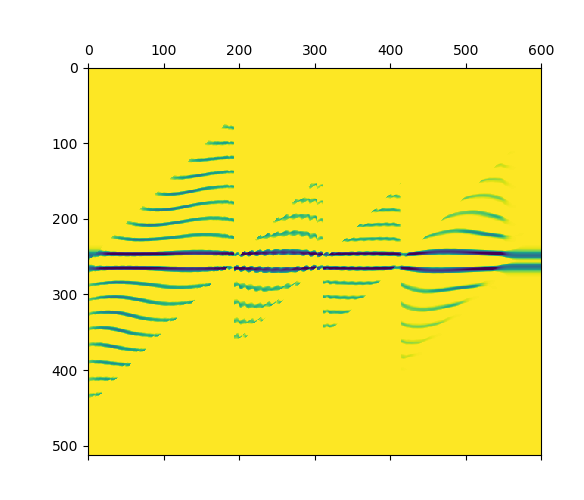

<IPython.core.display.Javascript object>


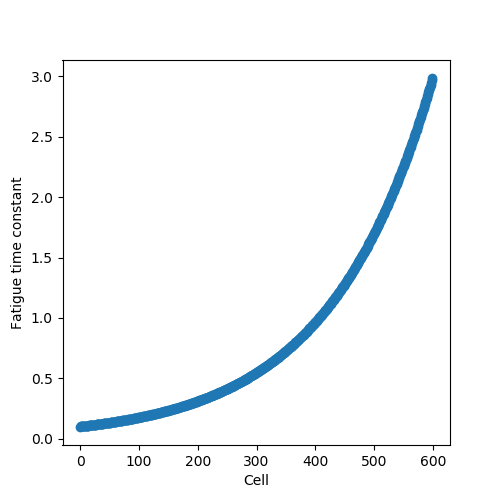

<IPython.core.display.Javascript object>


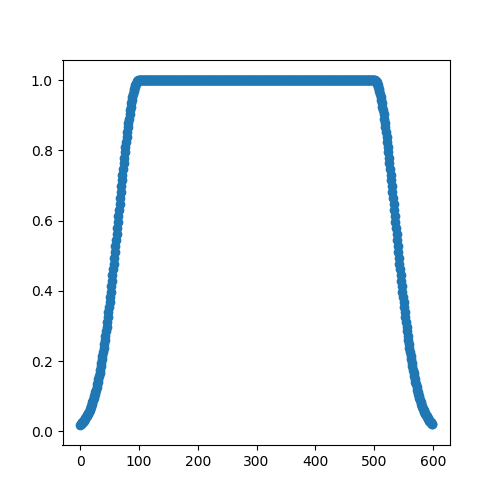

<IPython.core.display.Javascript object>


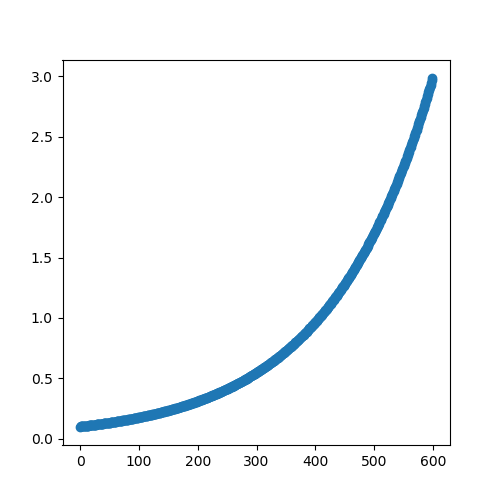

In [1712]:
plt.rcParams['figure.figsize'] = [5, 5]

# hatGCN = GCN1D(500,
#             10,
#             20.,
#             5.,
#             globalTonic=.025,
#             tonicGradientX=0,
#             stdpWindow=1,
#             dt=0.01,
#             boostEffect=.5,
#             boostDecay=1.,
#             placeAlpha=100.,
#             decayConstant=.5,
#             numPlaces=500,
#             learningRate=100.,
#             initialWeightFactor=.02,
#             boostGradientX=19.5,
#             decayGradientX=0.,
#             weightDecay=500,
#             wideningFactor=2,
#             negativeLearnFactorE=.9,
#             envelopeWidth=10,
#             envelopeFactor=2,
#             sigmaLoc=.0005,
#             gradientType="exponential",
#             envSize=5.,
#             weightFunction=mexican_hat,
#             normalize=True,
#             weightNoise=2.)


inhibGCN3 = GCN1D(600,
            256,
            1.,
            500.,
            excitationWindow=256,
            excitationCenterBlock=-1,
            globalTonic=20.,
            tonicGradientX=1.,
            stdpWindow=10,
            dt=0.01,
            boostEffect=10.,
            boostDecay=.1,
            activityMeanAlpha=.1,
            placeAlpha=0.01,
            decayConstant=.03,
            numPlaces=500,
            placeMax=.5,
            placeMean=.25,
            learningRate=.01,
            initialWeightFactor=.02,
            boostGradientX=1.,
            decayGradientX=30.,
            inhibitoryWeightDecay=3000,
            placeWeightDecay=100,
            excitatoryWeightDecay=100000,
            wideningFactor=0.,
            negativeLearnFactorP=.0,
            negativeLearnFactorE=1.5,
            negativeLearnFactorI=5,
            learnFactorP=1000.,
            learnFactorE=10.,
            envelopeWidth=100,
            envelopeFactor=4.,
            sigmaLoc=.01,
            gradientType="exponential",
            envSize=5.,
            weightFunction=w_0,
            normalize=False,
            weightNoise=2.)


#GCN.randomLesions(10, 10, 5)
plt.matshow(inhibGCN2.inhibitoryWeights[0,:])
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.boostEffect.shape[0]), (inhibGCN2.alpha))
plt.xlabel("Cell")
plt.ylabel("Fatigue time constant")
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.envelope.shape[0]), inhibGCN2.envelope)
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.alpha.shape[0]), inhibGCN2.alpha)
plt.show()


<IPython.core.display.Javascript object>


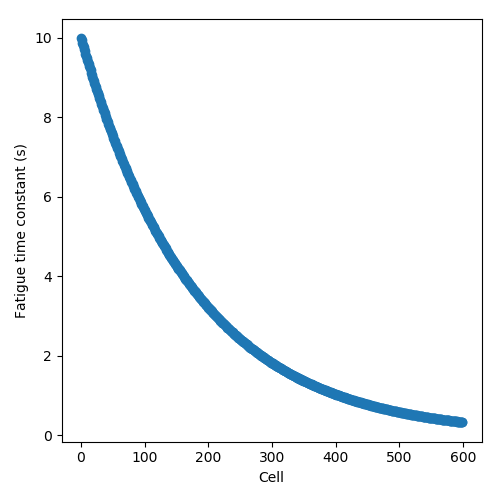

In [2184]:
plt.figure()
plt.scatter(np.arange(inhibGCN2.boostEffect.shape[0]), -0.01/(np.log(1 - inhibGCN2.alpha*0.01)))
plt.xlabel("Cell")
plt.ylabel("Fatigue time constant (s)")
plt.tight_layout()
plt.show()

In [2233]:
plt.rcParams['figure.figsize'] = [5, 5]
results, histResults, instResults = inhibGCN3.simulate(1000,
                                                      logFreq=int(0.01/inhibGCN2.dt),
                                                      startFrom = 0.,
                                                      boosting=True)

At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35000000000000003
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41000000000000003
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47000000000000003
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.5700000000000001
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.6900000000000001
At 0.7000000000000001
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.8200000000000001
At 0.8300000000000001
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.9400000000000001
At 0.9500000000000001
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 

At 8.78
At 8.790000000000001
At 8.8
At 8.81
At 8.82
At 8.83
At 8.84
At 8.85
At 8.86
At 8.870000000000001
At 8.88
At 8.89
At 8.9
At 8.91
At 8.92
At 8.93
At 8.94
At 8.950000000000001
At 8.96
At 8.97
At 8.98
At 8.99
At 9.0
At 9.01
At 9.02
At 9.03
At 9.040000000000001
At 9.05
At 9.06
At 9.07
At 9.08
At 9.09
At 9.1
At 9.11
At 9.120000000000001
At 9.13
At 9.14
At 9.15
At 9.16
At 9.17
At 9.18
At 9.19
At 9.200000000000001
At 9.21
At 9.22
At 9.23
At 9.24
At 9.25
At 9.26
At 9.27
At 9.28
At 9.290000000000001
At 9.3
At 9.31
At 9.32
At 9.33
At 9.34
At 9.35
At 9.36
At 9.370000000000001
At 9.38
At 9.39
At 9.4
At 9.41
At 9.42
At 9.43
At 9.44
At 9.450000000000001
At 9.46
At 9.47
At 9.48
At 9.49
At 9.5
At 9.51
At 9.52
At 9.53
At 9.540000000000001
At 9.55
At 9.56
At 9.57
At 9.58
At 9.59
At 9.6
At 9.61
At 9.620000000000001
At 9.63
At 9.64
At 9.65
At 9.66
At 9.67
At 9.68
At 9.69
At 9.700000000000001
At 9.71
At 9.72
At 9.73
At 9.74
At 9.75
At 9.76
At 9.77
At 9.78
At 9.790000000000001
At 9.8
At 9.81
At 9.82


At 17.42
At 17.43
At 17.44
At 17.45
At 17.46
At 17.47
At 17.48
At 17.490000000000002
At 17.5
At 17.51
At 17.52
At 17.53
At 17.54
At 17.55
At 17.56
At 17.57
At 17.580000000000002
At 17.59
At 17.6
At 17.61
At 17.62
At 17.63
At 17.64
At 17.650000000000002
At 17.66
At 17.67
At 17.68
At 17.69
At 17.7
At 17.71
At 17.72
At 17.73
At 17.740000000000002
At 17.75
At 17.76
At 17.77
At 17.78
At 17.79
At 17.8
At 17.81
At 17.82
At 17.830000000000002
At 17.84
At 17.85
At 17.86
At 17.87
At 17.88
At 17.89
At 17.900000000000002
At 17.91
At 17.92
At 17.93
At 17.94
At 17.95
At 17.96
At 17.97
At 17.98
At 17.990000000000002
At 18.0
At 18.01
At 18.02
At 18.03
At 18.04
At 18.05
At 18.06
At 18.07
At 18.080000000000002
At 18.09
At 18.1
At 18.11
At 18.12
At 18.13
At 18.14
At 18.150000000000002
At 18.16
At 18.17
At 18.18
At 18.19
At 18.2
At 18.21
At 18.22
At 18.23
At 18.240000000000002
At 18.25
At 18.26
At 18.27
At 18.28
At 18.29
At 18.3
At 18.31
At 18.32
At 18.330000000000002
At 18.34
At 18.35
At 18.36
At 18.37
A

At 25.47
At 25.48
At 25.490000000000002
At 25.5
At 25.51
At 25.52
At 25.53
At 25.54
At 25.55
At 25.560000000000002
At 25.57
At 25.580000000000002
At 25.59
At 25.6
At 25.61
At 25.62
At 25.63
At 25.64
At 25.650000000000002
At 25.66
At 25.67
At 25.68
At 25.69
At 25.7
At 25.71
At 25.72
At 25.73
At 25.740000000000002
At 25.75
At 25.76
At 25.77
At 25.78
At 25.79
At 25.8
At 25.810000000000002
At 25.82
At 25.830000000000002
At 25.84
At 25.85
At 25.86
At 25.87
At 25.88
At 25.89
At 25.900000000000002
At 25.91
At 25.92
At 25.93
At 25.94
At 25.95
At 25.96
At 25.97
At 25.98
At 25.990000000000002
At 26.0
At 26.01
At 26.02
At 26.03
At 26.04
At 26.05
At 26.060000000000002
At 26.07
At 26.080000000000002
At 26.09
At 26.1
At 26.11
At 26.12
At 26.13
At 26.14
At 26.150000000000002
At 26.16
At 26.17
At 26.18
At 26.19
At 26.2
At 26.21
At 26.22
At 26.23
At 26.240000000000002
At 26.25
At 26.26
At 26.27
At 26.28
At 26.29
At 26.3
At 26.310000000000002
At 26.32
At 26.330000000000002
At 26.34
At 26.35
At 26.36
At 

At 33.480000000000004
At 33.49
At 33.5
At 33.51
At 33.52
At 33.53
At 33.54
At 33.55
At 33.56
At 33.57
At 33.58
At 33.59
At 33.6
At 33.61
At 33.62
At 33.63
At 33.64
At 33.65
At 33.660000000000004
At 33.67
At 33.68
At 33.69
At 33.7
At 33.71
At 33.72
At 33.730000000000004
At 33.74
At 33.75
At 33.76
At 33.77
At 33.78
At 33.79
At 33.8
At 33.81
At 33.82
At 33.83
At 33.84
At 33.85
At 33.86
At 33.87
At 33.88
At 33.89
At 33.9
At 33.910000000000004
At 33.92
At 33.93
At 33.94
At 33.95
At 33.96
At 33.97
At 33.980000000000004
At 33.99
At 34.0
At 34.01
At 34.02
At 34.03
At 34.04
At 34.05
At 34.06
At 34.07
At 34.08
At 34.09
At 34.1
At 34.11
At 34.12
At 34.13
At 34.14
At 34.15
At 34.160000000000004
At 34.17
At 34.18
At 34.19
At 34.2
At 34.21
At 34.22
At 34.230000000000004
At 34.24
At 34.25
At 34.26
At 34.27
At 34.28
At 34.29
At 34.300000000000004
At 34.31
At 34.32
At 34.33
At 34.34
At 34.35
At 34.36
At 34.37
At 34.38
At 34.39
At 34.4
At 34.410000000000004
At 34.42
At 34.43
At 34.44
At 34.45
At 34.46
A

At 41.76
At 41.77
At 41.78
At 41.79
At 41.800000000000004
At 41.81
At 41.82
At 41.83
At 41.84
At 41.85
At 41.86
At 41.87
At 41.88
At 41.89
At 41.9
At 41.910000000000004
At 41.92
At 41.93
At 41.94
At 41.95
At 41.96
At 41.97
At 41.980000000000004
At 41.99
At 42.0
At 42.01
At 42.02
At 42.03
At 42.04
At 42.050000000000004
At 42.06
At 42.07
At 42.08
At 42.09
At 42.1
At 42.11
At 42.12
At 42.13
At 42.14
At 42.15
At 42.160000000000004
At 42.17
At 42.18
At 42.19
At 42.2
At 42.21
At 42.22
At 42.230000000000004
At 42.24
At 42.25
At 42.26
At 42.27
At 42.28
At 42.29
At 42.300000000000004
At 42.31
At 42.32
At 42.33
At 42.34
At 42.35
At 42.36
At 42.37
At 42.38
At 42.39
At 42.4
At 42.410000000000004
At 42.42
At 42.43
At 42.44
At 42.45
At 42.46
At 42.47
At 42.480000000000004
At 42.49
At 42.5
At 42.51
At 42.52
At 42.53
At 42.54
At 42.550000000000004
At 42.56
At 42.57
At 42.58
At 42.59
At 42.6
At 42.61
At 42.62
At 42.63
At 42.64
At 42.65
At 42.660000000000004
At 42.67
At 42.68
At 42.69
At 42.7
At 42.71
A

At 49.6
At 49.61
At 49.620000000000005
At 49.63
At 49.64
At 49.65
At 49.660000000000004
At 49.67
At 49.68
At 49.69
At 49.7
At 49.71
At 49.72
At 49.730000000000004
At 49.74
At 49.75
At 49.76
At 49.77
At 49.78
At 49.79
At 49.800000000000004
At 49.81
At 49.82
At 49.83
At 49.84
At 49.85
At 49.86
At 49.870000000000005
At 49.88
At 49.89
At 49.9
At 49.910000000000004
At 49.92
At 49.93
At 49.94
At 49.95
At 49.96
At 49.97
At 49.980000000000004
At 49.99
At 50.0
At 50.01
At 50.02
At 50.03
At 50.04
At 50.050000000000004
At 50.06
At 50.07
At 50.08
At 50.09
At 50.1
At 50.11
At 50.120000000000005
At 50.13
At 50.14
At 50.15
At 50.160000000000004
At 50.17
At 50.18
At 50.19
At 50.2
At 50.21
At 50.22
At 50.230000000000004
At 50.24
At 50.25
At 50.26
At 50.27
At 50.28
At 50.29
At 50.300000000000004
At 50.31
At 50.32
At 50.33
At 50.34
At 50.35
At 50.36
At 50.370000000000005
At 50.38
At 50.39
At 50.4
At 50.410000000000004
At 50.42
At 50.43
At 50.44
At 50.45
At 50.46
At 50.47
At 50.480000000000004
At 50.49
At

At 57.410000000000004
At 57.42
At 57.43
At 57.44
At 57.45
At 57.46
At 57.47
At 57.480000000000004
At 57.49
At 57.5
At 57.51
At 57.52
At 57.53
At 57.54
At 57.550000000000004
At 57.56
At 57.57
At 57.58
At 57.59
At 57.6
At 57.61
At 57.620000000000005
At 57.63
At 57.64
At 57.65
At 57.660000000000004
At 57.67
At 57.68
At 57.69
At 57.7
At 57.71
At 57.72
At 57.730000000000004
At 57.74
At 57.75
At 57.76
At 57.77
At 57.78
At 57.79
At 57.800000000000004
At 57.81
At 57.82
At 57.83
At 57.84
At 57.85
At 57.86
At 57.870000000000005
At 57.88
At 57.89
At 57.9
At 57.910000000000004
At 57.92
At 57.93
At 57.94
At 57.95
At 57.96
At 57.97
At 57.980000000000004
At 57.99
At 58.0
At 58.01
At 58.02
At 58.03
At 58.04
At 58.050000000000004
At 58.06
At 58.07
At 58.08
At 58.09
At 58.1
At 58.11
At 58.120000000000005
At 58.13
At 58.14
At 58.15
At 58.160000000000004
At 58.17
At 58.18
At 58.19
At 58.2
At 58.21
At 58.22
At 58.230000000000004
At 58.24
At 58.25
At 58.26
At 58.27
At 58.28
At 58.29
At 58.300000000000004
At

At 65.09
At 65.1
At 65.11
At 65.12
At 65.13
At 65.14
At 65.15
At 65.16
At 65.17
At 65.18
At 65.19
At 65.2
At 65.21000000000001
At 65.22
At 65.23
At 65.24
At 65.25
At 65.26
At 65.27
At 65.28
At 65.29
At 65.3
At 65.31
At 65.32000000000001
At 65.33
At 65.34
At 65.35
At 65.36
At 65.37
At 65.38
At 65.39
At 65.4
At 65.41
At 65.42
At 65.43
At 65.44
At 65.45
At 65.46000000000001
At 65.47
At 65.48
At 65.49
At 65.5
At 65.51
At 65.52
At 65.53
At 65.54
At 65.55
At 65.56
At 65.57000000000001
At 65.58
At 65.59
At 65.6
At 65.61
At 65.62
At 65.63
At 65.64
At 65.65
At 65.66
At 65.67
At 65.68
At 65.69
At 65.7
At 65.71000000000001
At 65.72
At 65.73
At 65.74
At 65.75
At 65.76
At 65.77
At 65.78
At 65.79
At 65.8
At 65.81
At 65.82000000000001
At 65.83
At 65.84
At 65.85
At 65.86
At 65.87
At 65.88
At 65.89
At 65.9
At 65.91
At 65.92
At 65.93
At 65.94
At 65.95
At 65.96000000000001
At 65.97
At 65.98
At 65.99
At 66.0
At 66.01
At 66.02
At 66.03
At 66.04
At 66.05
At 66.06
At 66.07000000000001
At 66.08
At 66.09
At 66

At 73.56
At 73.57000000000001
At 73.58
At 73.59
At 73.60000000000001
At 73.61
At 73.62
At 73.63
At 73.64
At 73.65
At 73.66
At 73.67
At 73.68
At 73.69
At 73.7
At 73.71000000000001
At 73.72
At 73.73
At 73.74
At 73.75
At 73.76
At 73.77
At 73.78
At 73.79
At 73.8
At 73.81
At 73.82000000000001
At 73.83
At 73.84
At 73.85000000000001
At 73.86
At 73.87
At 73.88
At 73.89
At 73.9
At 73.91
At 73.92
At 73.93
At 73.94
At 73.95
At 73.96000000000001
At 73.97
At 73.98
At 73.99
At 74.0
At 74.01
At 74.02
At 74.03
At 74.04
At 74.05
At 74.06
At 74.07000000000001
At 74.08
At 74.09
At 74.10000000000001
At 74.11
At 74.12
At 74.13
At 74.14
At 74.15
At 74.16
At 74.17
At 74.18
At 74.19
At 74.2
At 74.21000000000001
At 74.22
At 74.23
At 74.24
At 74.25
At 74.26
At 74.27
At 74.28
At 74.29
At 74.3
At 74.31
At 74.32000000000001
At 74.33
At 74.34
At 74.35000000000001
At 74.36
At 74.37
At 74.38
At 74.39
At 74.4
At 74.41
At 74.42
At 74.43
At 74.44
At 74.45
At 74.46000000000001
At 74.47
At 74.48
At 74.49
At 74.5
At 74.51


At 82.03
At 82.04
At 82.05
At 82.06
At 82.07000000000001
At 82.08
At 82.09
At 82.10000000000001
At 82.11
At 82.12
At 82.13
At 82.14
At 82.15
At 82.16
At 82.17
At 82.18
At 82.19
At 82.2
At 82.21000000000001
At 82.22
At 82.23
At 82.24
At 82.25
At 82.26
At 82.27
At 82.28
At 82.29
At 82.3
At 82.31
At 82.32000000000001
At 82.33
At 82.34
At 82.35000000000001
At 82.36
At 82.37
At 82.38
At 82.39
At 82.4
At 82.41
At 82.42
At 82.43
At 82.44
At 82.45
At 82.46000000000001
At 82.47
At 82.48
At 82.49
At 82.5
At 82.51
At 82.52
At 82.53
At 82.54
At 82.55
At 82.56
At 82.57000000000001
At 82.58
At 82.59
At 82.60000000000001
At 82.61
At 82.62
At 82.63
At 82.64
At 82.65
At 82.66
At 82.67
At 82.68
At 82.69
At 82.7
At 82.71000000000001
At 82.72
At 82.73
At 82.74
At 82.75
At 82.76
At 82.77
At 82.78
At 82.79
At 82.8
At 82.81
At 82.82000000000001
At 82.83
At 82.84
At 82.85000000000001
At 82.86
At 82.87
At 82.88
At 82.89
At 82.9
At 82.91
At 82.92
At 82.93
At 82.94
At 82.95
At 82.96000000000001
At 82.97
At 82.98

At 90.54
At 90.55
At 90.56
At 90.57000000000001
At 90.58
At 90.59
At 90.60000000000001
At 90.61
At 90.62
At 90.63
At 90.64
At 90.65
At 90.66
At 90.67
At 90.68
At 90.69
At 90.7
At 90.71000000000001
At 90.72
At 90.73
At 90.74
At 90.75
At 90.76
At 90.77
At 90.78
At 90.79
At 90.8
At 90.81
At 90.82000000000001
At 90.83
At 90.84
At 90.85000000000001
At 90.86
At 90.87
At 90.88
At 90.89
At 90.9
At 90.91
At 90.92
At 90.93
At 90.94
At 90.95
At 90.96000000000001
At 90.97
At 90.98
At 90.99
At 91.0
At 91.01
At 91.02
At 91.03
At 91.04
At 91.05
At 91.06
At 91.07000000000001
At 91.08
At 91.09
At 91.10000000000001
At 91.11
At 91.12
At 91.13
At 91.14
At 91.15
At 91.16
At 91.17
At 91.18
At 91.19
At 91.2
At 91.21000000000001
At 91.22
At 91.23
At 91.24
At 91.25
At 91.26
At 91.27
At 91.28
At 91.29
At 91.3
At 91.31
At 91.32000000000001
At 91.33
At 91.34
At 91.35000000000001
At 91.36
At 91.37
At 91.38
At 91.39
At 91.4
At 91.41
At 91.42
At 91.43
At 91.44
At 91.45
At 91.46000000000001
At 91.47
At 91.48
At 91.49

At 98.47
At 98.48
At 98.49000000000001
At 98.5
At 98.51
At 98.52
At 98.53
At 98.54
At 98.55
At 98.56
At 98.57000000000001
At 98.58
At 98.59
At 98.60000000000001
At 98.61
At 98.62
At 98.63
At 98.64
At 98.65
At 98.66
At 98.67
At 98.68
At 98.69
At 98.7
At 98.71000000000001
At 98.72
At 98.73
At 98.74000000000001
At 98.75
At 98.76
At 98.77
At 98.78
At 98.79
At 98.8
At 98.81
At 98.82000000000001
At 98.83
At 98.84
At 98.85000000000001
At 98.86
At 98.87
At 98.88
At 98.89
At 98.9
At 98.91
At 98.92
At 98.93
At 98.94
At 98.95
At 98.96000000000001
At 98.97
At 98.98
At 98.99000000000001
At 99.0
At 99.01
At 99.02
At 99.03
At 99.04
At 99.05
At 99.06
At 99.07000000000001
At 99.08
At 99.09
At 99.10000000000001
At 99.11
At 99.12
At 99.13
At 99.14
At 99.15
At 99.16
At 99.17
At 99.18
At 99.19
At 99.2
At 99.21000000000001
At 99.22
At 99.23
At 99.24000000000001
At 99.25
At 99.26
At 99.27
At 99.28
At 99.29
At 99.3
At 99.31
At 99.32000000000001
At 99.33
At 99.34
At 99.35000000000001
At 99.36
At 99.37
At 99.38

At 105.74000000000001
At 105.75
At 105.76
At 105.77
At 105.78
At 105.79
At 105.8
At 105.81
At 105.82000000000001
At 105.83
At 105.84
At 105.85000000000001
At 105.86
At 105.87
At 105.88
At 105.89
At 105.9
At 105.91
At 105.92
At 105.93
At 105.94
At 105.95
At 105.96000000000001
At 105.97
At 105.98
At 105.99000000000001
At 106.0
At 106.01
At 106.02
At 106.03
At 106.04
At 106.05
At 106.06
At 106.07000000000001
At 106.08
At 106.09
At 106.10000000000001
At 106.11
At 106.12
At 106.13
At 106.14
At 106.15
At 106.16
At 106.17
At 106.18
At 106.19
At 106.2
At 106.21000000000001
At 106.22
At 106.23
At 106.24000000000001
At 106.25
At 106.26
At 106.27
At 106.28
At 106.29
At 106.3
At 106.31
At 106.32000000000001
At 106.33
At 106.34
At 106.35000000000001
At 106.36
At 106.37
At 106.38
At 106.39
At 106.4
At 106.41
At 106.42
At 106.43
At 106.44
At 106.45
At 106.46000000000001
At 106.47
At 106.48
At 106.49000000000001
At 106.5
At 106.51
At 106.52
At 106.53
At 106.54
At 106.55
At 106.56
At 106.57000000000001

At 113.13
At 113.14
At 113.15
At 113.16
At 113.17
At 113.18
At 113.19
At 113.2
At 113.21000000000001
At 113.22
At 113.23
At 113.24000000000001
At 113.25
At 113.26
At 113.27
At 113.28
At 113.29
At 113.3
At 113.31
At 113.32000000000001
At 113.33
At 113.34
At 113.35000000000001
At 113.36
At 113.37
At 113.38
At 113.39
At 113.4
At 113.41
At 113.42
At 113.43
At 113.44
At 113.45
At 113.46000000000001
At 113.47
At 113.48
At 113.49000000000001
At 113.5
At 113.51
At 113.52
At 113.53
At 113.54
At 113.55
At 113.56
At 113.57000000000001
At 113.58
At 113.59
At 113.60000000000001
At 113.61
At 113.62
At 113.63
At 113.64
At 113.65
At 113.66
At 113.67
At 113.68
At 113.69
At 113.7
At 113.71000000000001
At 113.72
At 113.73
At 113.74000000000001
At 113.75
At 113.76
At 113.77
At 113.78
At 113.79
At 113.8
At 113.81
At 113.82000000000001
At 113.83
At 113.84
At 113.85000000000001
At 113.86
At 113.87
At 113.88
At 113.89
At 113.9
At 113.91
At 113.92
At 113.93
At 113.94
At 113.95
At 113.96000000000001
At 113.97
A

At 120.22
At 120.23
At 120.24000000000001
At 120.25
At 120.26
At 120.27
At 120.28
At 120.29
At 120.3
At 120.31
At 120.32000000000001
At 120.33
At 120.34
At 120.35000000000001
At 120.36
At 120.37
At 120.38
At 120.39
At 120.4
At 120.41
At 120.42
At 120.43
At 120.44
At 120.45
At 120.46000000000001
At 120.47
At 120.48
At 120.49000000000001
At 120.5
At 120.51
At 120.52
At 120.53
At 120.54
At 120.55
At 120.56
At 120.57000000000001
At 120.58
At 120.59
At 120.60000000000001
At 120.61
At 120.62
At 120.63
At 120.64
At 120.65
At 120.66
At 120.67
At 120.68
At 120.69
At 120.7
At 120.71000000000001
At 120.72
At 120.73
At 120.74000000000001
At 120.75
At 120.76
At 120.77
At 120.78
At 120.79
At 120.8
At 120.81
At 120.82000000000001
At 120.83
At 120.84
At 120.85000000000001
At 120.86
At 120.87
At 120.88
At 120.89
At 120.9
At 120.91
At 120.92
At 120.93
At 120.94
At 120.95
At 120.96000000000001
At 120.97
At 120.98
At 120.99000000000001
At 121.0
At 121.01
At 121.02
At 121.03
At 121.04
At 121.05
At 121.06
A

At 126.99000000000001
At 127.0
At 127.01
At 127.02
At 127.03
At 127.04
At 127.05
At 127.06
At 127.07000000000001
At 127.08
At 127.09
At 127.10000000000001
At 127.11
At 127.12
At 127.13000000000001
At 127.14
At 127.15
At 127.16
At 127.17
At 127.18
At 127.19
At 127.2
At 127.21000000000001
At 127.22
At 127.23
At 127.24000000000001
At 127.25
At 127.26
At 127.27
At 127.28
At 127.29
At 127.3
At 127.31
At 127.32000000000001
At 127.33
At 127.34
At 127.35000000000001
At 127.36
At 127.37
At 127.38000000000001
At 127.39
At 127.4
At 127.41
At 127.42
At 127.43
At 127.44
At 127.45
At 127.46000000000001
At 127.47
At 127.48
At 127.49000000000001
At 127.5
At 127.51
At 127.52
At 127.53
At 127.54
At 127.55
At 127.56
At 127.57000000000001
At 127.58
At 127.59
At 127.60000000000001
At 127.61
At 127.62
At 127.63000000000001
At 127.64
At 127.65
At 127.66
At 127.67
At 127.68
At 127.69
At 127.7
At 127.71000000000001
At 127.72
At 127.73
At 127.74000000000001
At 127.75
At 127.76
At 127.77
At 127.78
At 127.79
At 1

At 134.73
At 134.74
At 134.75
At 134.76
At 134.77
At 134.78
At 134.79
At 134.8
At 134.81
At 134.82
At 134.83
At 134.84
At 134.85
At 134.86
At 134.87
At 134.88
At 134.89000000000001
At 134.9
At 134.91
At 134.92000000000002
At 134.93
At 134.94
At 134.95
At 134.96
At 134.97
At 134.98
At 134.99
At 135.0
At 135.01
At 135.02
At 135.03
At 135.04
At 135.05
At 135.06
At 135.07
At 135.08
At 135.09
At 135.1
At 135.11
At 135.12
At 135.13
At 135.14000000000001
At 135.15
At 135.16
At 135.17000000000002
At 135.18
At 135.19
At 135.2
At 135.21
At 135.22
At 135.23
At 135.24
At 135.25
At 135.26
At 135.27
At 135.28
At 135.29
At 135.3
At 135.31
At 135.32
At 135.33
At 135.34
At 135.35
At 135.36
At 135.37
At 135.38
At 135.39000000000001
At 135.4
At 135.41
At 135.42000000000002
At 135.43
At 135.44
At 135.45
At 135.46
At 135.47
At 135.48
At 135.49
At 135.5
At 135.51
At 135.52
At 135.53
At 135.54
At 135.55
At 135.56
At 135.57
At 135.58
At 135.59
At 135.6
At 135.61
At 135.62
At 135.63
At 135.64000000000001
At 13

At 142.4
At 142.41
At 142.42000000000002
At 142.43
At 142.44
At 142.45000000000002
At 142.46
At 142.47
At 142.48
At 142.49
At 142.5
At 142.51
At 142.52
At 142.53
At 142.54
At 142.55
At 142.56
At 142.57
At 142.58
At 142.59
At 142.6
At 142.61
At 142.62
At 142.63
At 142.64000000000001
At 142.65
At 142.66
At 142.67000000000002
At 142.68
At 142.69
At 142.70000000000002
At 142.71
At 142.72
At 142.73
At 142.74
At 142.75
At 142.76
At 142.77
At 142.78
At 142.79
At 142.8
At 142.81
At 142.82
At 142.83
At 142.84
At 142.85
At 142.86
At 142.87
At 142.88
At 142.89000000000001
At 142.9
At 142.91
At 142.92000000000002
At 142.93
At 142.94
At 142.95000000000002
At 142.96
At 142.97
At 142.98
At 142.99
At 143.0
At 143.01
At 143.02
At 143.03
At 143.04
At 143.05
At 143.06
At 143.07
At 143.08
At 143.09
At 143.1
At 143.11
At 143.12
At 143.13
At 143.14000000000001
At 143.15
At 143.16
At 143.17000000000002
At 143.18
At 143.19
At 143.20000000000002
At 143.21
At 143.22
At 143.23
At 143.24
At 143.25
At 143.26
At 14

At 150.24
At 150.25
At 150.26
At 150.27
At 150.28
At 150.29
At 150.3
At 150.31
At 150.32
At 150.33
At 150.34
At 150.35
At 150.36
At 150.37
At 150.38
At 150.39000000000001
At 150.4
At 150.41
At 150.42000000000002
At 150.43
At 150.44
At 150.45000000000002
At 150.46
At 150.47
At 150.48
At 150.49
At 150.5
At 150.51
At 150.52
At 150.53
At 150.54
At 150.55
At 150.56
At 150.57
At 150.58
At 150.59
At 150.6
At 150.61
At 150.62
At 150.63
At 150.64000000000001
At 150.65
At 150.66
At 150.67000000000002
At 150.68
At 150.69
At 150.70000000000002
At 150.71
At 150.72
At 150.73
At 150.74
At 150.75
At 150.76
At 150.77
At 150.78
At 150.79
At 150.8
At 150.81
At 150.82
At 150.83
At 150.84
At 150.85
At 150.86
At 150.87
At 150.88
At 150.89000000000001
At 150.9
At 150.91
At 150.92000000000002
At 150.93
At 150.94
At 150.95000000000002
At 150.96
At 150.97
At 150.98
At 150.99
At 151.0
At 151.01
At 151.02
At 151.03
At 151.04
At 151.05
At 151.06
At 151.07
At 151.08
At 151.09
At 151.1
At 151.11
At 151.12
At 151.13


At 157.62
At 157.63
At 157.64000000000001
At 157.65
At 157.66
At 157.67000000000002
At 157.68
At 157.69
At 157.70000000000002
At 157.71
At 157.72
At 157.73
At 157.74
At 157.75
At 157.76
At 157.77
At 157.78
At 157.79
At 157.8
At 157.81
At 157.82
At 157.83
At 157.84
At 157.85
At 157.86
At 157.87
At 157.88
At 157.89000000000001
At 157.9
At 157.91
At 157.92000000000002
At 157.93
At 157.94
At 157.95000000000002
At 157.96
At 157.97
At 157.98
At 157.99
At 158.0
At 158.01
At 158.02
At 158.03
At 158.04
At 158.05
At 158.06
At 158.07
At 158.08
At 158.09
At 158.1
At 158.11
At 158.12
At 158.13
At 158.14000000000001
At 158.15
At 158.16
At 158.17000000000002
At 158.18
At 158.19
At 158.20000000000002
At 158.21
At 158.22
At 158.23
At 158.24
At 158.25
At 158.26
At 158.27
At 158.28
At 158.29
At 158.3
At 158.31
At 158.32
At 158.33
At 158.34
At 158.35
At 158.36
At 158.37
At 158.38
At 158.39000000000001
At 158.4
At 158.41
At 158.42000000000002
At 158.43
At 158.44
At 158.45000000000002
At 158.46
At 158.47
At

At 165.24
At 165.25
At 165.26
At 165.27
At 165.28
At 165.29
At 165.3
At 165.31
At 165.32
At 165.33
At 165.34
At 165.35
At 165.36
At 165.37
At 165.38
At 165.39000000000001
At 165.4
At 165.41
At 165.42000000000002
At 165.43
At 165.44
At 165.45000000000002
At 165.46
At 165.47
At 165.48
At 165.49
At 165.5
At 165.51
At 165.52
At 165.53
At 165.54
At 165.55
At 165.56
At 165.57
At 165.58
At 165.59
At 165.6
At 165.61
At 165.62
At 165.63
At 165.64000000000001
At 165.65
At 165.66
At 165.67000000000002
At 165.68
At 165.69
At 165.70000000000002
At 165.71
At 165.72
At 165.73
At 165.74
At 165.75
At 165.76
At 165.77
At 165.78
At 165.79
At 165.8
At 165.81
At 165.82
At 165.83
At 165.84
At 165.85
At 165.86
At 165.87
At 165.88
At 165.89000000000001
At 165.9
At 165.91
At 165.92000000000002
At 165.93
At 165.94
At 165.95000000000002
At 165.96
At 165.97
At 165.98
At 165.99
At 166.0
At 166.01
At 166.02
At 166.03
At 166.04
At 166.05
At 166.06
At 166.07
At 166.08
At 166.09
At 166.1
At 166.11
At 166.12
At 166.13


At 173.02
At 173.03
At 173.04
At 173.05
At 173.06
At 173.07
At 173.08
At 173.09
At 173.1
At 173.11
At 173.12
At 173.13
At 173.14000000000001
At 173.15
At 173.16
At 173.17000000000002
At 173.18
At 173.19
At 173.20000000000002
At 173.21
At 173.22
At 173.23
At 173.24
At 173.25
At 173.26
At 173.27
At 173.28
At 173.29
At 173.3
At 173.31
At 173.32
At 173.33
At 173.34
At 173.35
At 173.36
At 173.37
At 173.38
At 173.39000000000001
At 173.4
At 173.41
At 173.42000000000002
At 173.43
At 173.44
At 173.45000000000002
At 173.46
At 173.47
At 173.48
At 173.49
At 173.5
At 173.51
At 173.52
At 173.53
At 173.54
At 173.55
At 173.56
At 173.57
At 173.58
At 173.59
At 173.6
At 173.61
At 173.62
At 173.63
At 173.64000000000001
At 173.65
At 173.66
At 173.67000000000002
At 173.68
At 173.69
At 173.70000000000002
At 173.71
At 173.72
At 173.73
At 173.74
At 173.75
At 173.76
At 173.77
At 173.78
At 173.79
At 173.8
At 173.81
At 173.82
At 173.83
At 173.84
At 173.85
At 173.86
At 173.87
At 173.88
At 173.89000000000001
At 173

At 180.36
At 180.37
At 180.38
At 180.39000000000001
At 180.4
At 180.41
At 180.42000000000002
At 180.43
At 180.44
At 180.45000000000002
At 180.46
At 180.47
At 180.48
At 180.49
At 180.5
At 180.51
At 180.52
At 180.53
At 180.54
At 180.55
At 180.56
At 180.57
At 180.58
At 180.59
At 180.6
At 180.61
At 180.62
At 180.63
At 180.64000000000001
At 180.65
At 180.66
At 180.67000000000002
At 180.68
At 180.69
At 180.70000000000002
At 180.71
At 180.72
At 180.73
At 180.74
At 180.75
At 180.76
At 180.77
At 180.78
At 180.79
At 180.8
At 180.81
At 180.82
At 180.83
At 180.84
At 180.85
At 180.86
At 180.87
At 180.88
At 180.89000000000001
At 180.9
At 180.91
At 180.92000000000002
At 180.93
At 180.94
At 180.95000000000002
At 180.96
At 180.97
At 180.98
At 180.99
At 181.0
At 181.01
At 181.02
At 181.03
At 181.04
At 181.05
At 181.06
At 181.07
At 181.08
At 181.09
At 181.1
At 181.11
At 181.12
At 181.13
At 181.14000000000001
At 181.15
At 181.16
At 181.17000000000002
At 181.18
At 181.19
At 181.20000000000002
At 181.21
At 

At 187.69
At 187.70000000000002
At 187.71
At 187.72
At 187.73
At 187.74
At 187.75
At 187.76
At 187.77
At 187.78
At 187.79
At 187.8
At 187.81
At 187.82
At 187.83
At 187.84
At 187.85
At 187.86
At 187.87
At 187.88
At 187.89000000000001
At 187.9
At 187.91
At 187.92000000000002
At 187.93
At 187.94
At 187.95000000000002
At 187.96
At 187.97
At 187.98
At 187.99
At 188.0
At 188.01
At 188.02
At 188.03
At 188.04
At 188.05
At 188.06
At 188.07
At 188.08
At 188.09
At 188.1
At 188.11
At 188.12
At 188.13
At 188.14000000000001
At 188.15
At 188.16
At 188.17000000000002
At 188.18
At 188.19
At 188.20000000000002
At 188.21
At 188.22
At 188.23
At 188.24
At 188.25
At 188.26
At 188.27
At 188.28
At 188.29
At 188.3
At 188.31
At 188.32
At 188.33
At 188.34
At 188.35
At 188.36
At 188.37
At 188.38
At 188.39000000000001
At 188.4
At 188.41
At 188.42000000000002
At 188.43
At 188.44
At 188.45000000000002
At 188.46
At 188.47
At 188.48
At 188.49
At 188.5
At 188.51
At 188.52
At 188.53
At 188.54
At 188.55
At 188.56
At 188.

At 195.21
At 195.22
At 195.23000000000002
At 195.24
At 195.25
At 195.26
At 195.27
At 195.28
At 195.29
At 195.3
At 195.31
At 195.32
At 195.33
At 195.34
At 195.35
At 195.36
At 195.37
At 195.38
At 195.39000000000001
At 195.4
At 195.41
At 195.42000000000002
At 195.43
At 195.44
At 195.45000000000002
At 195.46
At 195.47
At 195.48000000000002
At 195.49
At 195.5
At 195.51
At 195.52
At 195.53
At 195.54
At 195.55
At 195.56
At 195.57
At 195.58
At 195.59
At 195.6
At 195.61
At 195.62
At 195.63
At 195.64000000000001
At 195.65
At 195.66
At 195.67000000000002
At 195.68
At 195.69
At 195.70000000000002
At 195.71
At 195.72
At 195.73000000000002
At 195.74
At 195.75
At 195.76
At 195.77
At 195.78
At 195.79
At 195.8
At 195.81
At 195.82
At 195.83
At 195.84
At 195.85
At 195.86
At 195.87
At 195.88
At 195.89000000000001
At 195.9
At 195.91
At 195.92000000000002
At 195.93
At 195.94
At 195.95000000000002
At 195.96
At 195.97
At 195.98000000000002
At 195.99
At 196.0
At 196.01
At 196.02
At 196.03
At 196.04
At 196.05
A

At 202.83
At 202.84
At 202.85
At 202.86
At 202.87
At 202.88
At 202.89000000000001
At 202.9
At 202.91
At 202.92000000000002
At 202.93
At 202.94
At 202.95000000000002
At 202.96
At 202.97
At 202.98000000000002
At 202.99
At 203.0
At 203.01
At 203.02
At 203.03
At 203.04
At 203.05
At 203.06
At 203.07
At 203.08
At 203.09
At 203.1
At 203.11
At 203.12
At 203.13
At 203.14000000000001
At 203.15
At 203.16
At 203.17000000000002
At 203.18
At 203.19
At 203.20000000000002
At 203.21
At 203.22
At 203.23000000000002
At 203.24
At 203.25
At 203.26
At 203.27
At 203.28
At 203.29
At 203.3
At 203.31
At 203.32
At 203.33
At 203.34
At 203.35
At 203.36
At 203.37
At 203.38
At 203.39000000000001
At 203.4
At 203.41
At 203.42000000000002
At 203.43
At 203.44
At 203.45000000000002
At 203.46
At 203.47
At 203.48000000000002
At 203.49
At 203.5
At 203.51
At 203.52
At 203.53
At 203.54
At 203.55
At 203.56
At 203.57
At 203.58
At 203.59
At 203.6
At 203.61
At 203.62
At 203.63
At 203.64000000000001
At 203.65
At 203.66
At 203.6700

At 210.07
At 210.08
At 210.09
At 210.1
At 210.11
At 210.12
At 210.13
At 210.14000000000001
At 210.15
At 210.16
At 210.17000000000002
At 210.18
At 210.19
At 210.20000000000002
At 210.21
At 210.22
At 210.23000000000002
At 210.24
At 210.25
At 210.26
At 210.27
At 210.28
At 210.29
At 210.3
At 210.31
At 210.32
At 210.33
At 210.34
At 210.35
At 210.36
At 210.37
At 210.38
At 210.39000000000001
At 210.4
At 210.41
At 210.42000000000002
At 210.43
At 210.44
At 210.45000000000002
At 210.46
At 210.47
At 210.48000000000002
At 210.49
At 210.5
At 210.51
At 210.52
At 210.53
At 210.54
At 210.55
At 210.56
At 210.57
At 210.58
At 210.59
At 210.6
At 210.61
At 210.62
At 210.63
At 210.64000000000001
At 210.65
At 210.66
At 210.67000000000002
At 210.68
At 210.69
At 210.70000000000002
At 210.71
At 210.72
At 210.73000000000002
At 210.74
At 210.75
At 210.76
At 210.77
At 210.78
At 210.79
At 210.8
At 210.81
At 210.82
At 210.83
At 210.84
At 210.85
At 210.86
At 210.87
At 210.88
At 210.89000000000001
At 210.9
At 210.91
A

At 217.35
At 217.36
At 217.37
At 217.38
At 217.39000000000001
At 217.4
At 217.41
At 217.42000000000002
At 217.43
At 217.44
At 217.45000000000002
At 217.46
At 217.47
At 217.48000000000002
At 217.49
At 217.5
At 217.51
At 217.52
At 217.53
At 217.54
At 217.55
At 217.56
At 217.57
At 217.58
At 217.59
At 217.6
At 217.61
At 217.62
At 217.63
At 217.64000000000001
At 217.65
At 217.66
At 217.67000000000002
At 217.68
At 217.69
At 217.70000000000002
At 217.71
At 217.72
At 217.73000000000002
At 217.74
At 217.75
At 217.76
At 217.77
At 217.78
At 217.79
At 217.8
At 217.81
At 217.82
At 217.83
At 217.84
At 217.85
At 217.86
At 217.87
At 217.88
At 217.89000000000001
At 217.9
At 217.91
At 217.92000000000002
At 217.93
At 217.94
At 217.95000000000002
At 217.96
At 217.97
At 217.98000000000002
At 217.99
At 218.0
At 218.01
At 218.02
At 218.03
At 218.04
At 218.05
At 218.06
At 218.07
At 218.08
At 218.09
At 218.1
At 218.11
At 218.12
At 218.13
At 218.14000000000001
At 218.15
At 218.16
At 218.17000000000002
At 218.18

At 224.89000000000001
At 224.9
At 224.91
At 224.92000000000002
At 224.93
At 224.94
At 224.95000000000002
At 224.96
At 224.97
At 224.98000000000002
At 224.99
At 225.0
At 225.01
At 225.02
At 225.03
At 225.04
At 225.05
At 225.06
At 225.07
At 225.08
At 225.09
At 225.1
At 225.11
At 225.12
At 225.13
At 225.14000000000001
At 225.15
At 225.16
At 225.17000000000002
At 225.18
At 225.19
At 225.20000000000002
At 225.21
At 225.22
At 225.23000000000002
At 225.24
At 225.25
At 225.26
At 225.27
At 225.28
At 225.29
At 225.3
At 225.31
At 225.32
At 225.33
At 225.34
At 225.35
At 225.36
At 225.37
At 225.38
At 225.39000000000001
At 225.4
At 225.41
At 225.42000000000002
At 225.43
At 225.44
At 225.45000000000002
At 225.46
At 225.47
At 225.48000000000002
At 225.49
At 225.5
At 225.51
At 225.52
At 225.53
At 225.54
At 225.55
At 225.56
At 225.57
At 225.58
At 225.59
At 225.6
At 225.61
At 225.62
At 225.63
At 225.64000000000001
At 225.65
At 225.66
At 225.67000000000002
At 225.68
At 225.69
At 225.70000000000002
At 225.

At 232.54
At 232.55
At 232.56
At 232.57
At 232.58
At 232.59
At 232.6
At 232.61
At 232.62
At 232.63
At 232.64000000000001
At 232.65
At 232.66
At 232.67000000000002
At 232.68
At 232.69
At 232.70000000000002
At 232.71
At 232.72
At 232.73000000000002
At 232.74
At 232.75
At 232.76
At 232.77
At 232.78
At 232.79
At 232.8
At 232.81
At 232.82
At 232.83
At 232.84
At 232.85
At 232.86
At 232.87
At 232.88
At 232.89000000000001
At 232.9
At 232.91
At 232.92000000000002
At 232.93
At 232.94
At 232.95000000000002
At 232.96
At 232.97
At 232.98000000000002
At 232.99
At 233.0
At 233.01
At 233.02
At 233.03
At 233.04
At 233.05
At 233.06
At 233.07
At 233.08
At 233.09
At 233.1
At 233.11
At 233.12
At 233.13
At 233.14000000000001
At 233.15
At 233.16
At 233.17000000000002
At 233.18
At 233.19
At 233.20000000000002
At 233.21
At 233.22
At 233.23000000000002
At 233.24
At 233.25
At 233.26
At 233.27
At 233.28
At 233.29
At 233.3
At 233.31
At 233.32
At 233.33
At 233.34
At 233.35
At 233.36
At 233.37
At 233.38
At 233.39000

At 240.01
At 240.02
At 240.03
At 240.04
At 240.05
At 240.06
At 240.07
At 240.08
At 240.09
At 240.1
At 240.11
At 240.12
At 240.13
At 240.14000000000001
At 240.15
At 240.16
At 240.17000000000002
At 240.18
At 240.19
At 240.20000000000002
At 240.21
At 240.22
At 240.23000000000002
At 240.24
At 240.25
At 240.26
At 240.27
At 240.28
At 240.29
At 240.3
At 240.31
At 240.32
At 240.33
At 240.34
At 240.35
At 240.36
At 240.37
At 240.38
At 240.39000000000001
At 240.4
At 240.41
At 240.42000000000002
At 240.43
At 240.44
At 240.45000000000002
At 240.46
At 240.47
At 240.48000000000002
At 240.49
At 240.5
At 240.51
At 240.52
At 240.53
At 240.54
At 240.55
At 240.56
At 240.57
At 240.58
At 240.59
At 240.6
At 240.61
At 240.62
At 240.63
At 240.64000000000001
At 240.65
At 240.66
At 240.67000000000002
At 240.68
At 240.69
At 240.70000000000002
At 240.71
At 240.72
At 240.73000000000002
At 240.74
At 240.75
At 240.76
At 240.77
At 240.78
At 240.79
At 240.8
At 240.81
At 240.82
At 240.83
At 240.84
At 240.85
At 240.86
At

At 247.39000000000001
At 247.4
At 247.41
At 247.42000000000002
At 247.43
At 247.44
At 247.45000000000002
At 247.46
At 247.47
At 247.48000000000002
At 247.49
At 247.5
At 247.51000000000002
At 247.52
At 247.53
At 247.54
At 247.55
At 247.56
At 247.57
At 247.58
At 247.59
At 247.6
At 247.61
At 247.62
At 247.63
At 247.64000000000001
At 247.65
At 247.66
At 247.67000000000002
At 247.68
At 247.69
At 247.70000000000002
At 247.71
At 247.72
At 247.73000000000002
At 247.74
At 247.75
At 247.76000000000002
At 247.77
At 247.78
At 247.79
At 247.8
At 247.81
At 247.82
At 247.83
At 247.84
At 247.85
At 247.86
At 247.87
At 247.88
At 247.89000000000001
At 247.9
At 247.91
At 247.92000000000002
At 247.93
At 247.94
At 247.95000000000002
At 247.96
At 247.97
At 247.98000000000002
At 247.99
At 248.0
At 248.01000000000002
At 248.02
At 248.03
At 248.04
At 248.05
At 248.06
At 248.07
At 248.08
At 248.09
At 248.1
At 248.11
At 248.12
At 248.13
At 248.14000000000001
At 248.15
At 248.16
At 248.17000000000002
At 248.18
At 

At 254.56
At 254.57
At 254.58
At 254.59
At 254.6
At 254.61
At 254.62
At 254.63
At 254.64000000000001
At 254.65
At 254.66
At 254.67000000000002
At 254.68
At 254.69
At 254.70000000000002
At 254.71
At 254.72
At 254.73000000000002
At 254.74
At 254.75
At 254.76000000000002
At 254.77
At 254.78
At 254.79
At 254.8
At 254.81
At 254.82
At 254.83
At 254.84
At 254.85
At 254.86
At 254.87
At 254.88
At 254.89000000000001
At 254.9
At 254.91
At 254.92000000000002
At 254.93
At 254.94
At 254.95000000000002
At 254.96
At 254.97
At 254.98000000000002
At 254.99
At 255.0
At 255.01000000000002
At 255.02
At 255.03
At 255.04
At 255.05
At 255.06
At 255.07
At 255.08
At 255.09
At 255.1
At 255.11
At 255.12
At 255.13
At 255.14000000000001
At 255.15
At 255.16
At 255.17000000000002
At 255.18
At 255.19
At 255.20000000000002
At 255.21
At 255.22
At 255.23000000000002
At 255.24
At 255.25
At 255.26000000000002
At 255.27
At 255.28
At 255.29
At 255.3
At 255.31
At 255.32
At 255.33
At 255.34
At 255.35
At 255.36
At 255.37
At 255

At 262.57
At 262.58
At 262.59000000000003
At 262.6
At 262.61
At 262.62
At 262.63
At 262.64
At 262.65
At 262.66
At 262.67
At 262.68
At 262.69
At 262.7
At 262.71
At 262.72
At 262.73
At 262.74
At 262.75
At 262.76
At 262.77
At 262.78000000000003
At 262.79
At 262.8
At 262.81
At 262.82
At 262.83
At 262.84000000000003
At 262.85
At 262.86
At 262.87
At 262.88
At 262.89
At 262.9
At 262.91
At 262.92
At 262.93
At 262.94
At 262.95
At 262.96
At 262.97
At 262.98
At 262.99
At 263.0
At 263.01
At 263.02
At 263.03000000000003
At 263.04
At 263.05
At 263.06
At 263.07
At 263.08
At 263.09000000000003
At 263.1
At 263.11
At 263.12
At 263.13
At 263.14
At 263.15
At 263.16
At 263.17
At 263.18
At 263.19
At 263.2
At 263.21
At 263.22
At 263.23
At 263.24
At 263.25
At 263.26
At 263.27
At 263.28000000000003
At 263.29
At 263.3
At 263.31
At 263.32
At 263.33
At 263.34000000000003
At 263.35
At 263.36
At 263.37
At 263.38
At 263.39
At 263.4
At 263.41
At 263.42
At 263.43
At 263.44
At 263.45
At 263.46
At 263.47
At 263.48
At 26

At 270.62
At 270.63
At 270.64
At 270.65
At 270.66
At 270.67
At 270.68
At 270.69
At 270.7
At 270.71
At 270.72
At 270.73
At 270.74
At 270.75
At 270.76
At 270.77
At 270.78000000000003
At 270.79
At 270.8
At 270.81
At 270.82
At 270.83
At 270.84000000000003
At 270.85
At 270.86
At 270.87
At 270.88
At 270.89
At 270.9
At 270.91
At 270.92
At 270.93
At 270.94
At 270.95
At 270.96
At 270.97
At 270.98
At 270.99
At 271.0
At 271.01
At 271.02
At 271.03000000000003
At 271.04
At 271.05
At 271.06
At 271.07
At 271.08
At 271.09000000000003
At 271.1
At 271.11
At 271.12
At 271.13
At 271.14
At 271.15
At 271.16
At 271.17
At 271.18
At 271.19
At 271.2
At 271.21
At 271.22
At 271.23
At 271.24
At 271.25
At 271.26
At 271.27
At 271.28000000000003
At 271.29
At 271.3
At 271.31
At 271.32
At 271.33
At 271.34000000000003
At 271.35
At 271.36
At 271.37
At 271.38
At 271.39
At 271.4
At 271.41
At 271.42
At 271.43
At 271.44
At 271.45
At 271.46
At 271.47
At 271.48
At 271.49
At 271.5
At 271.51
At 271.52
At 271.53000000000003
At 27

At 278.46
At 278.47
At 278.48
At 278.49
At 278.5
At 278.51
At 278.52
At 278.53000000000003
At 278.54
At 278.55
At 278.56
At 278.57
At 278.58
At 278.59000000000003
At 278.6
At 278.61
At 278.62
At 278.63
At 278.64
At 278.65000000000003
At 278.66
At 278.67
At 278.68
At 278.69
At 278.7
At 278.71
At 278.72
At 278.73
At 278.74
At 278.75
At 278.76
At 278.77
At 278.78000000000003
At 278.79
At 278.8
At 278.81
At 278.82
At 278.83
At 278.84000000000003
At 278.85
At 278.86
At 278.87
At 278.88
At 278.89
At 278.90000000000003
At 278.91
At 278.92
At 278.93
At 278.94
At 278.95
At 278.96
At 278.97
At 278.98
At 278.99
At 279.0
At 279.01
At 279.02
At 279.03000000000003
At 279.04
At 279.05
At 279.06
At 279.07
At 279.08
At 279.09000000000003
At 279.1
At 279.11
At 279.12
At 279.13
At 279.14
At 279.15000000000003
At 279.16
At 279.17
At 279.18
At 279.19
At 279.2
At 279.21
At 279.22
At 279.23
At 279.24
At 279.25
At 279.26
At 279.27
At 279.28000000000003
At 279.29
At 279.3
At 279.31
At 279.32
At 279.33
At 279.3

At 286.25
At 286.26
At 286.27
At 286.28000000000003
At 286.29
At 286.3
At 286.31
At 286.32
At 286.33
At 286.34000000000003
At 286.35
At 286.36
At 286.37
At 286.38
At 286.39
At 286.40000000000003
At 286.41
At 286.42
At 286.43
At 286.44
At 286.45
At 286.46
At 286.47
At 286.48
At 286.49
At 286.5
At 286.51
At 286.52
At 286.53000000000003
At 286.54
At 286.55
At 286.56
At 286.57
At 286.58
At 286.59000000000003
At 286.6
At 286.61
At 286.62
At 286.63
At 286.64
At 286.65000000000003
At 286.66
At 286.67
At 286.68
At 286.69
At 286.7
At 286.71
At 286.72
At 286.73
At 286.74
At 286.75
At 286.76
At 286.77
At 286.78000000000003
At 286.79
At 286.8
At 286.81
At 286.82
At 286.83
At 286.84000000000003
At 286.85
At 286.86
At 286.87
At 286.88
At 286.89
At 286.90000000000003
At 286.91
At 286.92
At 286.93
At 286.94
At 286.95
At 286.96
At 286.97
At 286.98
At 286.99
At 287.0
At 287.01
At 287.02
At 287.03000000000003
At 287.04
At 287.05
At 287.06
At 287.07
At 287.08
At 287.09000000000003
At 287.1
At 287.11
At 28

At 293.89
At 293.90000000000003
At 293.91
At 293.92
At 293.93
At 293.94
At 293.95
At 293.96
At 293.97
At 293.98
At 293.99
At 294.0
At 294.01
At 294.02
At 294.03000000000003
At 294.04
At 294.05
At 294.06
At 294.07
At 294.08
At 294.09000000000003
At 294.1
At 294.11
At 294.12
At 294.13
At 294.14
At 294.15000000000003
At 294.16
At 294.17
At 294.18
At 294.19
At 294.2
At 294.21
At 294.22
At 294.23
At 294.24
At 294.25
At 294.26
At 294.27
At 294.28000000000003
At 294.29
At 294.3
At 294.31
At 294.32
At 294.33
At 294.34000000000003
At 294.35
At 294.36
At 294.37
At 294.38
At 294.39
At 294.40000000000003
At 294.41
At 294.42
At 294.43
At 294.44
At 294.45
At 294.46
At 294.47
At 294.48
At 294.49
At 294.5
At 294.51
At 294.52
At 294.53000000000003
At 294.54
At 294.55
At 294.56
At 294.57
At 294.58
At 294.59000000000003
At 294.6
At 294.61
At 294.62
At 294.63
At 294.64
At 294.65000000000003
At 294.66
At 294.67
At 294.68
At 294.69
At 294.7
At 294.71
At 294.72
At 294.73
At 294.74
At 294.75
At 294.76
At 294.

At 301.5
At 301.51
At 301.52
At 301.53000000000003
At 301.54
At 301.55
At 301.56
At 301.57
At 301.58
At 301.59000000000003
At 301.6
At 301.61
At 301.62
At 301.63
At 301.64
At 301.65000000000003
At 301.66
At 301.67
At 301.68
At 301.69
At 301.7
At 301.71
At 301.72
At 301.73
At 301.74
At 301.75
At 301.76
At 301.77
At 301.78000000000003
At 301.79
At 301.8
At 301.81
At 301.82
At 301.83
At 301.84000000000003
At 301.85
At 301.86
At 301.87
At 301.88
At 301.89
At 301.90000000000003
At 301.91
At 301.92
At 301.93
At 301.94
At 301.95
At 301.96
At 301.97
At 301.98
At 301.99
At 302.0
At 302.01
At 302.02
At 302.03000000000003
At 302.04
At 302.05
At 302.06
At 302.07
At 302.08
At 302.09000000000003
At 302.1
At 302.11
At 302.12
At 302.13
At 302.14
At 302.15000000000003
At 302.16
At 302.17
At 302.18
At 302.19
At 302.2
At 302.21
At 302.22
At 302.23
At 302.24
At 302.25
At 302.26
At 302.27
At 302.28000000000003
At 302.29
At 302.3
At 302.31
At 302.32
At 302.33
At 302.34000000000003
At 302.35
At 302.36
At 302

At 309.22
At 309.23
At 309.24
At 309.25
At 309.26
At 309.27
At 309.28000000000003
At 309.29
At 309.3
At 309.31
At 309.32
At 309.33
At 309.34000000000003
At 309.35
At 309.36
At 309.37
At 309.38
At 309.39
At 309.40000000000003
At 309.41
At 309.42
At 309.43
At 309.44
At 309.45
At 309.46
At 309.47
At 309.48
At 309.49
At 309.5
At 309.51
At 309.52
At 309.53000000000003
At 309.54
At 309.55
At 309.56
At 309.57
At 309.58
At 309.59000000000003
At 309.6
At 309.61
At 309.62
At 309.63
At 309.64
At 309.65000000000003
At 309.66
At 309.67
At 309.68
At 309.69
At 309.7
At 309.71
At 309.72
At 309.73
At 309.74
At 309.75
At 309.76
At 309.77
At 309.78000000000003
At 309.79
At 309.8
At 309.81
At 309.82
At 309.83
At 309.84000000000003
At 309.85
At 309.86
At 309.87
At 309.88
At 309.89
At 309.90000000000003
At 309.91
At 309.92
At 309.93
At 309.94
At 309.95
At 309.96
At 309.97
At 309.98
At 309.99
At 310.0
At 310.01
At 310.02
At 310.03000000000003
At 310.04
At 310.05
At 310.06
At 310.07
At 310.08
At 310.090000000

At 316.96
At 316.97
At 316.98
At 316.99
At 317.0
At 317.01
At 317.02
At 317.03000000000003
At 317.04
At 317.05
At 317.06
At 317.07
At 317.08
At 317.09000000000003
At 317.1
At 317.11
At 317.12
At 317.13
At 317.14
At 317.15000000000003
At 317.16
At 317.17
At 317.18
At 317.19
At 317.2
At 317.21
At 317.22
At 317.23
At 317.24
At 317.25
At 317.26
At 317.27
At 317.28000000000003
At 317.29
At 317.3
At 317.31
At 317.32
At 317.33
At 317.34000000000003
At 317.35
At 317.36
At 317.37
At 317.38
At 317.39
At 317.40000000000003
At 317.41
At 317.42
At 317.43
At 317.44
At 317.45
At 317.46
At 317.47
At 317.48
At 317.49
At 317.5
At 317.51
At 317.52
At 317.53000000000003
At 317.54
At 317.55
At 317.56
At 317.57
At 317.58
At 317.59000000000003
At 317.6
At 317.61
At 317.62
At 317.63
At 317.64
At 317.65000000000003
At 317.66
At 317.67
At 317.68
At 317.69
At 317.7
At 317.71
At 317.72
At 317.73
At 317.74
At 317.75
At 317.76
At 317.77
At 317.78000000000003
At 317.79
At 317.8
At 317.81
At 317.82
At 317.83
At 317.8

At 324.89
At 324.90000000000003
At 324.91
At 324.92
At 324.93
At 324.94
At 324.95
At 324.96
At 324.97
At 324.98
At 324.99
At 325.0
At 325.01
At 325.02
At 325.03000000000003
At 325.04
At 325.05
At 325.06
At 325.07
At 325.08
At 325.09000000000003
At 325.1
At 325.11
At 325.12
At 325.13
At 325.14
At 325.15000000000003
At 325.16
At 325.17
At 325.18
At 325.19
At 325.2
At 325.21
At 325.22
At 325.23
At 325.24
At 325.25
At 325.26
At 325.27
At 325.28000000000003
At 325.29
At 325.3
At 325.31
At 325.32
At 325.33
At 325.34000000000003
At 325.35
At 325.36
At 325.37
At 325.38
At 325.39
At 325.40000000000003
At 325.41
At 325.42
At 325.43
At 325.44
At 325.45
At 325.46
At 325.47
At 325.48
At 325.49
At 325.5
At 325.51
At 325.52
At 325.53000000000003
At 325.54
At 325.55
At 325.56
At 325.57
At 325.58
At 325.59000000000003
At 325.6
At 325.61
At 325.62
At 325.63
At 325.64
At 325.65000000000003
At 325.66
At 325.67
At 325.68
At 325.69
At 325.7
At 325.71
At 325.72
At 325.73
At 325.74
At 325.75
At 325.76
At 325.

At 332.77
At 332.78000000000003
At 332.79
At 332.8
At 332.81
At 332.82
At 332.83
At 332.84000000000003
At 332.85
At 332.86
At 332.87
At 332.88
At 332.89
At 332.90000000000003
At 332.91
At 332.92
At 332.93
At 332.94
At 332.95
At 332.96
At 332.97
At 332.98
At 332.99
At 333.0
At 333.01
At 333.02
At 333.03000000000003
At 333.04
At 333.05
At 333.06
At 333.07
At 333.08
At 333.09000000000003
At 333.1
At 333.11
At 333.12
At 333.13
At 333.14
At 333.15000000000003
At 333.16
At 333.17
At 333.18
At 333.19
At 333.2
At 333.21
At 333.22
At 333.23
At 333.24
At 333.25
At 333.26
At 333.27
At 333.28000000000003
At 333.29
At 333.3
At 333.31
At 333.32
At 333.33
At 333.34000000000003
At 333.35
At 333.36
At 333.37
At 333.38
At 333.39
At 333.40000000000003
At 333.41
At 333.42
At 333.43
At 333.44
At 333.45
At 333.46
At 333.47
At 333.48
At 333.49
At 333.5
At 333.51
At 333.52
At 333.53000000000003
At 333.54
At 333.55
At 333.56
At 333.57
At 333.58
At 333.59000000000003
At 333.6
At 333.61
At 333.62
At 333.63
At 33

At 340.54
At 340.55
At 340.56
At 340.57
At 340.58
At 340.59000000000003
At 340.6
At 340.61
At 340.62
At 340.63
At 340.64
At 340.65000000000003
At 340.66
At 340.67
At 340.68
At 340.69
At 340.7
At 340.71
At 340.72
At 340.73
At 340.74
At 340.75
At 340.76
At 340.77
At 340.78000000000003
At 340.79
At 340.8
At 340.81
At 340.82
At 340.83
At 340.84000000000003
At 340.85
At 340.86
At 340.87
At 340.88
At 340.89
At 340.90000000000003
At 340.91
At 340.92
At 340.93
At 340.94
At 340.95
At 340.96
At 340.97
At 340.98
At 340.99
At 341.0
At 341.01
At 341.02
At 341.03000000000003
At 341.04
At 341.05
At 341.06
At 341.07
At 341.08
At 341.09000000000003
At 341.1
At 341.11
At 341.12
At 341.13
At 341.14
At 341.15000000000003
At 341.16
At 341.17
At 341.18
At 341.19
At 341.2
At 341.21
At 341.22
At 341.23
At 341.24
At 341.25
At 341.26
At 341.27
At 341.28000000000003
At 341.29
At 341.3
At 341.31
At 341.32
At 341.33
At 341.34000000000003
At 341.35
At 341.36
At 341.37
At 341.38
At 341.39
At 341.40000000000003
At 34

At 348.37
At 348.38
At 348.39
At 348.40000000000003
At 348.41
At 348.42
At 348.43
At 348.44
At 348.45
At 348.46
At 348.47
At 348.48
At 348.49
At 348.5
At 348.51
At 348.52
At 348.53000000000003
At 348.54
At 348.55
At 348.56
At 348.57
At 348.58
At 348.59000000000003
At 348.6
At 348.61
At 348.62
At 348.63
At 348.64
At 348.65000000000003
At 348.66
At 348.67
At 348.68
At 348.69
At 348.7
At 348.71
At 348.72
At 348.73
At 348.74
At 348.75
At 348.76
At 348.77
At 348.78000000000003
At 348.79
At 348.8
At 348.81
At 348.82
At 348.83
At 348.84000000000003
At 348.85
At 348.86
At 348.87
At 348.88
At 348.89
At 348.90000000000003
At 348.91
At 348.92
At 348.93
At 348.94
At 348.95
At 348.96
At 348.97
At 348.98
At 348.99
At 349.0
At 349.01
At 349.02
At 349.03000000000003
At 349.04
At 349.05
At 349.06
At 349.07
At 349.08
At 349.09000000000003
At 349.1
At 349.11
At 349.12
At 349.13
At 349.14
At 349.15000000000003
At 349.16
At 349.17
At 349.18
At 349.19
At 349.2
At 349.21
At 349.22
At 349.23
At 349.24
At 349.

At 356.24
At 356.25
At 356.26
At 356.27
At 356.28000000000003
At 356.29
At 356.3
At 356.31
At 356.32
At 356.33
At 356.34000000000003
At 356.35
At 356.36
At 356.37
At 356.38
At 356.39
At 356.40000000000003
At 356.41
At 356.42
At 356.43
At 356.44
At 356.45
At 356.46
At 356.47
At 356.48
At 356.49
At 356.5
At 356.51
At 356.52
At 356.53000000000003
At 356.54
At 356.55
At 356.56
At 356.57
At 356.58
At 356.59000000000003
At 356.6
At 356.61
At 356.62
At 356.63
At 356.64
At 356.65000000000003
At 356.66
At 356.67
At 356.68
At 356.69
At 356.7
At 356.71
At 356.72
At 356.73
At 356.74
At 356.75
At 356.76
At 356.77
At 356.78000000000003
At 356.79
At 356.8
At 356.81
At 356.82
At 356.83
At 356.84000000000003
At 356.85
At 356.86
At 356.87
At 356.88
At 356.89
At 356.90000000000003
At 356.91
At 356.92
At 356.93
At 356.94
At 356.95
At 356.96
At 356.97
At 356.98
At 356.99
At 357.0
At 357.01
At 357.02
At 357.03000000000003
At 357.04
At 357.05
At 357.06
At 357.07
At 357.08
At 357.09000000000003
At 357.1
At 35

At 364.02
At 364.03000000000003
At 364.04
At 364.05
At 364.06
At 364.07
At 364.08
At 364.09000000000003
At 364.1
At 364.11
At 364.12
At 364.13
At 364.14
At 364.15000000000003
At 364.16
At 364.17
At 364.18
At 364.19
At 364.2
At 364.21
At 364.22
At 364.23
At 364.24
At 364.25
At 364.26
At 364.27
At 364.28000000000003
At 364.29
At 364.3
At 364.31
At 364.32
At 364.33
At 364.34000000000003
At 364.35
At 364.36
At 364.37
At 364.38
At 364.39
At 364.40000000000003
At 364.41
At 364.42
At 364.43
At 364.44
At 364.45
At 364.46
At 364.47
At 364.48
At 364.49
At 364.5
At 364.51
At 364.52
At 364.53000000000003
At 364.54
At 364.55
At 364.56
At 364.57
At 364.58
At 364.59000000000003
At 364.6
At 364.61
At 364.62
At 364.63
At 364.64
At 364.65000000000003
At 364.66
At 364.67
At 364.68
At 364.69
At 364.7
At 364.71
At 364.72
At 364.73
At 364.74
At 364.75
At 364.76
At 364.77
At 364.78000000000003
At 364.79
At 364.8
At 364.81
At 364.82
At 364.83
At 364.84000000000003
At 364.85
At 364.86
At 364.87
At 364.88
At 36

At 371.69
At 371.7
At 371.71
At 371.72
At 371.73
At 371.74
At 371.75
At 371.76
At 371.77
At 371.78000000000003
At 371.79
At 371.8
At 371.81
At 371.82
At 371.83
At 371.84000000000003
At 371.85
At 371.86
At 371.87
At 371.88
At 371.89
At 371.90000000000003
At 371.91
At 371.92
At 371.93
At 371.94
At 371.95
At 371.96
At 371.97
At 371.98
At 371.99
At 372.0
At 372.01
At 372.02
At 372.03000000000003
At 372.04
At 372.05
At 372.06
At 372.07
At 372.08
At 372.09000000000003
At 372.1
At 372.11
At 372.12
At 372.13
At 372.14
At 372.15000000000003
At 372.16
At 372.17
At 372.18
At 372.19
At 372.2
At 372.21
At 372.22
At 372.23
At 372.24
At 372.25
At 372.26
At 372.27
At 372.28000000000003
At 372.29
At 372.3
At 372.31
At 372.32
At 372.33
At 372.34000000000003
At 372.35
At 372.36
At 372.37
At 372.38
At 372.39
At 372.40000000000003
At 372.41
At 372.42
At 372.43
At 372.44
At 372.45
At 372.46
At 372.47
At 372.48
At 372.49
At 372.5
At 372.51
At 372.52
At 372.53000000000003
At 372.54
At 372.55
At 372.56
At 372.

At 379.01
At 379.02
At 379.03000000000003
At 379.04
At 379.05
At 379.06
At 379.07
At 379.08
At 379.09000000000003
At 379.1
At 379.11
At 379.12
At 379.13
At 379.14
At 379.15000000000003
At 379.16
At 379.17
At 379.18
At 379.19
At 379.2
At 379.21
At 379.22
At 379.23
At 379.24
At 379.25
At 379.26
At 379.27
At 379.28000000000003
At 379.29
At 379.3
At 379.31
At 379.32
At 379.33
At 379.34000000000003
At 379.35
At 379.36
At 379.37
At 379.38
At 379.39
At 379.40000000000003
At 379.41
At 379.42
At 379.43
At 379.44
At 379.45
At 379.46
At 379.47
At 379.48
At 379.49
At 379.5
At 379.51
At 379.52
At 379.53000000000003
At 379.54
At 379.55
At 379.56
At 379.57
At 379.58
At 379.59000000000003
At 379.6
At 379.61
At 379.62
At 379.63
At 379.64
At 379.65000000000003
At 379.66
At 379.67
At 379.68
At 379.69
At 379.7
At 379.71
At 379.72
At 379.73
At 379.74
At 379.75
At 379.76
At 379.77
At 379.78000000000003
At 379.79
At 379.8
At 379.81
At 379.82
At 379.83
At 379.84000000000003
At 379.85
At 379.86
At 379.87
At 37

At 386.53000000000003
At 386.54
At 386.55
At 386.56
At 386.57
At 386.58
At 386.59000000000003
At 386.6
At 386.61
At 386.62
At 386.63
At 386.64
At 386.65000000000003
At 386.66
At 386.67
At 386.68
At 386.69
At 386.7
At 386.71000000000004
At 386.72
At 386.73
At 386.74
At 386.75
At 386.76
At 386.77
At 386.78000000000003
At 386.79
At 386.8
At 386.81
At 386.82
At 386.83
At 386.84000000000003
At 386.85
At 386.86
At 386.87
At 386.88
At 386.89
At 386.90000000000003
At 386.91
At 386.92
At 386.93
At 386.94
At 386.95
At 386.96000000000004
At 386.97
At 386.98
At 386.99
At 387.0
At 387.01
At 387.02
At 387.03000000000003
At 387.04
At 387.05
At 387.06
At 387.07
At 387.08
At 387.09000000000003
At 387.1
At 387.11
At 387.12
At 387.13
At 387.14
At 387.15000000000003
At 387.16
At 387.17
At 387.18
At 387.19
At 387.2
At 387.21000000000004
At 387.22
At 387.23
At 387.24
At 387.25
At 387.26
At 387.27
At 387.28000000000003
At 387.29
At 387.3
At 387.31
At 387.32
At 387.33
At 387.34000000000003
At 387.35
At 387.36

At 394.14
At 394.15000000000003
At 394.16
At 394.17
At 394.18
At 394.19
At 394.2
At 394.21000000000004
At 394.22
At 394.23
At 394.24
At 394.25
At 394.26
At 394.27
At 394.28000000000003
At 394.29
At 394.3
At 394.31
At 394.32
At 394.33
At 394.34000000000003
At 394.35
At 394.36
At 394.37
At 394.38
At 394.39
At 394.40000000000003
At 394.41
At 394.42
At 394.43
At 394.44
At 394.45
At 394.46000000000004
At 394.47
At 394.48
At 394.49
At 394.5
At 394.51
At 394.52
At 394.53000000000003
At 394.54
At 394.55
At 394.56
At 394.57
At 394.58
At 394.59000000000003
At 394.6
At 394.61
At 394.62
At 394.63
At 394.64
At 394.65000000000003
At 394.66
At 394.67
At 394.68
At 394.69
At 394.7
At 394.71000000000004
At 394.72
At 394.73
At 394.74
At 394.75
At 394.76
At 394.77
At 394.78000000000003
At 394.79
At 394.8
At 394.81
At 394.82
At 394.83
At 394.84000000000003
At 394.85
At 394.86
At 394.87
At 394.88
At 394.89
At 394.90000000000003
At 394.91
At 394.92
At 394.93
At 394.94
At 394.95
At 394.96000000000004
At 394.9

At 401.22
At 401.23
At 401.24
At 401.25
At 401.26
At 401.27
At 401.28000000000003
At 401.29
At 401.3
At 401.31
At 401.32
At 401.33
At 401.34000000000003
At 401.35
At 401.36
At 401.37
At 401.38
At 401.39
At 401.40000000000003
At 401.41
At 401.42
At 401.43
At 401.44
At 401.45
At 401.46000000000004
At 401.47
At 401.48
At 401.49
At 401.5
At 401.51
At 401.52
At 401.53000000000003
At 401.54
At 401.55
At 401.56
At 401.57
At 401.58
At 401.59000000000003
At 401.6
At 401.61
At 401.62
At 401.63
At 401.64
At 401.65000000000003
At 401.66
At 401.67
At 401.68
At 401.69
At 401.7
At 401.71000000000004
At 401.72
At 401.73
At 401.74
At 401.75
At 401.76
At 401.77
At 401.78000000000003
At 401.79
At 401.8
At 401.81
At 401.82
At 401.83
At 401.84000000000003
At 401.85
At 401.86
At 401.87
At 401.88
At 401.89
At 401.90000000000003
At 401.91
At 401.92
At 401.93
At 401.94
At 401.95
At 401.96000000000004
At 401.97
At 401.98
At 401.99
At 402.0
At 402.01
At 402.02
At 402.03000000000003
At 402.04
At 402.05
At 402.06


At 408.17
At 408.18
At 408.19
At 408.2
At 408.21000000000004
At 408.22
At 408.23
At 408.24
At 408.25
At 408.26
At 408.27
At 408.28000000000003
At 408.29
At 408.3
At 408.31
At 408.32
At 408.33
At 408.34000000000003
At 408.35
At 408.36
At 408.37
At 408.38
At 408.39
At 408.40000000000003
At 408.41
At 408.42
At 408.43
At 408.44
At 408.45
At 408.46000000000004
At 408.47
At 408.48
At 408.49
At 408.5
At 408.51
At 408.52
At 408.53000000000003
At 408.54
At 408.55
At 408.56
At 408.57
At 408.58
At 408.59000000000003
At 408.6
At 408.61
At 408.62
At 408.63
At 408.64
At 408.65000000000003
At 408.66
At 408.67
At 408.68
At 408.69
At 408.7
At 408.71000000000004
At 408.72
At 408.73
At 408.74
At 408.75
At 408.76
At 408.77
At 408.78000000000003
At 408.79
At 408.8
At 408.81
At 408.82
At 408.83
At 408.84000000000003
At 408.85
At 408.86
At 408.87
At 408.88
At 408.89
At 408.90000000000003
At 408.91
At 408.92
At 408.93
At 408.94
At 408.95
At 408.96000000000004
At 408.97
At 408.98
At 408.99
At 409.0
At 409.01
A

At 415.35
At 415.36
At 415.37
At 415.38
At 415.39
At 415.40000000000003
At 415.41
At 415.42
At 415.43
At 415.44
At 415.45
At 415.46000000000004
At 415.47
At 415.48
At 415.49
At 415.5
At 415.51
At 415.52
At 415.53000000000003
At 415.54
At 415.55
At 415.56
At 415.57
At 415.58
At 415.59000000000003
At 415.6
At 415.61
At 415.62
At 415.63
At 415.64
At 415.65000000000003
At 415.66
At 415.67
At 415.68
At 415.69
At 415.7
At 415.71000000000004
At 415.72
At 415.73
At 415.74
At 415.75
At 415.76
At 415.77
At 415.78000000000003
At 415.79
At 415.8
At 415.81
At 415.82
At 415.83
At 415.84000000000003
At 415.85
At 415.86
At 415.87
At 415.88
At 415.89
At 415.90000000000003
At 415.91
At 415.92
At 415.93
At 415.94
At 415.95
At 415.96000000000004
At 415.97
At 415.98
At 415.99
At 416.0
At 416.01
At 416.02
At 416.03000000000003
At 416.04
At 416.05
At 416.06
At 416.07
At 416.08
At 416.09000000000003
At 416.1
At 416.11
At 416.12
At 416.13
At 416.14
At 416.15000000000003
At 416.16
At 416.17
At 416.18
At 416.19


At 422.77
At 422.78000000000003
At 422.79
At 422.8
At 422.81
At 422.82
At 422.83
At 422.84000000000003
At 422.85
At 422.86
At 422.87
At 422.88
At 422.89
At 422.90000000000003
At 422.91
At 422.92
At 422.93
At 422.94
At 422.95
At 422.96000000000004
At 422.97
At 422.98
At 422.99
At 423.0
At 423.01
At 423.02
At 423.03000000000003
At 423.04
At 423.05
At 423.06
At 423.07
At 423.08
At 423.09000000000003
At 423.1
At 423.11
At 423.12
At 423.13
At 423.14
At 423.15000000000003
At 423.16
At 423.17
At 423.18
At 423.19
At 423.2
At 423.21000000000004
At 423.22
At 423.23
At 423.24
At 423.25
At 423.26
At 423.27
At 423.28000000000003
At 423.29
At 423.3
At 423.31
At 423.32
At 423.33
At 423.34000000000003
At 423.35
At 423.36
At 423.37
At 423.38
At 423.39
At 423.40000000000003
At 423.41
At 423.42
At 423.43
At 423.44
At 423.45
At 423.46000000000004
At 423.47
At 423.48
At 423.49
At 423.5
At 423.51
At 423.52
At 423.53000000000003
At 423.54
At 423.55
At 423.56
At 423.57
At 423.58
At 423.59000000000003
At 423.6

At 430.24
At 430.25
At 430.26
At 430.27
At 430.28000000000003
At 430.29
At 430.3
At 430.31
At 430.32
At 430.33
At 430.34000000000003
At 430.35
At 430.36
At 430.37
At 430.38
At 430.39
At 430.40000000000003
At 430.41
At 430.42
At 430.43
At 430.44
At 430.45
At 430.46000000000004
At 430.47
At 430.48
At 430.49
At 430.5
At 430.51
At 430.52
At 430.53000000000003
At 430.54
At 430.55
At 430.56
At 430.57
At 430.58
At 430.59000000000003
At 430.6
At 430.61
At 430.62
At 430.63
At 430.64
At 430.65000000000003
At 430.66
At 430.67
At 430.68
At 430.69
At 430.7
At 430.71000000000004
At 430.72
At 430.73
At 430.74
At 430.75
At 430.76
At 430.77
At 430.78000000000003
At 430.79
At 430.8
At 430.81
At 430.82
At 430.83
At 430.84000000000003
At 430.85
At 430.86
At 430.87
At 430.88
At 430.89
At 430.90000000000003
At 430.91
At 430.92
At 430.93
At 430.94
At 430.95
At 430.96000000000004
At 430.97
At 430.98
At 430.99
At 431.0
At 431.01
At 431.02
At 431.03000000000003
At 431.04
At 431.05
At 431.06
At 431.07
At 431.08


At 437.73
At 437.74
At 437.75
At 437.76
At 437.77
At 437.78000000000003
At 437.79
At 437.8
At 437.81
At 437.82
At 437.83
At 437.84000000000003
At 437.85
At 437.86
At 437.87
At 437.88
At 437.89
At 437.90000000000003
At 437.91
At 437.92
At 437.93
At 437.94
At 437.95
At 437.96000000000004
At 437.97
At 437.98
At 437.99
At 438.0
At 438.01
At 438.02
At 438.03000000000003
At 438.04
At 438.05
At 438.06
At 438.07
At 438.08
At 438.09000000000003
At 438.1
At 438.11
At 438.12
At 438.13
At 438.14
At 438.15000000000003
At 438.16
At 438.17
At 438.18
At 438.19
At 438.2
At 438.21000000000004
At 438.22
At 438.23
At 438.24
At 438.25
At 438.26
At 438.27
At 438.28000000000003
At 438.29
At 438.3
At 438.31
At 438.32
At 438.33
At 438.34000000000003
At 438.35
At 438.36
At 438.37
At 438.38
At 438.39
At 438.40000000000003
At 438.41
At 438.42
At 438.43
At 438.44
At 438.45
At 438.46000000000004
At 438.47
At 438.48
At 438.49
At 438.5
At 438.51
At 438.52
At 438.53000000000003
At 438.54
At 438.55
At 438.56
At 438.57


At 445.27
At 445.28000000000003
At 445.29
At 445.3
At 445.31
At 445.32
At 445.33
At 445.34000000000003
At 445.35
At 445.36
At 445.37
At 445.38
At 445.39
At 445.40000000000003
At 445.41
At 445.42
At 445.43
At 445.44
At 445.45
At 445.46000000000004
At 445.47
At 445.48
At 445.49
At 445.5
At 445.51
At 445.52
At 445.53000000000003
At 445.54
At 445.55
At 445.56
At 445.57
At 445.58
At 445.59000000000003
At 445.6
At 445.61
At 445.62
At 445.63
At 445.64
At 445.65000000000003
At 445.66
At 445.67
At 445.68
At 445.69
At 445.7
At 445.71000000000004
At 445.72
At 445.73
At 445.74
At 445.75
At 445.76
At 445.77
At 445.78000000000003
At 445.79
At 445.8
At 445.81
At 445.82
At 445.83
At 445.84000000000003
At 445.85
At 445.86
At 445.87
At 445.88
At 445.89
At 445.90000000000003
At 445.91
At 445.92
At 445.93
At 445.94
At 445.95
At 445.96000000000004
At 445.97
At 445.98
At 445.99
At 446.0
At 446.01
At 446.02
At 446.03000000000003
At 446.04
At 446.05
At 446.06
At 446.07
At 446.08
At 446.09000000000003
At 446.1

At 452.26
At 452.27
At 452.28000000000003
At 452.29
At 452.3
At 452.31
At 452.32
At 452.33
At 452.34000000000003
At 452.35
At 452.36
At 452.37
At 452.38
At 452.39
At 452.40000000000003
At 452.41
At 452.42
At 452.43
At 452.44
At 452.45
At 452.46000000000004
At 452.47
At 452.48
At 452.49
At 452.5
At 452.51
At 452.52
At 452.53000000000003
At 452.54
At 452.55
At 452.56
At 452.57
At 452.58
At 452.59000000000003
At 452.6
At 452.61
At 452.62
At 452.63
At 452.64
At 452.65000000000003
At 452.66
At 452.67
At 452.68
At 452.69
At 452.7
At 452.71000000000004
At 452.72
At 452.73
At 452.74
At 452.75
At 452.76
At 452.77
At 452.78000000000003
At 452.79
At 452.8
At 452.81
At 452.82
At 452.83
At 452.84000000000003
At 452.85
At 452.86
At 452.87
At 452.88
At 452.89
At 452.90000000000003
At 452.91
At 452.92
At 452.93
At 452.94
At 452.95
At 452.96000000000004
At 452.97
At 452.98
At 452.99
At 453.0
At 453.01
At 453.02
At 453.03000000000003
At 453.04
At 453.05
At 453.06
At 453.07
At 453.08
At 453.0900000000000

At 459.51
At 459.52
At 459.53000000000003
At 459.54
At 459.55
At 459.56
At 459.57
At 459.58
At 459.59000000000003
At 459.6
At 459.61
At 459.62
At 459.63
At 459.64
At 459.65000000000003
At 459.66
At 459.67
At 459.68
At 459.69
At 459.7
At 459.71000000000004
At 459.72
At 459.73
At 459.74
At 459.75
At 459.76
At 459.77
At 459.78000000000003
At 459.79
At 459.8
At 459.81
At 459.82
At 459.83
At 459.84000000000003
At 459.85
At 459.86
At 459.87
At 459.88
At 459.89
At 459.90000000000003
At 459.91
At 459.92
At 459.93
At 459.94
At 459.95
At 459.96000000000004
At 459.97
At 459.98
At 459.99
At 460.0
At 460.01
At 460.02
At 460.03000000000003
At 460.04
At 460.05
At 460.06
At 460.07
At 460.08
At 460.09000000000003
At 460.1
At 460.11
At 460.12
At 460.13
At 460.14
At 460.15000000000003
At 460.16
At 460.17
At 460.18
At 460.19
At 460.2
At 460.21000000000004
At 460.22
At 460.23
At 460.24
At 460.25
At 460.26
At 460.27
At 460.28000000000003
At 460.29
At 460.3
At 460.31
At 460.32
At 460.33
At 460.34000000000003

At 466.61
At 466.62
At 466.63
At 466.64
At 466.65000000000003
At 466.66
At 466.67
At 466.68
At 466.69
At 466.7
At 466.71000000000004
At 466.72
At 466.73
At 466.74
At 466.75
At 466.76
At 466.77
At 466.78000000000003
At 466.79
At 466.8
At 466.81
At 466.82
At 466.83
At 466.84000000000003
At 466.85
At 466.86
At 466.87
At 466.88
At 466.89
At 466.90000000000003
At 466.91
At 466.92
At 466.93
At 466.94
At 466.95
At 466.96000000000004
At 466.97
At 466.98
At 466.99
At 467.0
At 467.01
At 467.02
At 467.03000000000003
At 467.04
At 467.05
At 467.06
At 467.07
At 467.08
At 467.09000000000003
At 467.1
At 467.11
At 467.12
At 467.13
At 467.14
At 467.15000000000003
At 467.16
At 467.17
At 467.18
At 467.19
At 467.2
At 467.21000000000004
At 467.22
At 467.23
At 467.24
At 467.25
At 467.26
At 467.27
At 467.28000000000003
At 467.29
At 467.3
At 467.31
At 467.32
At 467.33
At 467.34000000000003
At 467.35
At 467.36
At 467.37
At 467.38
At 467.39
At 467.40000000000003
At 467.41
At 467.42
At 467.43
At 467.44
At 467.45


At 473.77
At 473.78000000000003
At 473.79
At 473.8
At 473.81
At 473.82
At 473.83
At 473.84000000000003
At 473.85
At 473.86
At 473.87
At 473.88
At 473.89
At 473.90000000000003
At 473.91
At 473.92
At 473.93
At 473.94
At 473.95
At 473.96000000000004
At 473.97
At 473.98
At 473.99
At 474.0
At 474.01
At 474.02
At 474.03000000000003
At 474.04
At 474.05
At 474.06
At 474.07
At 474.08
At 474.09000000000003
At 474.1
At 474.11
At 474.12
At 474.13
At 474.14
At 474.15000000000003
At 474.16
At 474.17
At 474.18
At 474.19
At 474.2
At 474.21000000000004
At 474.22
At 474.23
At 474.24
At 474.25
At 474.26
At 474.27
At 474.28000000000003
At 474.29
At 474.3
At 474.31
At 474.32
At 474.33
At 474.34000000000003
At 474.35
At 474.36
At 474.37
At 474.38
At 474.39
At 474.40000000000003
At 474.41
At 474.42
At 474.43
At 474.44
At 474.45
At 474.46000000000004
At 474.47
At 474.48
At 474.49
At 474.5
At 474.51
At 474.52
At 474.53000000000003
At 474.54
At 474.55
At 474.56
At 474.57
At 474.58
At 474.59000000000003
At 474.6

At 481.14
At 481.15000000000003
At 481.16
At 481.17
At 481.18
At 481.19
At 481.2
At 481.21000000000004
At 481.22
At 481.23
At 481.24
At 481.25
At 481.26
At 481.27
At 481.28000000000003
At 481.29
At 481.3
At 481.31
At 481.32
At 481.33
At 481.34000000000003
At 481.35
At 481.36
At 481.37
At 481.38
At 481.39
At 481.40000000000003
At 481.41
At 481.42
At 481.43
At 481.44
At 481.45
At 481.46000000000004
At 481.47
At 481.48
At 481.49
At 481.5
At 481.51
At 481.52
At 481.53000000000003
At 481.54
At 481.55
At 481.56
At 481.57
At 481.58
At 481.59000000000003
At 481.6
At 481.61
At 481.62
At 481.63
At 481.64
At 481.65000000000003
At 481.66
At 481.67
At 481.68
At 481.69
At 481.7
At 481.71000000000004
At 481.72
At 481.73
At 481.74
At 481.75
At 481.76
At 481.77
At 481.78000000000003
At 481.79
At 481.8
At 481.81
At 481.82
At 481.83
At 481.84000000000003
At 481.85
At 481.86
At 481.87
At 481.88
At 481.89
At 481.90000000000003
At 481.91
At 481.92
At 481.93
At 481.94
At 481.95
At 481.96000000000004
At 481.9

At 488.82
At 488.83
At 488.84000000000003
At 488.85
At 488.86
At 488.87
At 488.88
At 488.89
At 488.90000000000003
At 488.91
At 488.92
At 488.93
At 488.94
At 488.95
At 488.96000000000004
At 488.97
At 488.98
At 488.99
At 489.0
At 489.01
At 489.02
At 489.03000000000003
At 489.04
At 489.05
At 489.06
At 489.07
At 489.08
At 489.09000000000003
At 489.1
At 489.11
At 489.12
At 489.13
At 489.14
At 489.15000000000003
At 489.16
At 489.17
At 489.18
At 489.19
At 489.2
At 489.21000000000004
At 489.22
At 489.23
At 489.24
At 489.25
At 489.26
At 489.27
At 489.28000000000003
At 489.29
At 489.3
At 489.31
At 489.32
At 489.33
At 489.34000000000003
At 489.35
At 489.36
At 489.37
At 489.38
At 489.39
At 489.40000000000003
At 489.41
At 489.42
At 489.43
At 489.44
At 489.45
At 489.46000000000004
At 489.47
At 489.48
At 489.49
At 489.5
At 489.51
At 489.52
At 489.53000000000003
At 489.54
At 489.55
At 489.56
At 489.57
At 489.58
At 489.59000000000003
At 489.6
At 489.61
At 489.62
At 489.63
At 489.64
At 489.6500000000000

At 495.71000000000004
At 495.72
At 495.73
At 495.74
At 495.75
At 495.76
At 495.77000000000004
At 495.78000000000003
At 495.79
At 495.8
At 495.81
At 495.82
At 495.83
At 495.84000000000003
At 495.85
At 495.86
At 495.87
At 495.88
At 495.89
At 495.90000000000003
At 495.91
At 495.92
At 495.93
At 495.94
At 495.95
At 495.96000000000004
At 495.97
At 495.98
At 495.99
At 496.0
At 496.01
At 496.02000000000004
At 496.03000000000003
At 496.04
At 496.05
At 496.06
At 496.07
At 496.08
At 496.09000000000003
At 496.1
At 496.11
At 496.12
At 496.13
At 496.14
At 496.15000000000003
At 496.16
At 496.17
At 496.18
At 496.19
At 496.2
At 496.21000000000004
At 496.22
At 496.23
At 496.24
At 496.25
At 496.26
At 496.27000000000004
At 496.28000000000003
At 496.29
At 496.3
At 496.31
At 496.32
At 496.33
At 496.34000000000003
At 496.35
At 496.36
At 496.37
At 496.38
At 496.39
At 496.40000000000003
At 496.41
At 496.42
At 496.43
At 496.44
At 496.45
At 496.46000000000004
At 496.47
At 496.48
At 496.49
At 496.5
At 496.51
At 4

At 503.02000000000004
At 503.03000000000003
At 503.04
At 503.05
At 503.06
At 503.07
At 503.08
At 503.09000000000003
At 503.1
At 503.11
At 503.12
At 503.13
At 503.14
At 503.15000000000003
At 503.16
At 503.17
At 503.18
At 503.19
At 503.2
At 503.21000000000004
At 503.22
At 503.23
At 503.24
At 503.25
At 503.26
At 503.27000000000004
At 503.28000000000003
At 503.29
At 503.3
At 503.31
At 503.32
At 503.33
At 503.34000000000003
At 503.35
At 503.36
At 503.37
At 503.38
At 503.39
At 503.40000000000003
At 503.41
At 503.42
At 503.43
At 503.44
At 503.45
At 503.46000000000004
At 503.47
At 503.48
At 503.49
At 503.5
At 503.51
At 503.52000000000004
At 503.53000000000003
At 503.54
At 503.55
At 503.56
At 503.57
At 503.58
At 503.59000000000003
At 503.6
At 503.61
At 503.62
At 503.63
At 503.64
At 503.65000000000003
At 503.66
At 503.67
At 503.68
At 503.69
At 503.7
At 503.71000000000004
At 503.72
At 503.73
At 503.74
At 503.75
At 503.76
At 503.77000000000004
At 503.78000000000003
At 503.79
At 503.8
At 503.81
At 

At 509.89
At 509.90000000000003
At 509.91
At 509.92
At 509.93
At 509.94
At 509.95
At 509.96000000000004
At 509.97
At 509.98
At 509.99
At 510.0
At 510.01
At 510.02000000000004
At 510.03000000000003
At 510.04
At 510.05
At 510.06
At 510.07
At 510.08
At 510.09000000000003
At 510.1
At 510.11
At 510.12
At 510.13
At 510.14
At 510.15000000000003
At 510.16
At 510.17
At 510.18
At 510.19
At 510.2
At 510.21000000000004
At 510.22
At 510.23
At 510.24
At 510.25
At 510.26
At 510.27000000000004
At 510.28000000000003
At 510.29
At 510.3
At 510.31
At 510.32
At 510.33
At 510.34000000000003
At 510.35
At 510.36
At 510.37
At 510.38
At 510.39
At 510.40000000000003
At 510.41
At 510.42
At 510.43
At 510.44
At 510.45
At 510.46000000000004
At 510.47
At 510.48
At 510.49
At 510.5
At 510.51
At 510.52000000000004
At 510.53000000000003
At 510.54
At 510.55
At 510.56
At 510.57
At 510.58
At 510.59000000000003
At 510.6
At 510.61
At 510.62
At 510.63
At 510.64
At 510.65000000000003
At 510.66
At 510.67
At 510.68
At 510.69
At 5

At 517.79
At 517.8
At 517.8100000000001
At 517.82
At 517.83
At 517.84
At 517.85
At 517.86
At 517.87
At 517.88
At 517.89
At 517.9
At 517.91
At 517.92
At 517.9300000000001
At 517.94
At 517.95
At 517.96
At 517.97
At 517.98
At 517.99
At 518.0
At 518.01
At 518.02
At 518.03
At 518.04
At 518.05
At 518.0600000000001
At 518.07
At 518.08
At 518.09
At 518.1
At 518.11
At 518.12
At 518.13
At 518.14
At 518.15
At 518.16
At 518.17
At 518.1800000000001
At 518.19
At 518.2
At 518.21
At 518.22
At 518.23
At 518.24
At 518.25
At 518.26
At 518.27
At 518.28
At 518.29
At 518.3
At 518.3100000000001
At 518.32
At 518.33
At 518.34
At 518.35
At 518.36
At 518.37
At 518.38
At 518.39
At 518.4
At 518.41
At 518.42
At 518.4300000000001
At 518.44
At 518.45
At 518.46
At 518.47
At 518.48
At 518.49
At 518.5
At 518.51
At 518.52
At 518.53
At 518.54
At 518.55
At 518.5600000000001
At 518.57
At 518.58
At 518.59
At 518.6
At 518.61
At 518.62
At 518.63
At 518.64
At 518.65
At 518.66
At 518.67
At 518.6800000000001
At 518.69
At 518.7
At

At 526.15
At 526.16
At 526.17
At 526.1800000000001
At 526.19
At 526.2
At 526.21
At 526.22
At 526.23
At 526.24
At 526.25
At 526.26
At 526.27
At 526.28
At 526.29
At 526.3
At 526.3100000000001
At 526.32
At 526.33
At 526.34
At 526.35
At 526.36
At 526.37
At 526.38
At 526.39
At 526.4
At 526.41
At 526.42
At 526.4300000000001
At 526.44
At 526.45
At 526.46
At 526.47
At 526.48
At 526.49
At 526.5
At 526.51
At 526.52
At 526.53
At 526.54
At 526.55
At 526.5600000000001
At 526.57
At 526.58
At 526.59
At 526.6
At 526.61
At 526.62
At 526.63
At 526.64
At 526.65
At 526.66
At 526.67
At 526.6800000000001
At 526.69
At 526.7
At 526.71
At 526.72
At 526.73
At 526.74
At 526.75
At 526.76
At 526.77
At 526.78
At 526.79
At 526.8
At 526.8100000000001
At 526.82
At 526.83
At 526.84
At 526.85
At 526.86
At 526.87
At 526.88
At 526.89
At 526.9
At 526.91
At 526.92
At 526.9300000000001
At 526.94
At 526.95
At 526.96
At 526.97
At 526.98
At 526.99
At 527.0
At 527.01
At 527.02
At 527.03
At 527.04
At 527.05
At 527.0600000000001
A

At 534.29
At 534.3
At 534.3100000000001
At 534.32
At 534.33
At 534.34
At 534.35
At 534.36
At 534.37
At 534.38
At 534.39
At 534.4
At 534.41
At 534.42
At 534.4300000000001
At 534.44
At 534.45
At 534.46
At 534.47
At 534.48
At 534.49
At 534.5
At 534.51
At 534.52
At 534.53
At 534.54
At 534.55
At 534.5600000000001
At 534.57
At 534.58
At 534.59
At 534.6
At 534.61
At 534.62
At 534.63
At 534.64
At 534.65
At 534.66
At 534.67
At 534.6800000000001
At 534.69
At 534.7
At 534.71
At 534.72
At 534.73
At 534.74
At 534.75
At 534.76
At 534.77
At 534.78
At 534.79
At 534.8
At 534.8100000000001
At 534.82
At 534.83
At 534.84
At 534.85
At 534.86
At 534.87
At 534.88
At 534.89
At 534.9
At 534.91
At 534.92
At 534.9300000000001
At 534.94
At 534.95
At 534.96
At 534.97
At 534.98
At 534.99
At 535.0
At 535.01
At 535.02
At 535.03
At 535.04
At 535.05
At 535.0600000000001
At 535.07
At 535.08
At 535.09
At 535.1
At 535.11
At 535.12
At 535.13
At 535.14
At 535.15
At 535.16
At 535.17
At 535.1800000000001
At 535.19
At 535.2
At

At 542.28
At 542.29
At 542.3
At 542.3100000000001
At 542.32
At 542.33
At 542.34
At 542.35
At 542.36
At 542.37
At 542.38
At 542.39
At 542.4
At 542.41
At 542.42
At 542.4300000000001
At 542.44
At 542.45
At 542.46
At 542.47
At 542.48
At 542.49
At 542.5
At 542.51
At 542.52
At 542.53
At 542.54
At 542.55
At 542.5600000000001
At 542.57
At 542.58
At 542.59
At 542.6
At 542.61
At 542.62
At 542.63
At 542.64
At 542.65
At 542.66
At 542.67
At 542.6800000000001
At 542.69
At 542.7
At 542.71
At 542.72
At 542.73
At 542.74
At 542.75
At 542.76
At 542.77
At 542.78
At 542.79
At 542.8
At 542.8100000000001
At 542.82
At 542.83
At 542.84
At 542.85
At 542.86
At 542.87
At 542.88
At 542.89
At 542.9
At 542.91
At 542.92
At 542.9300000000001
At 542.94
At 542.95
At 542.96
At 542.97
At 542.98
At 542.99
At 543.0
At 543.01
At 543.02
At 543.03
At 543.04
At 543.05
At 543.0600000000001
At 543.07
At 543.08
At 543.09
At 543.1
At 543.11
At 543.12
At 543.13
At 543.14
At 543.15
At 543.16
At 543.17
At 543.1800000000001
At 543.19
A

At 549.83
At 549.84
At 549.85
At 549.86
At 549.87
At 549.88
At 549.89
At 549.9
At 549.91
At 549.92
At 549.9300000000001
At 549.94
At 549.95
At 549.96
At 549.97
At 549.98
At 549.99
At 550.0
At 550.01
At 550.02
At 550.03
At 550.04
At 550.0500000000001
At 550.0600000000001
At 550.07
At 550.08
At 550.09
At 550.1
At 550.11
At 550.12
At 550.13
At 550.14
At 550.15
At 550.16
At 550.17
At 550.1800000000001
At 550.19
At 550.2
At 550.21
At 550.22
At 550.23
At 550.24
At 550.25
At 550.26
At 550.27
At 550.28
At 550.29
At 550.3000000000001
At 550.3100000000001
At 550.32
At 550.33
At 550.34
At 550.35
At 550.36
At 550.37
At 550.38
At 550.39
At 550.4
At 550.41
At 550.42
At 550.4300000000001
At 550.44
At 550.45
At 550.46
At 550.47
At 550.48
At 550.49
At 550.5
At 550.51
At 550.52
At 550.53
At 550.54
At 550.5500000000001
At 550.5600000000001
At 550.57
At 550.58
At 550.59
At 550.6
At 550.61
At 550.62
At 550.63
At 550.64
At 550.65
At 550.66
At 550.67
At 550.6800000000001
At 550.69
At 550.7
At 550.71
At 550.7

At 557.14
At 557.15
At 557.16
At 557.17
At 557.1800000000001
At 557.19
At 557.2
At 557.21
At 557.22
At 557.23
At 557.24
At 557.25
At 557.26
At 557.27
At 557.28
At 557.29
At 557.3000000000001
At 557.3100000000001
At 557.32
At 557.33
At 557.34
At 557.35
At 557.36
At 557.37
At 557.38
At 557.39
At 557.4
At 557.41
At 557.42
At 557.4300000000001
At 557.44
At 557.45
At 557.46
At 557.47
At 557.48
At 557.49
At 557.5
At 557.51
At 557.52
At 557.53
At 557.54
At 557.5500000000001
At 557.5600000000001
At 557.57
At 557.58
At 557.59
At 557.6
At 557.61
At 557.62
At 557.63
At 557.64
At 557.65
At 557.66
At 557.67
At 557.6800000000001
At 557.69
At 557.7
At 557.71
At 557.72
At 557.73
At 557.74
At 557.75
At 557.76
At 557.77
At 557.78
At 557.79
At 557.8000000000001
At 557.8100000000001
At 557.82
At 557.83
At 557.84
At 557.85
At 557.86
At 557.87
At 557.88
At 557.89
At 557.9
At 557.91
At 557.92
At 557.9300000000001
At 557.94
At 557.95
At 557.96
At 557.97
At 557.98
At 557.99
At 558.0
At 558.01
At 558.02
At 558.

At 564.74
At 564.75
At 564.76
At 564.77
At 564.78
At 564.79
At 564.8000000000001
At 564.8100000000001
At 564.82
At 564.83
At 564.84
At 564.85
At 564.86
At 564.87
At 564.88
At 564.89
At 564.9
At 564.91
At 564.92
At 564.9300000000001
At 564.94
At 564.95
At 564.96
At 564.97
At 564.98
At 564.99
At 565.0
At 565.01
At 565.02
At 565.03
At 565.04
At 565.0500000000001
At 565.0600000000001
At 565.07
At 565.08
At 565.09
At 565.1
At 565.11
At 565.12
At 565.13
At 565.14
At 565.15
At 565.16
At 565.17
At 565.1800000000001
At 565.19
At 565.2
At 565.21
At 565.22
At 565.23
At 565.24
At 565.25
At 565.26
At 565.27
At 565.28
At 565.29
At 565.3000000000001
At 565.3100000000001
At 565.32
At 565.33
At 565.34
At 565.35
At 565.36
At 565.37
At 565.38
At 565.39
At 565.4
At 565.41
At 565.42
At 565.4300000000001
At 565.44
At 565.45
At 565.46
At 565.47
At 565.48
At 565.49
At 565.5
At 565.51
At 565.52
At 565.53
At 565.54
At 565.5500000000001
At 565.5600000000001
At 565.57
At 565.58
At 565.59
At 565.6
At 565.61
At 565

At 572.35
At 572.36
At 572.37
At 572.38
At 572.39
At 572.4
At 572.41
At 572.42
At 572.4300000000001
At 572.44
At 572.45
At 572.46
At 572.47
At 572.48
At 572.49
At 572.5
At 572.51
At 572.52
At 572.53
At 572.54
At 572.5500000000001
At 572.5600000000001
At 572.57
At 572.58
At 572.59
At 572.6
At 572.61
At 572.62
At 572.63
At 572.64
At 572.65
At 572.66
At 572.67
At 572.6800000000001
At 572.69
At 572.7
At 572.71
At 572.72
At 572.73
At 572.74
At 572.75
At 572.76
At 572.77
At 572.78
At 572.79
At 572.8000000000001
At 572.8100000000001
At 572.82
At 572.83
At 572.84
At 572.85
At 572.86
At 572.87
At 572.88
At 572.89
At 572.9
At 572.91
At 572.92
At 572.9300000000001
At 572.94
At 572.95
At 572.96
At 572.97
At 572.98
At 572.99
At 573.0
At 573.01
At 573.02
At 573.03
At 573.04
At 573.0500000000001
At 573.0600000000001
At 573.07
At 573.08
At 573.09
At 573.1
At 573.11
At 573.12
At 573.13
At 573.14
At 573.15
At 573.16
At 573.17
At 573.1800000000001
At 573.19
At 573.2
At 573.21
At 573.22
At 573.23
At 573.2

At 579.67
At 579.6800000000001
At 579.69
At 579.7
At 579.71
At 579.72
At 579.73
At 579.74
At 579.75
At 579.76
At 579.77
At 579.78
At 579.79
At 579.8000000000001
At 579.8100000000001
At 579.82
At 579.83
At 579.84
At 579.85
At 579.86
At 579.87
At 579.88
At 579.89
At 579.9
At 579.91
At 579.92
At 579.9300000000001
At 579.94
At 579.95
At 579.96
At 579.97
At 579.98
At 579.99
At 580.0
At 580.01
At 580.02
At 580.03
At 580.04
At 580.0500000000001
At 580.0600000000001
At 580.07
At 580.08
At 580.09
At 580.1
At 580.11
At 580.12
At 580.13
At 580.14
At 580.15
At 580.16
At 580.17
At 580.1800000000001
At 580.19
At 580.2
At 580.21
At 580.22
At 580.23
At 580.24
At 580.25
At 580.26
At 580.27
At 580.28
At 580.29
At 580.3000000000001
At 580.3100000000001
At 580.32
At 580.33
At 580.34
At 580.35
At 580.36
At 580.37
At 580.38
At 580.39
At 580.4
At 580.41
At 580.42
At 580.4300000000001
At 580.44
At 580.45
At 580.46
At 580.47
At 580.48
At 580.49
At 580.5
At 580.51
At 580.52
At 580.53
At 580.54
At 580.5500000000

At 587.1800000000001
At 587.19
At 587.2
At 587.21
At 587.22
At 587.23
At 587.24
At 587.25
At 587.26
At 587.27
At 587.28
At 587.29
At 587.3000000000001
At 587.3100000000001
At 587.32
At 587.33
At 587.34
At 587.35
At 587.36
At 587.37
At 587.38
At 587.39
At 587.4
At 587.41
At 587.42
At 587.4300000000001
At 587.44
At 587.45
At 587.46
At 587.47
At 587.48
At 587.49
At 587.5
At 587.51
At 587.52
At 587.53
At 587.54
At 587.5500000000001
At 587.5600000000001
At 587.57
At 587.58
At 587.59
At 587.6
At 587.61
At 587.62
At 587.63
At 587.64
At 587.65
At 587.66
At 587.67
At 587.6800000000001
At 587.69
At 587.7
At 587.71
At 587.72
At 587.73
At 587.74
At 587.75
At 587.76
At 587.77
At 587.78
At 587.79
At 587.8000000000001
At 587.8100000000001
At 587.82
At 587.83
At 587.84
At 587.85
At 587.86
At 587.87
At 587.88
At 587.89
At 587.9
At 587.91
At 587.92
At 587.9300000000001
At 587.94
At 587.95
At 587.96
At 587.97
At 587.98
At 587.99
At 588.0
At 588.01
At 588.02
At 588.03
At 588.04
At 588.0500000000001
At 588

At 594.59
At 594.6
At 594.61
At 594.62
At 594.63
At 594.64
At 594.65
At 594.66
At 594.67
At 594.6800000000001
At 594.69
At 594.7
At 594.71
At 594.72
At 594.73
At 594.74
At 594.75
At 594.76
At 594.77
At 594.78
At 594.79
At 594.8000000000001
At 594.8100000000001
At 594.82
At 594.83
At 594.84
At 594.85
At 594.86
At 594.87
At 594.88
At 594.89
At 594.9
At 594.91
At 594.92
At 594.9300000000001
At 594.94
At 594.95
At 594.96
At 594.97
At 594.98
At 594.99
At 595.0
At 595.01
At 595.02
At 595.03
At 595.04
At 595.0500000000001
At 595.0600000000001
At 595.07
At 595.08
At 595.09
At 595.1
At 595.11
At 595.12
At 595.13
At 595.14
At 595.15
At 595.16
At 595.17
At 595.1800000000001
At 595.19
At 595.2
At 595.21
At 595.22
At 595.23
At 595.24
At 595.25
At 595.26
At 595.27
At 595.28
At 595.29
At 595.3000000000001
At 595.3100000000001
At 595.32
At 595.33
At 595.34
At 595.35
At 595.36
At 595.37
At 595.38
At 595.39
At 595.4
At 595.41
At 595.42
At 595.4300000000001
At 595.44
At 595.45
At 595.46
At 595.47
At 595.

At 602.42
At 602.4300000000001
At 602.44
At 602.45
At 602.46
At 602.47
At 602.48
At 602.49
At 602.5
At 602.51
At 602.52
At 602.53
At 602.54
At 602.5500000000001
At 602.5600000000001
At 602.57
At 602.58
At 602.59
At 602.6
At 602.61
At 602.62
At 602.63
At 602.64
At 602.65
At 602.66
At 602.67
At 602.6800000000001
At 602.69
At 602.7
At 602.71
At 602.72
At 602.73
At 602.74
At 602.75
At 602.76
At 602.77
At 602.78
At 602.79
At 602.8000000000001
At 602.8100000000001
At 602.82
At 602.83
At 602.84
At 602.85
At 602.86
At 602.87
At 602.88
At 602.89
At 602.9
At 602.91
At 602.92
At 602.9300000000001
At 602.94
At 602.95
At 602.96
At 602.97
At 602.98
At 602.99
At 603.0
At 603.01
At 603.02
At 603.03
At 603.04
At 603.0500000000001
At 603.0600000000001
At 603.07
At 603.08
At 603.09
At 603.1
At 603.11
At 603.12
At 603.13
At 603.14
At 603.15
At 603.16
At 603.17
At 603.1800000000001
At 603.19
At 603.2
At 603.21
At 603.22
At 603.23
At 603.24
At 603.25
At 603.26
At 603.27
At 603.28
At 603.29
At 603.3000000000

At 610.0
At 610.01
At 610.02
At 610.03
At 610.04
At 610.0500000000001
At 610.0600000000001
At 610.07
At 610.08
At 610.09
At 610.1
At 610.11
At 610.12
At 610.13
At 610.14
At 610.15
At 610.16
At 610.17
At 610.1800000000001
At 610.19
At 610.2
At 610.21
At 610.22
At 610.23
At 610.24
At 610.25
At 610.26
At 610.27
At 610.28
At 610.29
At 610.3000000000001
At 610.3100000000001
At 610.32
At 610.33
At 610.34
At 610.35
At 610.36
At 610.37
At 610.38
At 610.39
At 610.4
At 610.41
At 610.42
At 610.4300000000001
At 610.44
At 610.45
At 610.46
At 610.47
At 610.48
At 610.49
At 610.5
At 610.51
At 610.52
At 610.53
At 610.54
At 610.5500000000001
At 610.5600000000001
At 610.57
At 610.58
At 610.59
At 610.6
At 610.61
At 610.62
At 610.63
At 610.64
At 610.65
At 610.66
At 610.67
At 610.6800000000001
At 610.69
At 610.7
At 610.71
At 610.72
At 610.73
At 610.74
At 610.75
At 610.76
At 610.77
At 610.78
At 610.79
At 610.8000000000001
At 610.8100000000001
At 610.82
At 610.83
At 610.84
At 610.85
At 610.86
At 610.87
At 610

At 617.89
At 617.9
At 617.91
At 617.92
At 617.9300000000001
At 617.94
At 617.95
At 617.96
At 617.97
At 617.98
At 617.99
At 618.0
At 618.01
At 618.02
At 618.03
At 618.04
At 618.0500000000001
At 618.0600000000001
At 618.07
At 618.08
At 618.09
At 618.1
At 618.11
At 618.12
At 618.13
At 618.14
At 618.15
At 618.16
At 618.17
At 618.1800000000001
At 618.19
At 618.2
At 618.21
At 618.22
At 618.23
At 618.24
At 618.25
At 618.26
At 618.27
At 618.28
At 618.29
At 618.3000000000001
At 618.3100000000001
At 618.32
At 618.33
At 618.34
At 618.35
At 618.36
At 618.37
At 618.38
At 618.39
At 618.4
At 618.41
At 618.42
At 618.4300000000001
At 618.44
At 618.45
At 618.46
At 618.47
At 618.48
At 618.49
At 618.5
At 618.51
At 618.52
At 618.53
At 618.54
At 618.5500000000001
At 618.5600000000001
At 618.57
At 618.58
At 618.59
At 618.6
At 618.61
At 618.62
At 618.63
At 618.64
At 618.65
At 618.66
At 618.67
At 618.6800000000001
At 618.69
At 618.7
At 618.71
At 618.72
At 618.73
At 618.74
At 618.75
At 618.76
At 618.77
At 618.7

At 625.23
At 625.24
At 625.25
At 625.26
At 625.27
At 625.28
At 625.29
At 625.3000000000001
At 625.3100000000001
At 625.32
At 625.33
At 625.34
At 625.35
At 625.36
At 625.37
At 625.38
At 625.39
At 625.4
At 625.41
At 625.42
At 625.4300000000001
At 625.44
At 625.45
At 625.46
At 625.47
At 625.48
At 625.49
At 625.5
At 625.51
At 625.52
At 625.53
At 625.54
At 625.5500000000001
At 625.5600000000001
At 625.57
At 625.58
At 625.59
At 625.6
At 625.61
At 625.62
At 625.63
At 625.64
At 625.65
At 625.66
At 625.67
At 625.6800000000001
At 625.69
At 625.7
At 625.71
At 625.72
At 625.73
At 625.74
At 625.75
At 625.76
At 625.77
At 625.78
At 625.79
At 625.8000000000001
At 625.8100000000001
At 625.82
At 625.83
At 625.84
At 625.85
At 625.86
At 625.87
At 625.88
At 625.89
At 625.9
At 625.91
At 625.92
At 625.9300000000001
At 625.94
At 625.95
At 625.96
At 625.97
At 625.98
At 625.99
At 626.0
At 626.01
At 626.02
At 626.03
At 626.04
At 626.0500000000001
At 626.0600000000001
At 626.07
At 626.08
At 626.09
At 626.1
At 626

At 632.5600000000001
At 632.57
At 632.58
At 632.59
At 632.6
At 632.61
At 632.62
At 632.63
At 632.64
At 632.65
At 632.66
At 632.67
At 632.6800000000001
At 632.69
At 632.7
At 632.71
At 632.72
At 632.73
At 632.74
At 632.75
At 632.76
At 632.77
At 632.78
At 632.79
At 632.8000000000001
At 632.8100000000001
At 632.82
At 632.83
At 632.84
At 632.85
At 632.86
At 632.87
At 632.88
At 632.89
At 632.9
At 632.91
At 632.92
At 632.9300000000001
At 632.94
At 632.95
At 632.96
At 632.97
At 632.98
At 632.99
At 633.0
At 633.01
At 633.02
At 633.03
At 633.04
At 633.0500000000001
At 633.0600000000001
At 633.07
At 633.08
At 633.09
At 633.1
At 633.11
At 633.12
At 633.13
At 633.14
At 633.15
At 633.16
At 633.17
At 633.1800000000001
At 633.19
At 633.2
At 633.21
At 633.22
At 633.23
At 633.24
At 633.25
At 633.26
At 633.27
At 633.28
At 633.29
At 633.3000000000001
At 633.3100000000001
At 633.32
At 633.33
At 633.34
At 633.35
At 633.36
At 633.37
At 633.38
At 633.39
At 633.4
At 633.41
At 633.42
At 633.4300000000001
At 633

At 640.4300000000001
At 640.44
At 640.45
At 640.46
At 640.47
At 640.48
At 640.49
At 640.5
At 640.51
At 640.52
At 640.53
At 640.54
At 640.5500000000001
At 640.5600000000001
At 640.57
At 640.58
At 640.59
At 640.6
At 640.61
At 640.62
At 640.63
At 640.64
At 640.65
At 640.66
At 640.67
At 640.6800000000001
At 640.69
At 640.7
At 640.71
At 640.72
At 640.73
At 640.74
At 640.75
At 640.76
At 640.77
At 640.78
At 640.79
At 640.8000000000001
At 640.8100000000001
At 640.82
At 640.83
At 640.84
At 640.85
At 640.86
At 640.87
At 640.88
At 640.89
At 640.9
At 640.91
At 640.92
At 640.9300000000001
At 640.94
At 640.95
At 640.96
At 640.97
At 640.98
At 640.99
At 641.0
At 641.01
At 641.02
At 641.03
At 641.04
At 641.0500000000001
At 641.0600000000001
At 641.07
At 641.08
At 641.09
At 641.1
At 641.11
At 641.12
At 641.13
At 641.14
At 641.15
At 641.16
At 641.17
At 641.1800000000001
At 641.19
At 641.2
At 641.21
At 641.22
At 641.23
At 641.24
At 641.25
At 641.26
At 641.27
At 641.28
At 641.29
At 641.3000000000001
At 641

At 647.94
At 647.95
At 647.96
At 647.97
At 647.98
At 647.99
At 648.0
At 648.01
At 648.02
At 648.03
At 648.04
At 648.0500000000001
At 648.0600000000001
At 648.07
At 648.08
At 648.09
At 648.1
At 648.11
At 648.12
At 648.13
At 648.14
At 648.15
At 648.16
At 648.17
At 648.1800000000001
At 648.19
At 648.2
At 648.21
At 648.22
At 648.23
At 648.24
At 648.25
At 648.26
At 648.27
At 648.28
At 648.29
At 648.3000000000001
At 648.3100000000001
At 648.32
At 648.33
At 648.34
At 648.35
At 648.36
At 648.37
At 648.38
At 648.39
At 648.4
At 648.41
At 648.42
At 648.4300000000001
At 648.44
At 648.45
At 648.46
At 648.47
At 648.48
At 648.49
At 648.5
At 648.51
At 648.52
At 648.53
At 648.54
At 648.5500000000001
At 648.5600000000001
At 648.57
At 648.58
At 648.59
At 648.6
At 648.61
At 648.62
At 648.63
At 648.64
At 648.65
At 648.66
At 648.67
At 648.6800000000001
At 648.69
At 648.7
At 648.71
At 648.72
At 648.73
At 648.74
At 648.75
At 648.76
At 648.77
At 648.78
At 648.79
At 648.8000000000001
At 648.8100000000001
At 648

At 655.24
At 655.25
At 655.26
At 655.27
At 655.28
At 655.29
At 655.3000000000001
At 655.3100000000001
At 655.32
At 655.33
At 655.34
At 655.35
At 655.36
At 655.37
At 655.38
At 655.39
At 655.4
At 655.41
At 655.42
At 655.4300000000001
At 655.44
At 655.45
At 655.46
At 655.47
At 655.48
At 655.49
At 655.5
At 655.51
At 655.52
At 655.53
At 655.54
At 655.5500000000001
At 655.5600000000001
At 655.57
At 655.58
At 655.59
At 655.6
At 655.61
At 655.62
At 655.63
At 655.64
At 655.65
At 655.66
At 655.67
At 655.6800000000001
At 655.69
At 655.7
At 655.71
At 655.72
At 655.73
At 655.74
At 655.75
At 655.76
At 655.77
At 655.78
At 655.79
At 655.8000000000001
At 655.8100000000001
At 655.82
At 655.83
At 655.84
At 655.85
At 655.86
At 655.87
At 655.88
At 655.89
At 655.9
At 655.91
At 655.92
At 655.9300000000001
At 655.94
At 655.95
At 655.96
At 655.97
At 655.98
At 655.99
At 656.0
At 656.01
At 656.02
At 656.03
At 656.04
At 656.0500000000001
At 656.0600000000001
At 656.07
At 656.08
At 656.09
At 656.1
At 656.11
At 656

At 662.69
At 662.7
At 662.71
At 662.72
At 662.73
At 662.74
At 662.75
At 662.76
At 662.77
At 662.78
At 662.79
At 662.8000000000001
At 662.8100000000001
At 662.82
At 662.83
At 662.84
At 662.85
At 662.86
At 662.87
At 662.88
At 662.89
At 662.9
At 662.91
At 662.92
At 662.9300000000001
At 662.94
At 662.95
At 662.96
At 662.97
At 662.98
At 662.99
At 663.0
At 663.01
At 663.02
At 663.03
At 663.04
At 663.0500000000001
At 663.0600000000001
At 663.07
At 663.08
At 663.09
At 663.1
At 663.11
At 663.12
At 663.13
At 663.14
At 663.15
At 663.16
At 663.17
At 663.1800000000001
At 663.19
At 663.2
At 663.21
At 663.22
At 663.23
At 663.24
At 663.25
At 663.26
At 663.27
At 663.28
At 663.29
At 663.3000000000001
At 663.3100000000001
At 663.32
At 663.33
At 663.34
At 663.35
At 663.36
At 663.37
At 663.38
At 663.39
At 663.4
At 663.41
At 663.42
At 663.4300000000001
At 663.44
At 663.45
At 663.46
At 663.47
At 663.48
At 663.49
At 663.5
At 663.51
At 663.52
At 663.53
At 663.54
At 663.5500000000001
At 663.5600000000001
At 663

At 670.32
At 670.33
At 670.34
At 670.35
At 670.36
At 670.37
At 670.38
At 670.39
At 670.4
At 670.41
At 670.42
At 670.4300000000001
At 670.44
At 670.45
At 670.46
At 670.47
At 670.48
At 670.49
At 670.5
At 670.51
At 670.52
At 670.53
At 670.54
At 670.5500000000001
At 670.5600000000001
At 670.57
At 670.58
At 670.59
At 670.6
At 670.61
At 670.62
At 670.63
At 670.64
At 670.65
At 670.66
At 670.67
At 670.6800000000001
At 670.69
At 670.7
At 670.71
At 670.72
At 670.73
At 670.74
At 670.75
At 670.76
At 670.77
At 670.78
At 670.79
At 670.8000000000001
At 670.8100000000001
At 670.82
At 670.83
At 670.84
At 670.85
At 670.86
At 670.87
At 670.88
At 670.89
At 670.9
At 670.91
At 670.92
At 670.9300000000001
At 670.94
At 670.95
At 670.96
At 670.97
At 670.98
At 670.99
At 671.0
At 671.01
At 671.02
At 671.03
At 671.04
At 671.0500000000001
At 671.0600000000001
At 671.07
At 671.08
At 671.09
At 671.1
At 671.11
At 671.12
At 671.13
At 671.14
At 671.15
At 671.16
At 671.17
At 671.1800000000001
At 671.19
At 671.2
At 671.2

At 677.64
At 677.65
At 677.66
At 677.67
At 677.6800000000001
At 677.69
At 677.7
At 677.71
At 677.72
At 677.73
At 677.74
At 677.75
At 677.76
At 677.77
At 677.78
At 677.79
At 677.8000000000001
At 677.8100000000001
At 677.82
At 677.83
At 677.84
At 677.85
At 677.86
At 677.87
At 677.88
At 677.89
At 677.9
At 677.91
At 677.92
At 677.9300000000001
At 677.94
At 677.95
At 677.96
At 677.97
At 677.98
At 677.99
At 678.0
At 678.01
At 678.02
At 678.03
At 678.04
At 678.0500000000001
At 678.0600000000001
At 678.07
At 678.08
At 678.09
At 678.1
At 678.11
At 678.12
At 678.13
At 678.14
At 678.15
At 678.16
At 678.17
At 678.1800000000001
At 678.19
At 678.2
At 678.21
At 678.22
At 678.23
At 678.24
At 678.25
At 678.26
At 678.27
At 678.28
At 678.29
At 678.3000000000001
At 678.3100000000001
At 678.32
At 678.33
At 678.34
At 678.35
At 678.36
At 678.37
At 678.38
At 678.39
At 678.4
At 678.41
At 678.42
At 678.4300000000001
At 678.44
At 678.45
At 678.46
At 678.47
At 678.48
At 678.49
At 678.5
At 678.51
At 678.52
At 678.

At 685.09
At 685.1
At 685.11
At 685.12
At 685.13
At 685.14
At 685.15
At 685.16
At 685.17
At 685.1800000000001
At 685.19
At 685.2
At 685.21
At 685.22
At 685.23
At 685.24
At 685.25
At 685.26
At 685.27
At 685.28
At 685.29
At 685.3000000000001
At 685.3100000000001
At 685.32
At 685.33
At 685.34
At 685.35
At 685.36
At 685.37
At 685.38
At 685.39
At 685.4
At 685.41
At 685.42
At 685.4300000000001
At 685.44
At 685.45
At 685.46
At 685.47
At 685.48
At 685.49
At 685.5
At 685.51
At 685.52
At 685.53
At 685.54
At 685.5500000000001
At 685.5600000000001
At 685.57
At 685.58
At 685.59
At 685.6
At 685.61
At 685.62
At 685.63
At 685.64
At 685.65
At 685.66
At 685.67
At 685.6800000000001
At 685.69
At 685.7
At 685.71
At 685.72
At 685.73
At 685.74
At 685.75
At 685.76
At 685.77
At 685.78
At 685.79
At 685.8000000000001
At 685.8100000000001
At 685.82
At 685.83
At 685.84
At 685.85
At 685.86
At 685.87
At 685.88
At 685.89
At 685.9
At 685.91
At 685.92
At 685.9300000000001
At 685.94
At 685.95
At 685.96
At 685.97
At 685.

At 692.65
At 692.66
At 692.67
At 692.6800000000001
At 692.69
At 692.7
At 692.71
At 692.72
At 692.73
At 692.74
At 692.75
At 692.76
At 692.77
At 692.78
At 692.79
At 692.8000000000001
At 692.8100000000001
At 692.82
At 692.83
At 692.84
At 692.85
At 692.86
At 692.87
At 692.88
At 692.89
At 692.9
At 692.91
At 692.92
At 692.9300000000001
At 692.94
At 692.95
At 692.96
At 692.97
At 692.98
At 692.99
At 693.0
At 693.01
At 693.02
At 693.03
At 693.04
At 693.0500000000001
At 693.0600000000001
At 693.07
At 693.08
At 693.09
At 693.1
At 693.11
At 693.12
At 693.13
At 693.14
At 693.15
At 693.16
At 693.17
At 693.1800000000001
At 693.19
At 693.2
At 693.21
At 693.22
At 693.23
At 693.24
At 693.25
At 693.26
At 693.27
At 693.28
At 693.29
At 693.3000000000001
At 693.3100000000001
At 693.32
At 693.33
At 693.34
At 693.35
At 693.36
At 693.37
At 693.38
At 693.39
At 693.4
At 693.41
At 693.42
At 693.4300000000001
At 693.44
At 693.45
At 693.46
At 693.47
At 693.48
At 693.49
At 693.5
At 693.51
At 693.52
At 693.53
At 693.

At 700.03
At 700.04
At 700.0500000000001
At 700.0600000000001
At 700.07
At 700.08
At 700.09
At 700.1
At 700.11
At 700.12
At 700.13
At 700.14
At 700.15
At 700.16
At 700.17
At 700.1800000000001
At 700.19
At 700.2
At 700.21
At 700.22
At 700.23
At 700.24
At 700.25
At 700.26
At 700.27
At 700.28
At 700.29
At 700.3000000000001
At 700.3100000000001
At 700.32
At 700.33
At 700.34
At 700.35
At 700.36
At 700.37
At 700.38
At 700.39
At 700.4
At 700.41
At 700.42
At 700.4300000000001
At 700.44
At 700.45
At 700.46
At 700.47
At 700.48
At 700.49
At 700.5
At 700.51
At 700.52
At 700.53
At 700.54
At 700.5500000000001
At 700.5600000000001
At 700.57
At 700.58
At 700.59
At 700.6
At 700.61
At 700.62
At 700.63
At 700.64
At 700.65
At 700.66
At 700.67
At 700.6800000000001
At 700.69
At 700.7
At 700.71
At 700.72
At 700.73
At 700.74
At 700.75
At 700.76
At 700.77
At 700.78
At 700.79
At 700.8000000000001
At 700.8100000000001
At 700.82
At 700.83
At 700.84
At 700.85
At 700.86
At 700.87
At 700.88
At 700.89
At 700.9
At 700

At 707.6800000000001
At 707.69
At 707.7
At 707.71
At 707.72
At 707.73
At 707.74
At 707.75
At 707.76
At 707.77
At 707.78
At 707.79
At 707.8000000000001
At 707.8100000000001
At 707.82
At 707.83
At 707.84
At 707.85
At 707.86
At 707.87
At 707.88
At 707.89
At 707.9
At 707.91
At 707.92
At 707.9300000000001
At 707.94
At 707.95
At 707.96
At 707.97
At 707.98
At 707.99
At 708.0
At 708.01
At 708.02
At 708.03
At 708.04
At 708.0500000000001
At 708.0600000000001
At 708.07
At 708.08
At 708.09
At 708.1
At 708.11
At 708.12
At 708.13
At 708.14
At 708.15
At 708.16
At 708.17
At 708.1800000000001
At 708.19
At 708.2
At 708.21
At 708.22
At 708.23
At 708.24
At 708.25
At 708.26
At 708.27
At 708.28
At 708.29
At 708.3000000000001
At 708.3100000000001
At 708.32
At 708.33
At 708.34
At 708.35
At 708.36
At 708.37
At 708.38
At 708.39
At 708.4
At 708.41
At 708.42
At 708.4300000000001
At 708.44
At 708.45
At 708.46
At 708.47
At 708.48
At 708.49
At 708.5
At 708.51
At 708.52
At 708.53
At 708.54
At 708.5500000000001
At 708

At 715.12
At 715.13
At 715.14
At 715.15
At 715.16
At 715.17
At 715.1800000000001
At 715.19
At 715.2
At 715.21
At 715.22
At 715.23
At 715.24
At 715.25
At 715.26
At 715.27
At 715.28
At 715.29
At 715.3000000000001
At 715.3100000000001
At 715.32
At 715.33
At 715.34
At 715.35
At 715.36
At 715.37
At 715.38
At 715.39
At 715.4
At 715.41
At 715.42
At 715.4300000000001
At 715.44
At 715.45
At 715.46
At 715.47
At 715.48
At 715.49
At 715.5
At 715.51
At 715.52
At 715.53
At 715.54
At 715.5500000000001
At 715.5600000000001
At 715.57
At 715.58
At 715.59
At 715.6
At 715.61
At 715.62
At 715.63
At 715.64
At 715.65
At 715.66
At 715.67
At 715.6800000000001
At 715.69
At 715.7
At 715.71
At 715.72
At 715.73
At 715.74
At 715.75
At 715.76
At 715.77
At 715.78
At 715.79
At 715.8000000000001
At 715.8100000000001
At 715.82
At 715.83
At 715.84
At 715.85
At 715.86
At 715.87
At 715.88
At 715.89
At 715.9
At 715.91
At 715.92
At 715.9300000000001
At 715.94
At 715.95
At 715.96
At 715.97
At 715.98
At 715.99
At 716.0
At 716.

At 722.64
At 722.65
At 722.66
At 722.67
At 722.6800000000001
At 722.69
At 722.7
At 722.71
At 722.72
At 722.73
At 722.74
At 722.75
At 722.76
At 722.77
At 722.78
At 722.79
At 722.8000000000001
At 722.8100000000001
At 722.82
At 722.83
At 722.84
At 722.85
At 722.86
At 722.87
At 722.88
At 722.89
At 722.9
At 722.91
At 722.92
At 722.9300000000001
At 722.94
At 722.95
At 722.96
At 722.97
At 722.98
At 722.99
At 723.0
At 723.01
At 723.02
At 723.03
At 723.04
At 723.0500000000001
At 723.0600000000001
At 723.07
At 723.08
At 723.09
At 723.1
At 723.11
At 723.12
At 723.13
At 723.14
At 723.15
At 723.16
At 723.17
At 723.1800000000001
At 723.19
At 723.2
At 723.21
At 723.22
At 723.23
At 723.24
At 723.25
At 723.26
At 723.27
At 723.28
At 723.29
At 723.3000000000001
At 723.3100000000001
At 723.32
At 723.33
At 723.34
At 723.35
At 723.36
At 723.37
At 723.38
At 723.39
At 723.4
At 723.41
At 723.42
At 723.4300000000001
At 723.44
At 723.45
At 723.46
At 723.47
At 723.48
At 723.49
At 723.5
At 723.51
At 723.52
At 723.

At 730.27
At 730.28
At 730.29
At 730.3000000000001
At 730.3100000000001
At 730.32
At 730.33
At 730.34
At 730.35
At 730.36
At 730.37
At 730.38
At 730.39
At 730.4
At 730.41
At 730.42
At 730.4300000000001
At 730.44
At 730.45
At 730.46
At 730.47
At 730.48
At 730.49
At 730.5
At 730.51
At 730.52
At 730.53
At 730.54
At 730.5500000000001
At 730.5600000000001
At 730.57
At 730.58
At 730.59
At 730.6
At 730.61
At 730.62
At 730.63
At 730.64
At 730.65
At 730.66
At 730.67
At 730.6800000000001
At 730.69
At 730.7
At 730.71
At 730.72
At 730.73
At 730.74
At 730.75
At 730.76
At 730.77
At 730.78
At 730.79
At 730.8000000000001
At 730.8100000000001
At 730.82
At 730.83
At 730.84
At 730.85
At 730.86
At 730.87
At 730.88
At 730.89
At 730.9
At 730.91
At 730.92
At 730.9300000000001
At 730.94
At 730.95
At 730.96
At 730.97
At 730.98
At 730.99
At 731.0
At 731.01
At 731.02
At 731.03
At 731.04
At 731.0500000000001
At 731.0600000000001
At 731.07
At 731.08
At 731.09
At 731.1
At 731.11
At 731.12
At 731.13
At 731.14
At 731

At 737.6
At 737.61
At 737.62
At 737.63
At 737.64
At 737.65
At 737.66
At 737.67
At 737.6800000000001
At 737.69
At 737.7
At 737.71
At 737.72
At 737.73
At 737.74
At 737.75
At 737.76
At 737.77
At 737.78
At 737.79
At 737.8000000000001
At 737.8100000000001
At 737.82
At 737.83
At 737.84
At 737.85
At 737.86
At 737.87
At 737.88
At 737.89
At 737.9
At 737.91
At 737.92
At 737.9300000000001
At 737.94
At 737.95
At 737.96
At 737.97
At 737.98
At 737.99
At 738.0
At 738.01
At 738.02
At 738.03
At 738.04
At 738.0500000000001
At 738.0600000000001
At 738.07
At 738.08
At 738.09
At 738.1
At 738.11
At 738.12
At 738.13
At 738.14
At 738.15
At 738.16
At 738.17
At 738.1800000000001
At 738.19
At 738.2
At 738.21
At 738.22
At 738.23
At 738.24
At 738.25
At 738.26
At 738.27
At 738.28
At 738.29
At 738.3000000000001
At 738.3100000000001
At 738.32
At 738.33
At 738.34
At 738.35
At 738.36
At 738.37
At 738.38
At 738.39
At 738.4
At 738.41
At 738.42
At 738.4300000000001
At 738.44
At 738.45
At 738.46
At 738.47
At 738.48
At 738.

At 745.1800000000001
At 745.19
At 745.2
At 745.21
At 745.22
At 745.23
At 745.24
At 745.25
At 745.26
At 745.27
At 745.28
At 745.29
At 745.3000000000001
At 745.3100000000001
At 745.32
At 745.33
At 745.34
At 745.35
At 745.36
At 745.37
At 745.38
At 745.39
At 745.4
At 745.41
At 745.42
At 745.4300000000001
At 745.44
At 745.45
At 745.46
At 745.47
At 745.48
At 745.49
At 745.5
At 745.51
At 745.52
At 745.53
At 745.54
At 745.5500000000001
At 745.5600000000001
At 745.57
At 745.58
At 745.59
At 745.6
At 745.61
At 745.62
At 745.63
At 745.64
At 745.65
At 745.66
At 745.67
At 745.6800000000001
At 745.69
At 745.7
At 745.71
At 745.72
At 745.73
At 745.74
At 745.75
At 745.76
At 745.77
At 745.78
At 745.79
At 745.8000000000001
At 745.8100000000001
At 745.82
At 745.83
At 745.84
At 745.85
At 745.86
At 745.87
At 745.88
At 745.89
At 745.9
At 745.91
At 745.92
At 745.9300000000001
At 745.94
At 745.95
At 745.96
At 745.97
At 745.98
At 745.99
At 746.0
At 746.01
At 746.02
At 746.03
At 746.04
At 746.0500000000001
At 746

At 752.79
At 752.8000000000001
At 752.8100000000001
At 752.82
At 752.83
At 752.84
At 752.85
At 752.86
At 752.87
At 752.88
At 752.89
At 752.9
At 752.91
At 752.92
At 752.9300000000001
At 752.94
At 752.95
At 752.96
At 752.97
At 752.98
At 752.99
At 753.0
At 753.01
At 753.02
At 753.03
At 753.04
At 753.0500000000001
At 753.0600000000001
At 753.07
At 753.08
At 753.09
At 753.1
At 753.11
At 753.12
At 753.13
At 753.14
At 753.15
At 753.16
At 753.17
At 753.1800000000001
At 753.19
At 753.2
At 753.21
At 753.22
At 753.23
At 753.24
At 753.25
At 753.26
At 753.27
At 753.28
At 753.29
At 753.3000000000001
At 753.3100000000001
At 753.32
At 753.33
At 753.34
At 753.35
At 753.36
At 753.37
At 753.38
At 753.39
At 753.4
At 753.41
At 753.42
At 753.4300000000001
At 753.44
At 753.45
At 753.46
At 753.47
At 753.48
At 753.49
At 753.5
At 753.51
At 753.52
At 753.53
At 753.54
At 753.5500000000001
At 753.5600000000001
At 753.57
At 753.58
At 753.59
At 753.6
At 753.61
At 753.62
At 753.63
At 753.64
At 753.65
At 753.66
At 753

At 760.23
At 760.24
At 760.25
At 760.26
At 760.27
At 760.28
At 760.29
At 760.3000000000001
At 760.3100000000001
At 760.32
At 760.33
At 760.34
At 760.35
At 760.36
At 760.37
At 760.38
At 760.39
At 760.4
At 760.41
At 760.42
At 760.4300000000001
At 760.44
At 760.45
At 760.46
At 760.47
At 760.48
At 760.49
At 760.5
At 760.51
At 760.52
At 760.53
At 760.54
At 760.5500000000001
At 760.5600000000001
At 760.57
At 760.58
At 760.59
At 760.6
At 760.61
At 760.62
At 760.63
At 760.64
At 760.65
At 760.66
At 760.67
At 760.6800000000001
At 760.69
At 760.7
At 760.71
At 760.72
At 760.73
At 760.74
At 760.75
At 760.76
At 760.77
At 760.78
At 760.79
At 760.8000000000001
At 760.8100000000001
At 760.82
At 760.83
At 760.84
At 760.85
At 760.86
At 760.87
At 760.88
At 760.89
At 760.9
At 760.91
At 760.92
At 760.9300000000001
At 760.94
At 760.95
At 760.96
At 760.97
At 760.98
At 760.99
At 761.0
At 761.01
At 761.02
At 761.03
At 761.04
At 761.0500000000001
At 761.0600000000001
At 761.07
At 761.08
At 761.09
At 761.1
At 761

At 768.03
At 768.04
At 768.0500000000001
At 768.0600000000001
At 768.07
At 768.08
At 768.09
At 768.1
At 768.11
At 768.12
At 768.13
At 768.14
At 768.15
At 768.16
At 768.1700000000001
At 768.1800000000001
At 768.19
At 768.2
At 768.21
At 768.22
At 768.23
At 768.24
At 768.25
At 768.26
At 768.27
At 768.28
At 768.29
At 768.3000000000001
At 768.3100000000001
At 768.32
At 768.33
At 768.34
At 768.35
At 768.36
At 768.37
At 768.38
At 768.39
At 768.4
At 768.41
At 768.4200000000001
At 768.4300000000001
At 768.44
At 768.45
At 768.46
At 768.47
At 768.48
At 768.49
At 768.5
At 768.51
At 768.52
At 768.53
At 768.54
At 768.5500000000001
At 768.5600000000001
At 768.57
At 768.58
At 768.59
At 768.6
At 768.61
At 768.62
At 768.63
At 768.64
At 768.65
At 768.66
At 768.6700000000001
At 768.6800000000001
At 768.69
At 768.7
At 768.71
At 768.72
At 768.73
At 768.74
At 768.75
At 768.76
At 768.77
At 768.78
At 768.79
At 768.8000000000001
At 768.8100000000001
At 768.82
At 768.83
At 768.84
At 768.85
At 768.86
At 768.87
At

At 775.44
At 775.45
At 775.46
At 775.47
At 775.48
At 775.49
At 775.5
At 775.51
At 775.52
At 775.53
At 775.54
At 775.5500000000001
At 775.5600000000001
At 775.57
At 775.58
At 775.59
At 775.6
At 775.61
At 775.62
At 775.63
At 775.64
At 775.65
At 775.66
At 775.6700000000001
At 775.6800000000001
At 775.69
At 775.7
At 775.71
At 775.72
At 775.73
At 775.74
At 775.75
At 775.76
At 775.77
At 775.78
At 775.79
At 775.8000000000001
At 775.8100000000001
At 775.82
At 775.83
At 775.84
At 775.85
At 775.86
At 775.87
At 775.88
At 775.89
At 775.9
At 775.91
At 775.9200000000001
At 775.9300000000001
At 775.94
At 775.95
At 775.96
At 775.97
At 775.98
At 775.99
At 776.0
At 776.01
At 776.02
At 776.03
At 776.04
At 776.0500000000001
At 776.0600000000001
At 776.07
At 776.08
At 776.09
At 776.1
At 776.11
At 776.12
At 776.13
At 776.14
At 776.15
At 776.16
At 776.1700000000001
At 776.1800000000001
At 776.19
At 776.2
At 776.21
At 776.22
At 776.23
At 776.24
At 776.25
At 776.26
At 776.27
At 776.28
At 776.29
At 776.30000000

At 783.01
At 783.02
At 783.03
At 783.04
At 783.0500000000001
At 783.0600000000001
At 783.07
At 783.08
At 783.09
At 783.1
At 783.11
At 783.12
At 783.13
At 783.14
At 783.15
At 783.16
At 783.1700000000001
At 783.1800000000001
At 783.19
At 783.2
At 783.21
At 783.22
At 783.23
At 783.24
At 783.25
At 783.26
At 783.27
At 783.28
At 783.29
At 783.3000000000001
At 783.3100000000001
At 783.32
At 783.33
At 783.34
At 783.35
At 783.36
At 783.37
At 783.38
At 783.39
At 783.4
At 783.41
At 783.4200000000001
At 783.4300000000001
At 783.44
At 783.45
At 783.46
At 783.47
At 783.48
At 783.49
At 783.5
At 783.51
At 783.52
At 783.53
At 783.54
At 783.5500000000001
At 783.5600000000001
At 783.57
At 783.58
At 783.59
At 783.6
At 783.61
At 783.62
At 783.63
At 783.64
At 783.65
At 783.66
At 783.6700000000001
At 783.6800000000001
At 783.69
At 783.7
At 783.71
At 783.72
At 783.73
At 783.74
At 783.75
At 783.76
At 783.77
At 783.78
At 783.79
At 783.8000000000001
At 783.8100000000001
At 783.82
At 783.83
At 783.84
At 783.85
At

At 790.7
At 790.71
At 790.72
At 790.73
At 790.74
At 790.75
At 790.76
At 790.77
At 790.78
At 790.79
At 790.8000000000001
At 790.8100000000001
At 790.82
At 790.83
At 790.84
At 790.85
At 790.86
At 790.87
At 790.88
At 790.89
At 790.9
At 790.91
At 790.9200000000001
At 790.9300000000001
At 790.94
At 790.95
At 790.96
At 790.97
At 790.98
At 790.99
At 791.0
At 791.01
At 791.02
At 791.03
At 791.04
At 791.0500000000001
At 791.0600000000001
At 791.07
At 791.08
At 791.09
At 791.1
At 791.11
At 791.12
At 791.13
At 791.14
At 791.15
At 791.16
At 791.1700000000001
At 791.1800000000001
At 791.19
At 791.2
At 791.21
At 791.22
At 791.23
At 791.24
At 791.25
At 791.26
At 791.27
At 791.28
At 791.29
At 791.3000000000001
At 791.3100000000001
At 791.32
At 791.33
At 791.34
At 791.35
At 791.36
At 791.37
At 791.38
At 791.39
At 791.4
At 791.41
At 791.4200000000001
At 791.4300000000001
At 791.44
At 791.45
At 791.46
At 791.47
At 791.48
At 791.49
At 791.5
At 791.51
At 791.52
At 791.53
At 791.54
At 791.5500000000001
At 7

At 798.09
At 798.1
At 798.11
At 798.12
At 798.13
At 798.14
At 798.15
At 798.16
At 798.1700000000001
At 798.1800000000001
At 798.19
At 798.2
At 798.21
At 798.22
At 798.23
At 798.24
At 798.25
At 798.26
At 798.27
At 798.28
At 798.29
At 798.3000000000001
At 798.3100000000001
At 798.32
At 798.33
At 798.34
At 798.35
At 798.36
At 798.37
At 798.38
At 798.39
At 798.4
At 798.41
At 798.4200000000001
At 798.4300000000001
At 798.44
At 798.45
At 798.46
At 798.47
At 798.48
At 798.49
At 798.5
At 798.51
At 798.52
At 798.53
At 798.54
At 798.5500000000001
At 798.5600000000001
At 798.57
At 798.58
At 798.59
At 798.6
At 798.61
At 798.62
At 798.63
At 798.64
At 798.65
At 798.66
At 798.6700000000001
At 798.6800000000001
At 798.69
At 798.7
At 798.71
At 798.72
At 798.73
At 798.74
At 798.75
At 798.76
At 798.77
At 798.78
At 798.79
At 798.8000000000001
At 798.8100000000001
At 798.82
At 798.83
At 798.84
At 798.85
At 798.86
At 798.87
At 798.88
At 798.89
At 798.9
At 798.91
At 798.9200000000001
At 798.9300000000001
At 

At 805.71
At 805.72
At 805.73
At 805.74
At 805.75
At 805.76
At 805.77
At 805.78
At 805.79
At 805.8000000000001
At 805.8100000000001
At 805.82
At 805.83
At 805.84
At 805.85
At 805.86
At 805.87
At 805.88
At 805.89
At 805.9
At 805.91
At 805.9200000000001
At 805.9300000000001
At 805.94
At 805.95
At 805.96
At 805.97
At 805.98
At 805.99
At 806.0
At 806.01
At 806.02
At 806.03
At 806.04
At 806.0500000000001
At 806.0600000000001
At 806.07
At 806.08
At 806.09
At 806.1
At 806.11
At 806.12
At 806.13
At 806.14
At 806.15
At 806.16
At 806.1700000000001
At 806.1800000000001
At 806.19
At 806.2
At 806.21
At 806.22
At 806.23
At 806.24
At 806.25
At 806.26
At 806.27
At 806.28
At 806.29
At 806.3000000000001
At 806.3100000000001
At 806.32
At 806.33
At 806.34
At 806.35
At 806.36
At 806.37
At 806.38
At 806.39
At 806.4
At 806.41
At 806.4200000000001
At 806.4300000000001
At 806.44
At 806.45
At 806.46
At 806.47
At 806.48
At 806.49
At 806.5
At 806.51
At 806.52
At 806.53
At 806.54
At 806.5500000000001
At 806.560000

At 813.3000000000001
At 813.3100000000001
At 813.32
At 813.33
At 813.34
At 813.35
At 813.36
At 813.37
At 813.38
At 813.39
At 813.4
At 813.41
At 813.4200000000001
At 813.4300000000001
At 813.44
At 813.45
At 813.46
At 813.47
At 813.48
At 813.49
At 813.5
At 813.51
At 813.52
At 813.53
At 813.54
At 813.5500000000001
At 813.5600000000001
At 813.57
At 813.58
At 813.59
At 813.6
At 813.61
At 813.62
At 813.63
At 813.64
At 813.65
At 813.66
At 813.6700000000001
At 813.6800000000001
At 813.69
At 813.7
At 813.71
At 813.72
At 813.73
At 813.74
At 813.75
At 813.76
At 813.77
At 813.78
At 813.79
At 813.8000000000001
At 813.8100000000001
At 813.82
At 813.83
At 813.84
At 813.85
At 813.86
At 813.87
At 813.88
At 813.89
At 813.9
At 813.91
At 813.9200000000001
At 813.9300000000001
At 813.94
At 813.95
At 813.96
At 813.97
At 813.98
At 813.99
At 814.0
At 814.01
At 814.02
At 814.03
At 814.04
At 814.0500000000001
At 814.0600000000001
At 814.07
At 814.08
At 814.09
At 814.1
At 814.11
At 814.12
At 814.13
At 814.14
At 

At 820.65
At 820.66
At 820.6700000000001
At 820.6800000000001
At 820.69
At 820.7
At 820.71
At 820.72
At 820.73
At 820.74
At 820.75
At 820.76
At 820.77
At 820.78
At 820.79
At 820.8000000000001
At 820.8100000000001
At 820.82
At 820.83
At 820.84
At 820.85
At 820.86
At 820.87
At 820.88
At 820.89
At 820.9
At 820.91
At 820.9200000000001
At 820.9300000000001
At 820.94
At 820.95
At 820.96
At 820.97
At 820.98
At 820.99
At 821.0
At 821.01
At 821.02
At 821.03
At 821.04
At 821.0500000000001
At 821.0600000000001
At 821.07
At 821.08
At 821.09
At 821.1
At 821.11
At 821.12
At 821.13
At 821.14
At 821.15
At 821.16
At 821.1700000000001
At 821.1800000000001
At 821.19
At 821.2
At 821.21
At 821.22
At 821.23
At 821.24
At 821.25
At 821.26
At 821.27
At 821.28
At 821.29
At 821.3000000000001
At 821.3100000000001
At 821.32
At 821.33
At 821.34
At 821.35
At 821.36
At 821.37
At 821.38
At 821.39
At 821.4
At 821.41
At 821.4200000000001
At 821.4300000000001
At 821.44
At 821.45
At 821.46
At 821.47
At 821.48
At 821.49
At

At 828.34
At 828.35
At 828.36
At 828.37
At 828.38
At 828.39
At 828.4
At 828.41
At 828.4200000000001
At 828.4300000000001
At 828.44
At 828.45
At 828.46
At 828.47
At 828.48
At 828.49
At 828.5
At 828.51
At 828.52
At 828.53
At 828.54
At 828.5500000000001
At 828.5600000000001
At 828.57
At 828.58
At 828.59
At 828.6
At 828.61
At 828.62
At 828.63
At 828.64
At 828.65
At 828.66
At 828.6700000000001
At 828.6800000000001
At 828.69
At 828.7
At 828.71
At 828.72
At 828.73
At 828.74
At 828.75
At 828.76
At 828.77
At 828.78
At 828.79
At 828.8000000000001
At 828.8100000000001
At 828.82
At 828.83
At 828.84
At 828.85
At 828.86
At 828.87
At 828.88
At 828.89
At 828.9
At 828.91
At 828.9200000000001
At 828.9300000000001
At 828.94
At 828.95
At 828.96
At 828.97
At 828.98
At 828.99
At 829.0
At 829.01
At 829.02
At 829.03
At 829.04
At 829.0500000000001
At 829.0600000000001
At 829.07
At 829.08
At 829.09
At 829.1
At 829.11
At 829.12
At 829.13
At 829.14
At 829.15
At 829.16
At 829.1700000000001
At 829.1800000000001
At 

At 835.9
At 835.91
At 835.9200000000001
At 835.9300000000001
At 835.94
At 835.95
At 835.96
At 835.97
At 835.98
At 835.99
At 836.0
At 836.01
At 836.02
At 836.03
At 836.04
At 836.0500000000001
At 836.0600000000001
At 836.07
At 836.08
At 836.09
At 836.1
At 836.11
At 836.12
At 836.13
At 836.14
At 836.15
At 836.16
At 836.1700000000001
At 836.1800000000001
At 836.19
At 836.2
At 836.21
At 836.22
At 836.23
At 836.24
At 836.25
At 836.26
At 836.27
At 836.28
At 836.29
At 836.3000000000001
At 836.3100000000001
At 836.32
At 836.33
At 836.34
At 836.35
At 836.36
At 836.37
At 836.38
At 836.39
At 836.4
At 836.41
At 836.4200000000001
At 836.4300000000001
At 836.44
At 836.45
At 836.46
At 836.47
At 836.48
At 836.49
At 836.5
At 836.51
At 836.52
At 836.53
At 836.54
At 836.5500000000001
At 836.5600000000001
At 836.57
At 836.58
At 836.59
At 836.6
At 836.61
At 836.62
At 836.63
At 836.64
At 836.65
At 836.66
At 836.6700000000001
At 836.6800000000001
At 836.69
At 836.7
At 836.71
At 836.72
At 836.73
At 836.74
At 8

At 843.64
At 843.65
At 843.66
At 843.6700000000001
At 843.6800000000001
At 843.69
At 843.7
At 843.71
At 843.72
At 843.73
At 843.74
At 843.75
At 843.76
At 843.77
At 843.78
At 843.79
At 843.8000000000001
At 843.8100000000001
At 843.82
At 843.83
At 843.84
At 843.85
At 843.86
At 843.87
At 843.88
At 843.89
At 843.9
At 843.91
At 843.9200000000001
At 843.9300000000001
At 843.94
At 843.95
At 843.96
At 843.97
At 843.98
At 843.99
At 844.0
At 844.01
At 844.02
At 844.03
At 844.04
At 844.0500000000001
At 844.0600000000001
At 844.07
At 844.08
At 844.09
At 844.1
At 844.11
At 844.12
At 844.13
At 844.14
At 844.15
At 844.16
At 844.1700000000001
At 844.1800000000001
At 844.19
At 844.2
At 844.21
At 844.22
At 844.23
At 844.24
At 844.25
At 844.26
At 844.27
At 844.28
At 844.29
At 844.3000000000001
At 844.3100000000001
At 844.32
At 844.33
At 844.34
At 844.35
At 844.36
At 844.37
At 844.38
At 844.39
At 844.4
At 844.41
At 844.4200000000001
At 844.4300000000001
At 844.44
At 844.45
At 844.46
At 844.47
At 844.48
At

At 851.41
At 851.4200000000001
At 851.4300000000001
At 851.44
At 851.45
At 851.46
At 851.47
At 851.48
At 851.49
At 851.5
At 851.51
At 851.52
At 851.53
At 851.54
At 851.5500000000001
At 851.5600000000001
At 851.57
At 851.58
At 851.59
At 851.6
At 851.61
At 851.62
At 851.63
At 851.64
At 851.65
At 851.66
At 851.6700000000001
At 851.6800000000001
At 851.69
At 851.7
At 851.71
At 851.72
At 851.73
At 851.74
At 851.75
At 851.76
At 851.77
At 851.78
At 851.79
At 851.8000000000001
At 851.8100000000001
At 851.82
At 851.83
At 851.84
At 851.85
At 851.86
At 851.87
At 851.88
At 851.89
At 851.9
At 851.91
At 851.9200000000001
At 851.9300000000001
At 851.94
At 851.95
At 851.96
At 851.97
At 851.98
At 851.99
At 852.0
At 852.01
At 852.02
At 852.03
At 852.04
At 852.0500000000001
At 852.0600000000001
At 852.07
At 852.08
At 852.09
At 852.1
At 852.11
At 852.12
At 852.13
At 852.14
At 852.15
At 852.16
At 852.1700000000001
At 852.1800000000001
At 852.19
At 852.2
At 852.21
At 852.22
At 852.23
At 852.24
At 852.25
At 

At 858.94
At 858.95
At 858.96
At 858.97
At 858.98
At 858.99
At 859.0
At 859.01
At 859.02
At 859.03
At 859.04
At 859.0500000000001
At 859.0600000000001
At 859.07
At 859.08
At 859.09
At 859.1
At 859.11
At 859.12
At 859.13
At 859.14
At 859.15
At 859.16
At 859.1700000000001
At 859.1800000000001
At 859.19
At 859.2
At 859.21
At 859.22
At 859.23
At 859.24
At 859.25
At 859.26
At 859.27
At 859.28
At 859.29
At 859.3000000000001
At 859.3100000000001
At 859.32
At 859.33
At 859.34
At 859.35
At 859.36
At 859.37
At 859.38
At 859.39
At 859.4
At 859.41
At 859.4200000000001
At 859.4300000000001
At 859.44
At 859.45
At 859.46
At 859.47
At 859.48
At 859.49
At 859.5
At 859.51
At 859.52
At 859.53
At 859.54
At 859.5500000000001
At 859.5600000000001
At 859.57
At 859.58
At 859.59
At 859.6
At 859.61
At 859.62
At 859.63
At 859.64
At 859.65
At 859.66
At 859.6700000000001
At 859.6800000000001
At 859.69
At 859.7
At 859.71
At 859.72
At 859.73
At 859.74
At 859.75
At 859.76
At 859.77
At 859.78
At 859.79
At 859.80000000

At 866.6800000000001
At 866.69
At 866.7
At 866.71
At 866.72
At 866.73
At 866.74
At 866.75
At 866.76
At 866.77
At 866.78
At 866.79
At 866.8000000000001
At 866.8100000000001
At 866.82
At 866.83
At 866.84
At 866.85
At 866.86
At 866.87
At 866.88
At 866.89
At 866.9
At 866.91
At 866.9200000000001
At 866.9300000000001
At 866.94
At 866.95
At 866.96
At 866.97
At 866.98
At 866.99
At 867.0
At 867.01
At 867.02
At 867.03
At 867.04
At 867.0500000000001
At 867.0600000000001
At 867.07
At 867.08
At 867.09
At 867.1
At 867.11
At 867.12
At 867.13
At 867.14
At 867.15
At 867.16
At 867.1700000000001
At 867.1800000000001
At 867.19
At 867.2
At 867.21
At 867.22
At 867.23
At 867.24
At 867.25
At 867.26
At 867.27
At 867.28
At 867.29
At 867.3000000000001
At 867.3100000000001
At 867.32
At 867.33
At 867.34
At 867.35
At 867.36
At 867.37
At 867.38
At 867.39
At 867.4
At 867.41
At 867.4200000000001
At 867.4300000000001
At 867.44
At 867.45
At 867.46
At 867.47
At 867.48
At 867.49
At 867.5
At 867.51
At 867.52
At 867.53
At 8

At 873.75
At 873.76
At 873.77
At 873.78
At 873.79
At 873.8000000000001
At 873.8100000000001
At 873.82
At 873.83
At 873.84
At 873.85
At 873.86
At 873.87
At 873.88
At 873.89
At 873.9
At 873.91
At 873.9200000000001
At 873.9300000000001
At 873.94
At 873.95
At 873.96
At 873.97
At 873.98
At 873.99
At 874.0
At 874.01
At 874.02
At 874.03
At 874.04
At 874.0500000000001
At 874.0600000000001
At 874.07
At 874.08
At 874.09
At 874.1
At 874.11
At 874.12
At 874.13
At 874.14
At 874.15
At 874.16
At 874.1700000000001
At 874.1800000000001
At 874.19
At 874.2
At 874.21
At 874.22
At 874.23
At 874.24
At 874.25
At 874.26
At 874.27
At 874.28
At 874.29
At 874.3000000000001
At 874.3100000000001
At 874.32
At 874.33
At 874.34
At 874.35
At 874.36
At 874.37
At 874.38
At 874.39
At 874.4
At 874.41
At 874.4200000000001
At 874.4300000000001
At 874.44
At 874.45
At 874.46
At 874.47
At 874.48
At 874.49
At 874.5
At 874.51
At 874.52
At 874.53
At 874.54
At 874.5500000000001
At 874.5600000000001
At 874.57
At 874.58
At 874.59
At

At 881.11
At 881.12
At 881.13
At 881.14
At 881.15
At 881.16
At 881.1700000000001
At 881.1800000000001
At 881.19
At 881.2
At 881.21
At 881.22
At 881.23
At 881.24
At 881.25
At 881.26
At 881.27
At 881.28
At 881.29
At 881.3000000000001
At 881.3100000000001
At 881.32
At 881.33
At 881.34
At 881.35
At 881.36
At 881.37
At 881.38
At 881.39
At 881.4
At 881.41
At 881.4200000000001
At 881.4300000000001
At 881.44
At 881.45
At 881.46
At 881.47
At 881.48
At 881.49
At 881.5
At 881.51
At 881.52
At 881.53
At 881.54
At 881.5500000000001
At 881.5600000000001
At 881.57
At 881.58
At 881.59
At 881.6
At 881.61
At 881.62
At 881.63
At 881.64
At 881.65
At 881.66
At 881.6700000000001
At 881.6800000000001
At 881.69
At 881.7
At 881.71
At 881.72
At 881.73
At 881.74
At 881.75
At 881.76
At 881.77
At 881.78
At 881.79
At 881.8000000000001
At 881.8100000000001
At 881.82
At 881.83
At 881.84
At 881.85
At 881.86
At 881.87
At 881.88
At 881.89
At 881.9
At 881.91
At 881.9200000000001
At 881.9300000000001
At 881.94
At 881.95
At

At 888.71
At 888.72
At 888.73
At 888.74
At 888.75
At 888.76
At 888.77
At 888.78
At 888.79
At 888.8000000000001
At 888.8100000000001
At 888.82
At 888.83
At 888.84
At 888.85
At 888.86
At 888.87
At 888.88
At 888.89
At 888.9
At 888.91
At 888.9200000000001
At 888.9300000000001
At 888.94
At 888.95
At 888.96
At 888.97
At 888.98
At 888.99
At 889.0
At 889.01
At 889.02
At 889.03
At 889.04
At 889.0500000000001
At 889.0600000000001
At 889.07
At 889.08
At 889.09
At 889.1
At 889.11
At 889.12
At 889.13
At 889.14
At 889.15
At 889.16
At 889.1700000000001
At 889.1800000000001
At 889.19
At 889.2
At 889.21
At 889.22
At 889.23
At 889.24
At 889.25
At 889.26
At 889.27
At 889.28
At 889.29
At 889.3000000000001
At 889.3100000000001
At 889.32
At 889.33
At 889.34
At 889.35
At 889.36
At 889.37
At 889.38
At 889.39
At 889.4
At 889.41
At 889.4200000000001
At 889.4300000000001
At 889.44
At 889.45
At 889.46
At 889.47
At 889.48
At 889.49
At 889.5
At 889.51
At 889.52
At 889.53
At 889.54
At 889.5500000000001
At 889.560000

At 896.1800000000001
At 896.19
At 896.2
At 896.21
At 896.22
At 896.23
At 896.24
At 896.25
At 896.26
At 896.27
At 896.28
At 896.29
At 896.3000000000001
At 896.3100000000001
At 896.32
At 896.33
At 896.34
At 896.35
At 896.36
At 896.37
At 896.38
At 896.39
At 896.4
At 896.41
At 896.4200000000001
At 896.4300000000001
At 896.44
At 896.45
At 896.46
At 896.47
At 896.48
At 896.49
At 896.5
At 896.51
At 896.52
At 896.53
At 896.54
At 896.5500000000001
At 896.5600000000001
At 896.57
At 896.58
At 896.59
At 896.6
At 896.61
At 896.62
At 896.63
At 896.64
At 896.65
At 896.66
At 896.6700000000001
At 896.6800000000001
At 896.69
At 896.7
At 896.71
At 896.72
At 896.73
At 896.74
At 896.75
At 896.76
At 896.77
At 896.78
At 896.79
At 896.8000000000001
At 896.8100000000001
At 896.82
At 896.83
At 896.84
At 896.85
At 896.86
At 896.87
At 896.88
At 896.89
At 896.9
At 896.91
At 896.9200000000001
At 896.9300000000001
At 896.94
At 896.95
At 896.96
At 896.97
At 896.98
At 896.99
At 897.0
At 897.01
At 897.02
At 897.03
At 8

At 903.5500000000001
At 903.5600000000001
At 903.57
At 903.58
At 903.59
At 903.6
At 903.61
At 903.62
At 903.63
At 903.64
At 903.65
At 903.66
At 903.6700000000001
At 903.6800000000001
At 903.69
At 903.7
At 903.71
At 903.72
At 903.73
At 903.74
At 903.75
At 903.76
At 903.77
At 903.78
At 903.79
At 903.8000000000001
At 903.8100000000001
At 903.82
At 903.83
At 903.84
At 903.85
At 903.86
At 903.87
At 903.88
At 903.89
At 903.9
At 903.91
At 903.9200000000001
At 903.9300000000001
At 903.94
At 903.95
At 903.96
At 903.97
At 903.98
At 903.99
At 904.0
At 904.01
At 904.02
At 904.03
At 904.04
At 904.0500000000001
At 904.0600000000001
At 904.07
At 904.08
At 904.09
At 904.1
At 904.11
At 904.12
At 904.13
At 904.14
At 904.15
At 904.16
At 904.1700000000001
At 904.1800000000001
At 904.19
At 904.2
At 904.21
At 904.22
At 904.23
At 904.24
At 904.25
At 904.26
At 904.27
At 904.28
At 904.29
At 904.3000000000001
At 904.3100000000001
At 904.32
At 904.33
At 904.34
At 904.35
At 904.36
At 904.37
At 904.38
At 904.39
At

At 911.28
At 911.29
At 911.3000000000001
At 911.3100000000001
At 911.32
At 911.33
At 911.34
At 911.35
At 911.36
At 911.37
At 911.38
At 911.39
At 911.4
At 911.41
At 911.4200000000001
At 911.4300000000001
At 911.44
At 911.45
At 911.46
At 911.47
At 911.48
At 911.49
At 911.5
At 911.51
At 911.52
At 911.53
At 911.54
At 911.5500000000001
At 911.5600000000001
At 911.57
At 911.58
At 911.59
At 911.6
At 911.61
At 911.62
At 911.63
At 911.64
At 911.65
At 911.66
At 911.6700000000001
At 911.6800000000001
At 911.69
At 911.7
At 911.71
At 911.72
At 911.73
At 911.74
At 911.75
At 911.76
At 911.77
At 911.78
At 911.79
At 911.8000000000001
At 911.8100000000001
At 911.82
At 911.83
At 911.84
At 911.85
At 911.86
At 911.87
At 911.88
At 911.89
At 911.9
At 911.91
At 911.9200000000001
At 911.9300000000001
At 911.94
At 911.95
At 911.96
At 911.97
At 911.98
At 911.99
At 912.0
At 912.01
At 912.02
At 912.03
At 912.04
At 912.0500000000001
At 912.0600000000001
At 912.07
At 912.08
At 912.09
At 912.1
At 912.11
At 912.12
At 

At 918.76
At 918.77
At 918.78
At 918.79
At 918.8000000000001
At 918.8100000000001
At 918.82
At 918.83
At 918.84
At 918.85
At 918.86
At 918.87
At 918.88
At 918.89
At 918.9
At 918.91
At 918.9200000000001
At 918.9300000000001
At 918.94
At 918.95
At 918.96
At 918.97
At 918.98
At 918.99
At 919.0
At 919.01
At 919.02
At 919.03
At 919.04
At 919.0500000000001
At 919.0600000000001
At 919.07
At 919.08
At 919.09
At 919.1
At 919.11
At 919.12
At 919.13
At 919.14
At 919.15
At 919.16
At 919.1700000000001
At 919.1800000000001
At 919.19
At 919.2
At 919.21
At 919.22
At 919.23
At 919.24
At 919.25
At 919.26
At 919.27
At 919.28
At 919.29
At 919.3000000000001
At 919.3100000000001
At 919.32
At 919.33
At 919.34
At 919.35
At 919.36
At 919.37
At 919.38
At 919.39
At 919.4
At 919.41
At 919.4200000000001
At 919.4300000000001
At 919.44
At 919.45
At 919.46
At 919.47
At 919.48
At 919.49
At 919.5
At 919.51
At 919.52
At 919.53
At 919.54
At 919.5500000000001
At 919.5600000000001
At 919.57
At 919.58
At 919.59
At 919.6
At 

At 926.4300000000001
At 926.44
At 926.45
At 926.46
At 926.47
At 926.48
At 926.49
At 926.5
At 926.51
At 926.52
At 926.53
At 926.54
At 926.5500000000001
At 926.5600000000001
At 926.57
At 926.58
At 926.59
At 926.6
At 926.61
At 926.62
At 926.63
At 926.64
At 926.65
At 926.66
At 926.6700000000001
At 926.6800000000001
At 926.69
At 926.7
At 926.71
At 926.72
At 926.73
At 926.74
At 926.75
At 926.76
At 926.77
At 926.78
At 926.79
At 926.8000000000001
At 926.8100000000001
At 926.82
At 926.83
At 926.84
At 926.85
At 926.86
At 926.87
At 926.88
At 926.89
At 926.9
At 926.91
At 926.9200000000001
At 926.9300000000001
At 926.94
At 926.95
At 926.96
At 926.97
At 926.98
At 926.99
At 927.0
At 927.01
At 927.02
At 927.03
At 927.04
At 927.0500000000001
At 927.0600000000001
At 927.07
At 927.08
At 927.09
At 927.1
At 927.11
At 927.12
At 927.13
At 927.14
At 927.15
At 927.16
At 927.1700000000001
At 927.1800000000001
At 927.19
At 927.2
At 927.21
At 927.22
At 927.23
At 927.24
At 927.25
At 927.26
At 927.27
At 927.28
At 9

At 933.47
At 933.48
At 933.49
At 933.5
At 933.51
At 933.52
At 933.53
At 933.54
At 933.5500000000001
At 933.5600000000001
At 933.57
At 933.58
At 933.59
At 933.6
At 933.61
At 933.62
At 933.63
At 933.64
At 933.65
At 933.66
At 933.6700000000001
At 933.6800000000001
At 933.69
At 933.7
At 933.71
At 933.72
At 933.73
At 933.74
At 933.75
At 933.76
At 933.77
At 933.78
At 933.79
At 933.8000000000001
At 933.8100000000001
At 933.82
At 933.83
At 933.84
At 933.85
At 933.86
At 933.87
At 933.88
At 933.89
At 933.9
At 933.91
At 933.9200000000001
At 933.9300000000001
At 933.94
At 933.95
At 933.96
At 933.97
At 933.98
At 933.99
At 934.0
At 934.01
At 934.02
At 934.03
At 934.04
At 934.0500000000001
At 934.0600000000001
At 934.07
At 934.08
At 934.09
At 934.1
At 934.11
At 934.12
At 934.13
At 934.14
At 934.15
At 934.16
At 934.1700000000001
At 934.1800000000001
At 934.19
At 934.2
At 934.21
At 934.22
At 934.23
At 934.24
At 934.25
At 934.26
At 934.27
At 934.28
At 934.29
At 934.3000000000001
At 934.3100000000001
At 

At 940.85
At 940.86
At 940.87
At 940.88
At 940.89
At 940.9
At 940.91
At 940.9200000000001
At 940.9300000000001
At 940.94
At 940.95
At 940.96
At 940.97
At 940.98
At 940.99
At 941.0
At 941.01
At 941.02
At 941.03
At 941.04
At 941.0500000000001
At 941.0600000000001
At 941.07
At 941.08
At 941.09
At 941.1
At 941.11
At 941.12
At 941.13
At 941.14
At 941.15
At 941.16
At 941.1700000000001
At 941.1800000000001
At 941.19
At 941.2
At 941.21
At 941.22
At 941.23
At 941.24
At 941.25
At 941.26
At 941.27
At 941.28
At 941.29
At 941.3000000000001
At 941.3100000000001
At 941.32
At 941.33
At 941.34
At 941.35
At 941.36
At 941.37
At 941.38
At 941.39
At 941.4
At 941.41
At 941.4200000000001
At 941.4300000000001
At 941.44
At 941.45
At 941.46
At 941.47
At 941.48
At 941.49
At 941.5
At 941.51
At 941.52
At 941.53
At 941.54
At 941.5500000000001
At 941.5600000000001
At 941.57
At 941.58
At 941.59
At 941.6
At 941.61
At 941.62
At 941.63
At 941.64
At 941.65
At 941.66
At 941.6700000000001
At 941.6800000000001
At 941.69
At 

At 948.53
At 948.54
At 948.5500000000001
At 948.5600000000001
At 948.57
At 948.58
At 948.59
At 948.6
At 948.61
At 948.62
At 948.63
At 948.64
At 948.65
At 948.66
At 948.6700000000001
At 948.6800000000001
At 948.69
At 948.7
At 948.71
At 948.72
At 948.73
At 948.74
At 948.75
At 948.76
At 948.77
At 948.78
At 948.79
At 948.8000000000001
At 948.8100000000001
At 948.82
At 948.83
At 948.84
At 948.85
At 948.86
At 948.87
At 948.88
At 948.89
At 948.9
At 948.91
At 948.9200000000001
At 948.9300000000001
At 948.94
At 948.95
At 948.96
At 948.97
At 948.98
At 948.99
At 949.0
At 949.01
At 949.02
At 949.03
At 949.04
At 949.0500000000001
At 949.0600000000001
At 949.07
At 949.08
At 949.09
At 949.1
At 949.11
At 949.12
At 949.13
At 949.14
At 949.15
At 949.16
At 949.1700000000001
At 949.1800000000001
At 949.19
At 949.2
At 949.21
At 949.22
At 949.23
At 949.24
At 949.25
At 949.26
At 949.27
At 949.28
At 949.29
At 949.3000000000001
At 949.3100000000001
At 949.32
At 949.33
At 949.34
At 949.35
At 949.36
At 949.37
At

At 956.27
At 956.28
At 956.29
At 956.3000000000001
At 956.3100000000001
At 956.32
At 956.33
At 956.34
At 956.35
At 956.36
At 956.37
At 956.38
At 956.39
At 956.4
At 956.41
At 956.4200000000001
At 956.4300000000001
At 956.44
At 956.45
At 956.46
At 956.47
At 956.48
At 956.49
At 956.5
At 956.51
At 956.52
At 956.53
At 956.54
At 956.5500000000001
At 956.5600000000001
At 956.57
At 956.58
At 956.59
At 956.6
At 956.61
At 956.62
At 956.63
At 956.64
At 956.65
At 956.66
At 956.6700000000001
At 956.6800000000001
At 956.69
At 956.7
At 956.71
At 956.72
At 956.73
At 956.74
At 956.75
At 956.76
At 956.77
At 956.78
At 956.79
At 956.8000000000001
At 956.8100000000001
At 956.82
At 956.83
At 956.84
At 956.85
At 956.86
At 956.87
At 956.88
At 956.89
At 956.9
At 956.91
At 956.9200000000001
At 956.9300000000001
At 956.94
At 956.95
At 956.96
At 956.97
At 956.98
At 956.99
At 957.0
At 957.01
At 957.02
At 957.03
At 957.04
At 957.0500000000001
At 957.0600000000001
At 957.07
At 957.08
At 957.09
At 957.1
At 957.11
At 

At 963.85
At 963.86
At 963.87
At 963.88
At 963.89
At 963.9
At 963.91
At 963.9200000000001
At 963.9300000000001
At 963.94
At 963.95
At 963.96
At 963.97
At 963.98
At 963.99
At 964.0
At 964.01
At 964.02
At 964.03
At 964.04
At 964.0500000000001
At 964.0600000000001
At 964.07
At 964.08
At 964.09
At 964.1
At 964.11
At 964.12
At 964.13
At 964.14
At 964.15
At 964.16
At 964.1700000000001
At 964.1800000000001
At 964.19
At 964.2
At 964.21
At 964.22
At 964.23
At 964.24
At 964.25
At 964.26
At 964.27
At 964.28
At 964.29
At 964.3000000000001
At 964.3100000000001
At 964.32
At 964.33
At 964.34
At 964.35
At 964.36
At 964.37
At 964.38
At 964.39
At 964.4
At 964.41
At 964.4200000000001
At 964.4300000000001
At 964.44
At 964.45
At 964.46
At 964.47
At 964.48
At 964.49
At 964.5
At 964.51
At 964.52
At 964.53
At 964.54
At 964.5500000000001
At 964.5600000000001
At 964.57
At 964.58
At 964.59
At 964.6
At 964.61
At 964.62
At 964.63
At 964.64
At 964.65
At 964.66
At 964.6700000000001
At 964.6800000000001
At 964.69
At 

At 971.62
At 971.63
At 971.64
At 971.65
At 971.66
At 971.6700000000001
At 971.6800000000001
At 971.69
At 971.7
At 971.71
At 971.72
At 971.73
At 971.74
At 971.75
At 971.76
At 971.77
At 971.78
At 971.79
At 971.8000000000001
At 971.8100000000001
At 971.82
At 971.83
At 971.84
At 971.85
At 971.86
At 971.87
At 971.88
At 971.89
At 971.9
At 971.91
At 971.9200000000001
At 971.9300000000001
At 971.94
At 971.95
At 971.96
At 971.97
At 971.98
At 971.99
At 972.0
At 972.01
At 972.02
At 972.03
At 972.04
At 972.0500000000001
At 972.0600000000001
At 972.07
At 972.08
At 972.09
At 972.1
At 972.11
At 972.12
At 972.13
At 972.14
At 972.15
At 972.16
At 972.1700000000001
At 972.1800000000001
At 972.19
At 972.2
At 972.21
At 972.22
At 972.23
At 972.24
At 972.25
At 972.26
At 972.27
At 972.28
At 972.29
At 972.3000000000001
At 972.3100000000001
At 972.32
At 972.33
At 972.34
At 972.35
At 972.36
At 972.37
At 972.38
At 972.39
At 972.4
At 972.41
At 972.4200000000001
At 972.4300000000001
At 972.44
At 972.45
At 972.46
At

At 979.04
At 979.0500000000001
At 979.0600000000001
At 979.07
At 979.08
At 979.09
At 979.1
At 979.11
At 979.12
At 979.13
At 979.14
At 979.15
At 979.16
At 979.1700000000001
At 979.1800000000001
At 979.19
At 979.2
At 979.21
At 979.22
At 979.23
At 979.24
At 979.25
At 979.26
At 979.27
At 979.28
At 979.29
At 979.3000000000001
At 979.3100000000001
At 979.32
At 979.33
At 979.34
At 979.35
At 979.36
At 979.37
At 979.38
At 979.39
At 979.4
At 979.41
At 979.4200000000001
At 979.4300000000001
At 979.44
At 979.45
At 979.46
At 979.47
At 979.48
At 979.49
At 979.5
At 979.51
At 979.52
At 979.53
At 979.54
At 979.5500000000001
At 979.5600000000001
At 979.57
At 979.58
At 979.59
At 979.6
At 979.61
At 979.62
At 979.63
At 979.64
At 979.65
At 979.66
At 979.6700000000001
At 979.6800000000001
At 979.69
At 979.7
At 979.71
At 979.72
At 979.73
At 979.74
At 979.75
At 979.76
At 979.77
At 979.78
At 979.79
At 979.8000000000001
At 979.8100000000001
At 979.82
At 979.83
At 979.84
At 979.85
At 979.86
At 979.87
At 979.88
At

At 986.0600000000001
At 986.07
At 986.08
At 986.09
At 986.1
At 986.11
At 986.12
At 986.13
At 986.14
At 986.15
At 986.16
At 986.1700000000001
At 986.1800000000001
At 986.19
At 986.2
At 986.21
At 986.22
At 986.23
At 986.24
At 986.25
At 986.26
At 986.27
At 986.28
At 986.2900000000001
At 986.3000000000001
At 986.3100000000001
At 986.32
At 986.33
At 986.34
At 986.35
At 986.36
At 986.37
At 986.38
At 986.39
At 986.4
At 986.41
At 986.4200000000001
At 986.4300000000001
At 986.44
At 986.45
At 986.46
At 986.47
At 986.48
At 986.49
At 986.5
At 986.51
At 986.52
At 986.53
At 986.5400000000001
At 986.5500000000001
At 986.5600000000001
At 986.57
At 986.58
At 986.59
At 986.6
At 986.61
At 986.62
At 986.63
At 986.64
At 986.65
At 986.66
At 986.6700000000001
At 986.6800000000001
At 986.69
At 986.7
At 986.71
At 986.72
At 986.73
At 986.74
At 986.75
At 986.76
At 986.77
At 986.78
At 986.7900000000001
At 986.8000000000001
At 986.8100000000001
At 986.82
At 986.83
At 986.84
At 986.85
At 986.86
At 986.87
At 986.88


At 993.0400000000001
At 993.0500000000001
At 993.0600000000001
At 993.07
At 993.08
At 993.09
At 993.1
At 993.11
At 993.12
At 993.13
At 993.14
At 993.15
At 993.16
At 993.1700000000001
At 993.1800000000001
At 993.19
At 993.2
At 993.21
At 993.22
At 993.23
At 993.24
At 993.25
At 993.26
At 993.27
At 993.28
At 993.2900000000001
At 993.3000000000001
At 993.3100000000001
At 993.32
At 993.33
At 993.34
At 993.35
At 993.36
At 993.37
At 993.38
At 993.39
At 993.4
At 993.41
At 993.4200000000001
At 993.4300000000001
At 993.44
At 993.45
At 993.46
At 993.47
At 993.48
At 993.49
At 993.5
At 993.51
At 993.52
At 993.53
At 993.5400000000001
At 993.5500000000001
At 993.5600000000001
At 993.57
At 993.58
At 993.59
At 993.6
At 993.61
At 993.62
At 993.63
At 993.64
At 993.65
At 993.66
At 993.6700000000001
At 993.6800000000001
At 993.69
At 993.7
At 993.71
At 993.72
At 993.73
At 993.74
At 993.75
At 993.76
At 993.77
At 993.78
At 993.7900000000001
At 993.8000000000001
At 993.8100000000001
At 993.82
At 993.83
At 993.8

<IPython.core.display.Javascript object>


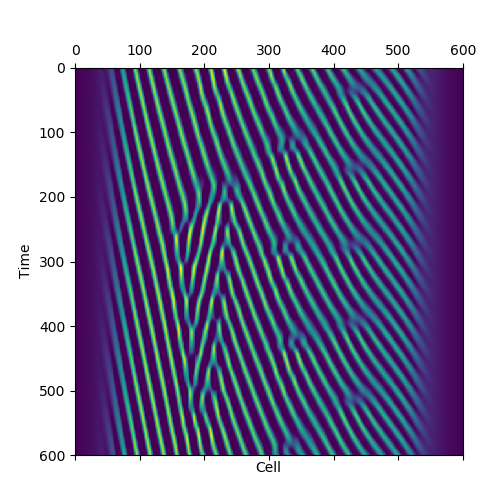

In [2234]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(results[-600:, :])
plt.xlabel("Cell")
plt.ylabel("Time")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


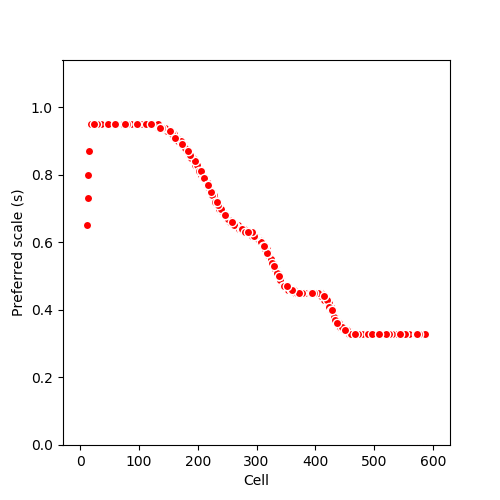

<IPython.core.display.Javascript object>


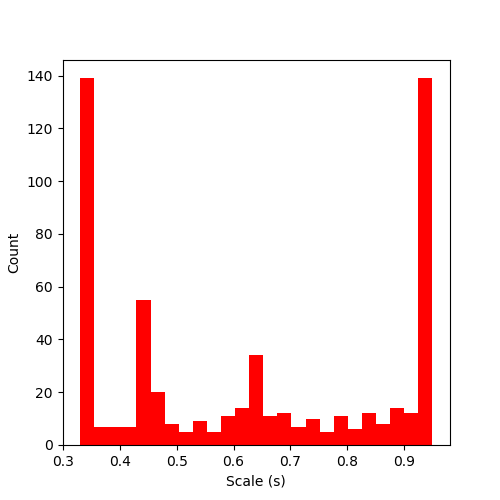

In [2244]:
plt.rcParams['figure.figsize'] = [5, 5]
activityScales = compute_scales(results[100:, :]/np.mean(results[100:, :], axis=0, keepdims=True))/100.
fig = plt.figure()
ax = plt.gca()
perm = np.random.permutation(len(activityScales)).astype("int")
ax.scatter(np.arange(activityScales.shape[0])[perm], (activityScales[perm]), c="red", edgecolor="white")
mod = 0.25
plt.xlabel("Cell")
plt.ylabel("Preferred scale (s)")
plt.ylim((0, 1.2*max(activityScales)))
plt.show()

plt.figure()
plt.hist(activityScales[activityScales > 0], bins=25, color="red")
plt.xlabel("Scale (s)")
plt.ylabel("Count")
plt.show()

In [2246]:
activityScales

array([-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01,  0.65,  0.73,  0.8 ,  0.87,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,  0.95,
        0.95,  0.95,

In [1516]:
for i in range(10):
    print(i)
    inhibGCN2.staticLearning(200,
                            logFreq=100000,
                            startFrom = 100.,
                            symmetrize=False)

0
1
2
3
4
5
6
7
8
9


In [2081]:
plt.rcParams['figure.figsize'] = [5, 5]
results, histResults, instResults = inhibGCN2.simulate(100,
                                                      logFreq=int(0.01/inhibGCN2.dt),
                                                      startFrom = 0.,
                                                      boosting=True)


At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35000000000000003
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41000000000000003
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47000000000000003
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.5700000000000001
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.6900000000000001
At 0.7000000000000001
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.8200000000000001
At 0.8300000000000001
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.9400000000000001
At 0.9500000000000001
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 

At 8.68
At 8.69
At 8.700000000000001
At 8.71
At 8.72
At 8.73
At 8.74
At 8.75
At 8.76
At 8.77
At 8.78
At 8.790000000000001
At 8.8
At 8.81
At 8.82
At 8.83
At 8.84
At 8.85
At 8.86
At 8.870000000000001
At 8.88
At 8.89
At 8.9
At 8.91
At 8.92
At 8.93
At 8.94
At 8.950000000000001
At 8.96
At 8.97
At 8.98
At 8.99
At 9.0
At 9.01
At 9.02
At 9.03
At 9.040000000000001
At 9.05
At 9.06
At 9.07
At 9.08
At 9.09
At 9.1
At 9.11
At 9.120000000000001
At 9.13
At 9.14
At 9.15
At 9.16
At 9.17
At 9.18
At 9.19
At 9.200000000000001
At 9.21
At 9.22
At 9.23
At 9.24
At 9.25
At 9.26
At 9.27
At 9.28
At 9.290000000000001
At 9.3
At 9.31
At 9.32
At 9.33
At 9.34
At 9.35
At 9.36
At 9.370000000000001
At 9.38
At 9.39
At 9.4
At 9.41
At 9.42
At 9.43
At 9.44
At 9.450000000000001
At 9.46
At 9.47
At 9.48
At 9.49
At 9.5
At 9.51
At 9.52
At 9.53
At 9.540000000000001
At 9.55
At 9.56
At 9.57
At 9.58
At 9.59
At 9.6
At 9.61
At 9.620000000000001
At 9.63
At 9.64
At 9.65
At 9.66
At 9.67
At 9.68
At 9.69
At 9.700000000000001
At 9.71
At 9.72

At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.95
At 16.96
At 16.97
At 16.98
At 16.990000000000002
At 17.0
At 17.01
At 17.02
At 17.03
At 17.04
At 17.05
At 17.06
At 17.07
At 17.080000000000002
At 17.09
At 17.1
At 17.11
At 17.12
At 17.13
At 17.14
At 17.150000000000002
At 17.16
At 17.17
At 17.18
At 17.19
At 17.2
At 17.21
At 17.22
At 17.23
At 17.240000000000002
At 17.25
At 17.26
At 17.27
At 17.28
At 17.29
At 17.3
At 17.31
At 17.32
At 17.330000000000002
At 17.34
At 17.35
At 17.36
At 17.37
At 17.38
At 17.39
At 17.400000000000002
At 17.41
At 17.42
At 17.43
At 17.44
At 17.45
At 17.46
At 17.47
At 17.48
At 17.490000000000002
At 17.5
At 17.51
At 17.52
At 17.53
At 17.54
At 17.55
At 17.56
At 17.57
At 17.580000000000002
At 17.59
At 17.6
At 17.61
At 17.62
At 17.63
At 17.64
At 17.650000000000002
At 17.66
At 17.67
At 17.68
At 17.69
At 17.7
At 17.71
At 17.72
At 17.73
At 17.740000000

At 24.72
At 24.73
At 24.740000000000002
At 24.75
At 24.76
At 24.77
At 24.78
At 24.79
At 24.8
At 24.810000000000002
At 24.82
At 24.830000000000002
At 24.84
At 24.85
At 24.86
At 24.87
At 24.88
At 24.89
At 24.900000000000002
At 24.91
At 24.92
At 24.93
At 24.94
At 24.95
At 24.96
At 24.97
At 24.98
At 24.990000000000002
At 25.0
At 25.01
At 25.02
At 25.03
At 25.04
At 25.05
At 25.060000000000002
At 25.07
At 25.080000000000002
At 25.09
At 25.1
At 25.11
At 25.12
At 25.13
At 25.14
At 25.150000000000002
At 25.16
At 25.17
At 25.18
At 25.19
At 25.2
At 25.21
At 25.22
At 25.23
At 25.240000000000002
At 25.25
At 25.26
At 25.27
At 25.28
At 25.29
At 25.3
At 25.310000000000002
At 25.32
At 25.330000000000002
At 25.34
At 25.35
At 25.36
At 25.37
At 25.38
At 25.39
At 25.400000000000002
At 25.41
At 25.42
At 25.43
At 25.44
At 25.45
At 25.46
At 25.47
At 25.48
At 25.490000000000002
At 25.5
At 25.51
At 25.52
At 25.53
At 25.54
At 25.55
At 25.560000000000002
At 25.57
At 25.580000000000002
At 25.59
At 25.6
At 25.61
At

At 32.35
At 32.36
At 32.37
At 32.38
At 32.39
At 32.4
At 32.410000000000004
At 32.42
At 32.43
At 32.44
At 32.45
At 32.46
At 32.47
At 32.480000000000004
At 32.49
At 32.5
At 32.51
At 32.52
At 32.53
At 32.54
At 32.55
At 32.56
At 32.57
At 32.58
At 32.59
At 32.6
At 32.61
At 32.62
At 32.63
At 32.64
At 32.65
At 32.660000000000004
At 32.67
At 32.68
At 32.69
At 32.7
At 32.71
At 32.72
At 32.730000000000004
At 32.74
At 32.75
At 32.76
At 32.77
At 32.78
At 32.79
At 32.8
At 32.81
At 32.82
At 32.83
At 32.84
At 32.85
At 32.86
At 32.87
At 32.88
At 32.89
At 32.9
At 32.910000000000004
At 32.92
At 32.93
At 32.94
At 32.95
At 32.96
At 32.97
At 32.980000000000004
At 32.99
At 33.0
At 33.01
At 33.02
At 33.03
At 33.04
At 33.05
At 33.06
At 33.07
At 33.08
At 33.09
At 33.1
At 33.11
At 33.12
At 33.13
At 33.14
At 33.15
At 33.160000000000004
At 33.17
At 33.18
At 33.19
At 33.2
At 33.21
At 33.22
At 33.230000000000004
At 33.24
At 33.25
At 33.26
At 33.27
At 33.28
At 33.29
At 33.3
At 33.31
At 33.32
At 33.33
At 33.34
At 33.

At 40.660000000000004
At 40.67
At 40.68
At 40.69
At 40.7
At 40.71
At 40.72
At 40.730000000000004
At 40.74
At 40.75
At 40.76
At 40.77
At 40.78
At 40.79
At 40.800000000000004
At 40.81
At 40.82
At 40.83
At 40.84
At 40.85
At 40.86
At 40.87
At 40.88
At 40.89
At 40.9
At 40.910000000000004
At 40.92
At 40.93
At 40.94
At 40.95
At 40.96
At 40.97
At 40.980000000000004
At 40.99
At 41.0
At 41.01
At 41.02
At 41.03
At 41.04
At 41.050000000000004
At 41.06
At 41.07
At 41.08
At 41.09
At 41.1
At 41.11
At 41.12
At 41.13
At 41.14
At 41.15
At 41.160000000000004
At 41.17
At 41.18
At 41.19
At 41.2
At 41.21
At 41.22
At 41.230000000000004
At 41.24
At 41.25
At 41.26
At 41.27
At 41.28
At 41.29
At 41.300000000000004
At 41.31
At 41.32
At 41.33
At 41.34
At 41.35
At 41.36
At 41.37
At 41.38
At 41.39
At 41.4
At 41.410000000000004
At 41.42
At 41.43
At 41.44
At 41.45
At 41.46
At 41.47
At 41.480000000000004
At 41.49
At 41.5
At 41.51
At 41.52
At 41.53
At 41.54
At 41.550000000000004
At 41.56
At 41.57
At 41.58
At 41.59
At 41

At 48.480000000000004
At 48.49
At 48.5
At 48.51
At 48.52
At 48.53
At 48.54
At 48.550000000000004
At 48.56
At 48.57
At 48.58
At 48.59
At 48.6
At 48.61
At 48.620000000000005
At 48.63
At 48.64
At 48.65
At 48.660000000000004
At 48.67
At 48.68
At 48.69
At 48.7
At 48.71
At 48.72
At 48.730000000000004
At 48.74
At 48.75
At 48.76
At 48.77
At 48.78
At 48.79
At 48.800000000000004
At 48.81
At 48.82
At 48.83
At 48.84
At 48.85
At 48.86
At 48.870000000000005
At 48.88
At 48.89
At 48.9
At 48.910000000000004
At 48.92
At 48.93
At 48.94
At 48.95
At 48.96
At 48.97
At 48.980000000000004
At 48.99
At 49.0
At 49.01
At 49.02
At 49.03
At 49.04
At 49.050000000000004
At 49.06
At 49.07
At 49.08
At 49.09
At 49.1
At 49.11
At 49.120000000000005
At 49.13
At 49.14
At 49.15
At 49.160000000000004
At 49.17
At 49.18
At 49.19
At 49.2
At 49.21
At 49.22
At 49.230000000000004
At 49.24
At 49.25
At 49.26
At 49.27
At 49.28
At 49.29
At 49.300000000000004
At 49.31
At 49.32
At 49.33
At 49.34
At 49.35
At 49.36
At 49.370000000000005
At

At 56.370000000000005
At 56.38
At 56.39
At 56.4
At 56.410000000000004
At 56.42
At 56.43
At 56.44
At 56.45
At 56.46
At 56.47
At 56.480000000000004
At 56.49
At 56.5
At 56.51
At 56.52
At 56.53
At 56.54
At 56.550000000000004
At 56.56
At 56.57
At 56.58
At 56.59
At 56.6
At 56.61
At 56.620000000000005
At 56.63
At 56.64
At 56.65
At 56.660000000000004
At 56.67
At 56.68
At 56.69
At 56.7
At 56.71
At 56.72
At 56.730000000000004
At 56.74
At 56.75
At 56.76
At 56.77
At 56.78
At 56.79
At 56.800000000000004
At 56.81
At 56.82
At 56.83
At 56.84
At 56.85
At 56.86
At 56.870000000000005
At 56.88
At 56.89
At 56.9
At 56.910000000000004
At 56.92
At 56.93
At 56.94
At 56.95
At 56.96
At 56.97
At 56.980000000000004
At 56.99
At 57.0
At 57.01
At 57.02
At 57.03
At 57.04
At 57.050000000000004
At 57.06
At 57.07
At 57.08
At 57.09
At 57.1
At 57.11
At 57.120000000000005
At 57.13
At 57.14
At 57.15
At 57.160000000000004
At 57.17
At 57.18
At 57.19
At 57.2
At 57.21
At 57.22
At 57.230000000000004
At 57.24
At 57.25
At 57.26
At 

At 64.24
At 64.25
At 64.26
At 64.27
At 64.28
At 64.29
At 64.3
At 64.31
At 64.32000000000001
At 64.33
At 64.34
At 64.35
At 64.36
At 64.37
At 64.38
At 64.39
At 64.4
At 64.41
At 64.42
At 64.43
At 64.44
At 64.45
At 64.46000000000001
At 64.47
At 64.48
At 64.49
At 64.5
At 64.51
At 64.52
At 64.53
At 64.54
At 64.55
At 64.56
At 64.57000000000001
At 64.58
At 64.59
At 64.6
At 64.61
At 64.62
At 64.63
At 64.64
At 64.65
At 64.66
At 64.67
At 64.68
At 64.69
At 64.7
At 64.71000000000001
At 64.72
At 64.73
At 64.74
At 64.75
At 64.76
At 64.77
At 64.78
At 64.79
At 64.8
At 64.81
At 64.82000000000001
At 64.83
At 64.84
At 64.85
At 64.86
At 64.87
At 64.88
At 64.89
At 64.9
At 64.91
At 64.92
At 64.93
At 64.94
At 64.95
At 64.96000000000001
At 64.97
At 64.98
At 64.99
At 65.0
At 65.01
At 65.02
At 65.03
At 65.04
At 65.05
At 65.06
At 65.07000000000001
At 65.08
At 65.09
At 65.1
At 65.11
At 65.12
At 65.13
At 65.14
At 65.15
At 65.16
At 65.17
At 65.18
At 65.19
At 65.2
At 65.21000000000001
At 65.22
At 65.23
At 65.24
At 65

At 72.42
At 72.43
At 72.44
At 72.45
At 72.46000000000001
At 72.47
At 72.48
At 72.49
At 72.5
At 72.51
At 72.52
At 72.53
At 72.54
At 72.55
At 72.56
At 72.57000000000001
At 72.58
At 72.59
At 72.60000000000001
At 72.61
At 72.62
At 72.63
At 72.64
At 72.65
At 72.66
At 72.67
At 72.68
At 72.69
At 72.7
At 72.71000000000001
At 72.72
At 72.73
At 72.74
At 72.75
At 72.76
At 72.77
At 72.78
At 72.79
At 72.8
At 72.81
At 72.82000000000001
At 72.83
At 72.84
At 72.85000000000001
At 72.86
At 72.87
At 72.88
At 72.89
At 72.9
At 72.91
At 72.92
At 72.93
At 72.94
At 72.95
At 72.96000000000001
At 72.97
At 72.98
At 72.99
At 73.0
At 73.01
At 73.02
At 73.03
At 73.04
At 73.05
At 73.06
At 73.07000000000001
At 73.08
At 73.09
At 73.10000000000001
At 73.11
At 73.12
At 73.13
At 73.14
At 73.15
At 73.16
At 73.17
At 73.18
At 73.19
At 73.2
At 73.21000000000001
At 73.22
At 73.23
At 73.24
At 73.25
At 73.26
At 73.27
At 73.28
At 73.29
At 73.3
At 73.31
At 73.32000000000001
At 73.33
At 73.34
At 73.35000000000001
At 73.36
At 73.37

At 80.83
At 80.84
At 80.85000000000001
At 80.86
At 80.87
At 80.88
At 80.89
At 80.9
At 80.91
At 80.92
At 80.93
At 80.94
At 80.95
At 80.96000000000001
At 80.97
At 80.98
At 80.99
At 81.0
At 81.01
At 81.02
At 81.03
At 81.04
At 81.05
At 81.06
At 81.07000000000001
At 81.08
At 81.09
At 81.10000000000001
At 81.11
At 81.12
At 81.13
At 81.14
At 81.15
At 81.16
At 81.17
At 81.18
At 81.19
At 81.2
At 81.21000000000001
At 81.22
At 81.23
At 81.24
At 81.25
At 81.26
At 81.27
At 81.28
At 81.29
At 81.3
At 81.31
At 81.32000000000001
At 81.33
At 81.34
At 81.35000000000001
At 81.36
At 81.37
At 81.38
At 81.39
At 81.4
At 81.41
At 81.42
At 81.43
At 81.44
At 81.45
At 81.46000000000001
At 81.47
At 81.48
At 81.49
At 81.5
At 81.51
At 81.52
At 81.53
At 81.54
At 81.55
At 81.56
At 81.57000000000001
At 81.58
At 81.59
At 81.60000000000001
At 81.61
At 81.62
At 81.63
At 81.64
At 81.65
At 81.66
At 81.67
At 81.68
At 81.69
At 81.7
At 81.71000000000001
At 81.72
At 81.73
At 81.74
At 81.75
At 81.76
At 81.77
At 81.78
At 81.79
At

At 89.27
At 89.28
At 89.29
At 89.3
At 89.31
At 89.32000000000001
At 89.33
At 89.34
At 89.35000000000001
At 89.36
At 89.37
At 89.38
At 89.39
At 89.4
At 89.41
At 89.42
At 89.43
At 89.44
At 89.45
At 89.46000000000001
At 89.47
At 89.48
At 89.49
At 89.5
At 89.51
At 89.52
At 89.53
At 89.54
At 89.55
At 89.56
At 89.57000000000001
At 89.58
At 89.59
At 89.60000000000001
At 89.61
At 89.62
At 89.63
At 89.64
At 89.65
At 89.66
At 89.67
At 89.68
At 89.69
At 89.7
At 89.71000000000001
At 89.72
At 89.73
At 89.74
At 89.75
At 89.76
At 89.77
At 89.78
At 89.79
At 89.8
At 89.81
At 89.82000000000001
At 89.83
At 89.84
At 89.85000000000001
At 89.86
At 89.87
At 89.88
At 89.89
At 89.9
At 89.91
At 89.92
At 89.93
At 89.94
At 89.95
At 89.96000000000001
At 89.97
At 89.98
At 89.99
At 90.0
At 90.01
At 90.02
At 90.03
At 90.04
At 90.05
At 90.06
At 90.07000000000001
At 90.08
At 90.09
At 90.10000000000001
At 90.11
At 90.12
At 90.13
At 90.14
At 90.15
At 90.16
At 90.17
At 90.18
At 90.19
At 90.2
At 90.21000000000001
At 90.22


At 97.84
At 97.85000000000001
At 97.86
At 97.87
At 97.88
At 97.89
At 97.9
At 97.91
At 97.92
At 97.93
At 97.94
At 97.95
At 97.96000000000001
At 97.97
At 97.98
At 97.99000000000001
At 98.0
At 98.01
At 98.02
At 98.03
At 98.04
At 98.05
At 98.06
At 98.07000000000001
At 98.08
At 98.09
At 98.10000000000001
At 98.11
At 98.12
At 98.13
At 98.14
At 98.15
At 98.16
At 98.17
At 98.18
At 98.19
At 98.2
At 98.21000000000001
At 98.22
At 98.23
At 98.24000000000001
At 98.25
At 98.26
At 98.27
At 98.28
At 98.29
At 98.3
At 98.31
At 98.32000000000001
At 98.33
At 98.34
At 98.35000000000001
At 98.36
At 98.37
At 98.38
At 98.39
At 98.4
At 98.41
At 98.42
At 98.43
At 98.44
At 98.45
At 98.46000000000001
At 98.47
At 98.48
At 98.49000000000001
At 98.5
At 98.51
At 98.52
At 98.53
At 98.54
At 98.55
At 98.56
At 98.57000000000001
At 98.58
At 98.59
At 98.60000000000001
At 98.61
At 98.62
At 98.63
At 98.64
At 98.65
At 98.66
At 98.67
At 98.68
At 98.69
At 98.7
At 98.71000000000001
At 98.72
At 98.73
At 98.74000000000001
At 98.75

<IPython.core.display.Javascript object>


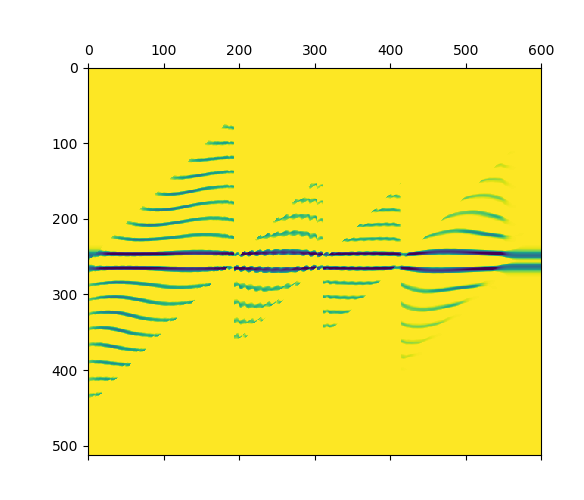

<IPython.core.display.Javascript object>


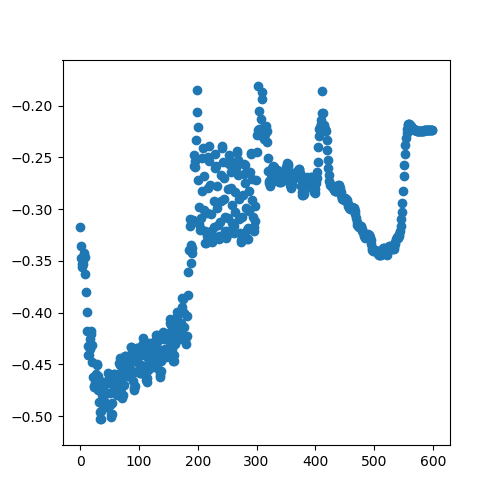

<IPython.core.display.Javascript object>


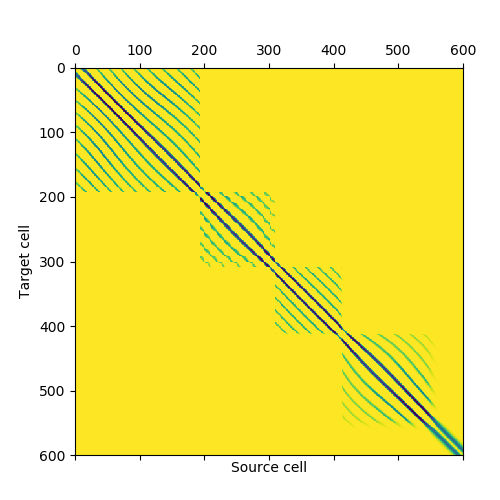

<IPython.core.display.Javascript object>


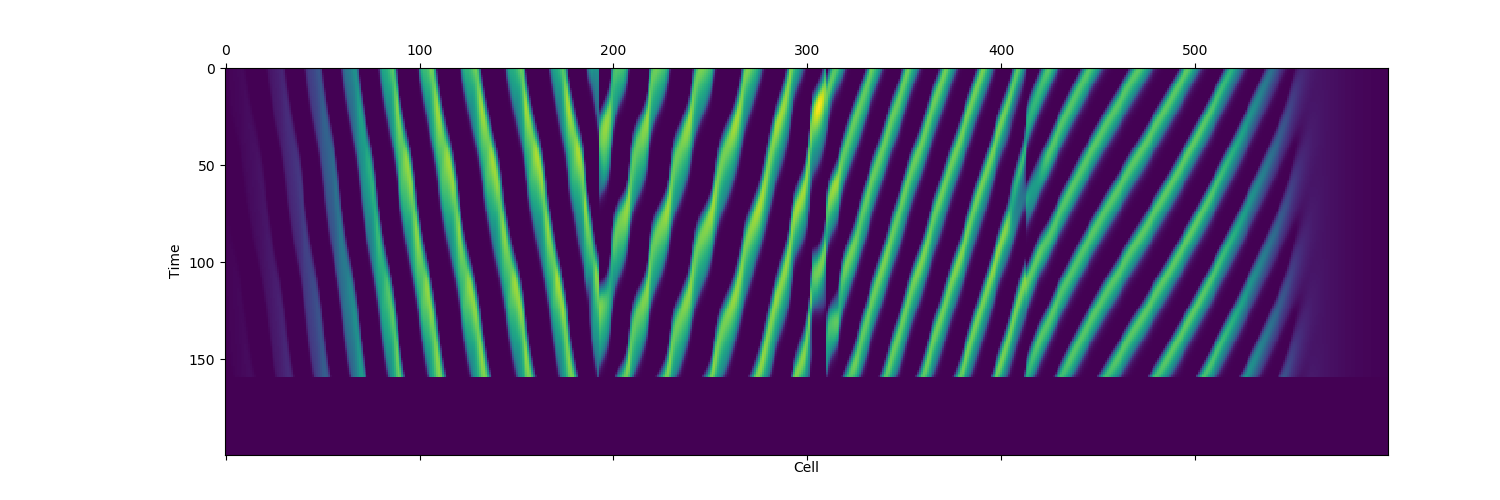

In [2186]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(inhibGCN2.inhibitoryWeights[0,:])
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.numX),
            torch.mean(inhibGCN2.inhibitoryWeights[0, :], dim=0))
plt.show()

weights = np.zeros((inhibGCN2.numX, inhibGCN2.numX))
stride = inhibGCN2.inhibitoryWeights.shape[-2]//2
for i in range(inhibGCN2.inhibitoryWeights.shape[-1]):
    lowerBound = max(i-stride, 0)
    upperBound = min(i + stride + 1, inhibGCN2.numX)
    weightUpperBound = min(stride - i  + inhibGCN2.numX, 2*stride+1)
    weightLowerBound = max(stride - i, 0)
    weights[lowerBound:upperBound, i] = inhibGCN2.inhibitoryWeights[0, weightLowerBound:weightUpperBound, i]

plt.matshow(weights)
plt.xlabel("Source cell")
plt.ylabel("Target cell")
plt.tight_layout()

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(results[-200:, :])
plt.xlabel("Cell")
plt.ylabel("Time")
plt.show()

In [2080]:

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(results[-200:, :])
plt.xlabel("Cell")
plt.ylabel("Time")
# plt.axvline(192, lw=5)
# plt.axvline(310, lw=5)
# plt.axvline(412, lw=5)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


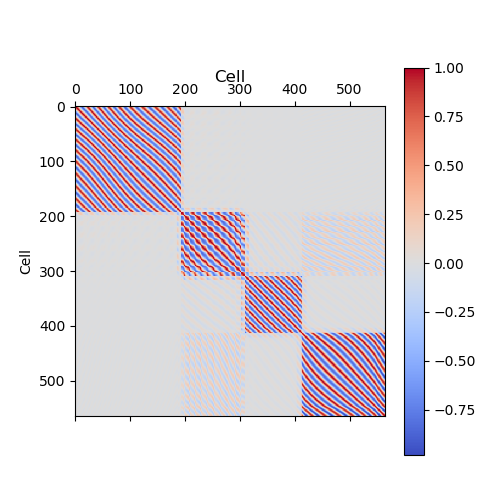

In [2088]:
corrs = np.corrcoef(results[100:], rowvar=False)
plt.matshow(corrs[:565, :565], cmap="coolwarm")
plt.colorbar()
plt.ylabel("Cell")
plt.title("Cell")
# plt.title("Cell-cell correlation")
plt.tight_layout()

1.500833796553641
1.4527716994894238
1.3941862682220798
-42.29545454545455


<IPython.core.display.Javascript object>


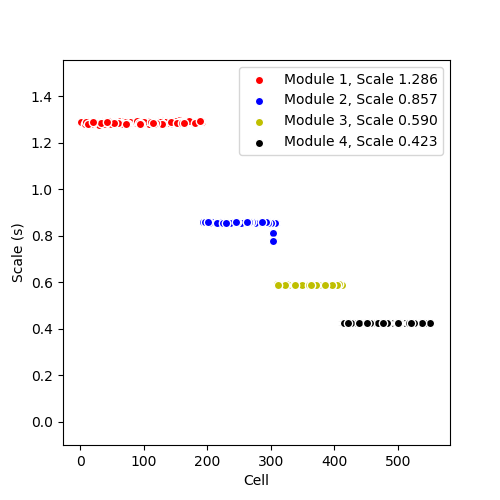

0 1 1.2857142857142858
1 2 0.8566666666666667
2 4 0.5896774193548387
3 0 0.42295454545454547
4 3 -0.01


In [1839]:
plt.rcParams['figure.figsize'] = [5, 5]
activityScales = compute_scales(np.asarray(results[100:, :])/np.mean(np.asarray(results[100:, :]), axis=0, keepdims=True))/100.
clusters, scales = calculateModuleScales(activityScales, 5)
sortedScales = sorted(scales, reverse=True)
for i in range(len(sortedScales) - 1):
    print(sortedScales[i]/sortedScales[i+1])
fig = plt.figure()
ax = plt.gca()
scales = np.asarray(scales)
moduleNumbers = np.argsort(-scales)
for i, moduleNumber in enumerate(moduleNumbers):
    scale = scales[moduleNumber]
    print(i, moduleNumber, scale)
    if scale <= 0:
        continue
    indices = np.where(clusters == moduleNumber)[0]
    perm = np.random.permutation(len(indices)).astype("int")
    ax.scatter(indices[perm],
               activityScales[indices[perm]],
               c=colors[i],
               label="Module {}, Scale {:4.3f}".format(i + 1, scale),
               edgecolor="white")
plt.xlabel("Cell")
plt.ylabel("Scale (s)")
plt.ylim((-.1, 1.2*max(activityScales)))
plt.legend()


In [1544]:
inhibGCN2.placeWeightDecay = 30
inhibGCN2.learnFactorP = 5000
inhibGCN2.placeWeights.fill_(0.)

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]], device='cuda:0')

In [1545]:
(results,
instResults,
histResults,
placeResults) = inhibGCN2.learn(1,
                                plotting=False,
                                logFreq=(0.01/inhibGCN2.dt),
                                speed=1.,
                                preSimulateTime=5,
                                learnInhibitory=False,
                                learnExcitatory=False,
                                simulateTonicBoost=1.)

Starting run 0


<IPython.core.display.Javascript object>


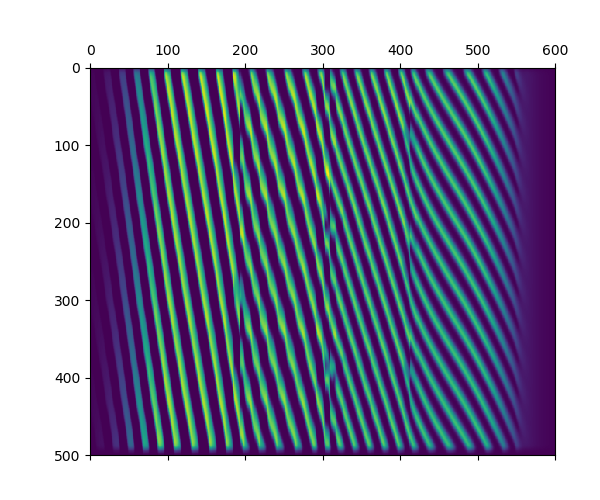

In [1546]:
plt.matshow(torch.transpose(inhibGCN2.placeWeights, 0, 1))

<IPython.core.display.Javascript object>


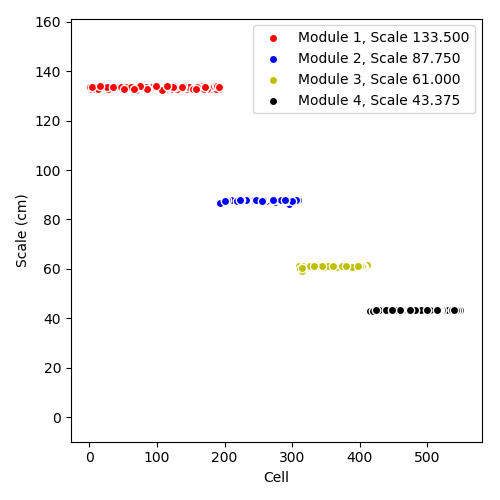

0 0 133.5
1 2 87.75
2 4 61.0
3 1 43.375
4 3 -1.0


In [1838]:
plt.rcParams['figure.figsize'] = [5, 5]
mat = torch.transpose(inhibGCN2.placeWeights, 0, 1).cpu().numpy()
activityScales = compute_scales(mat[50:-50, :]/np.mean(mat[50:-50, :], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
clusters, scales = calculateModuleScales(activityScales, 5)
scales = np.asarray(scales)
moduleNumbers = np.argsort(-scales)
for i, moduleNumber in enumerate(moduleNumbers):
    scale = scales[moduleNumber]
    print(i, moduleNumber, scale)
    if scale <= 0:
        continue
    indices = np.where(clusters == moduleNumber)[0]
    perm = np.random.permutation(len(indices)).astype("int")
    ax.scatter(indices[perm],
               activityScales[indices[perm]],
               c=colors[i],
               label="Module {}, Scale {:4.3f}".format(i + 1, scale),
               edgecolor="white")
plt.xlabel("Cell")
plt.ylabel("Scale (cm)")
plt.ylim((-10, 1.2*max(activityScales)))
plt.legend()

plt.tight_layout()
plt.show()

In [1793]:
moduleNumbers

array([1, 3, 0, 2], dtype=int64)

<IPython.core.display.Javascript object>


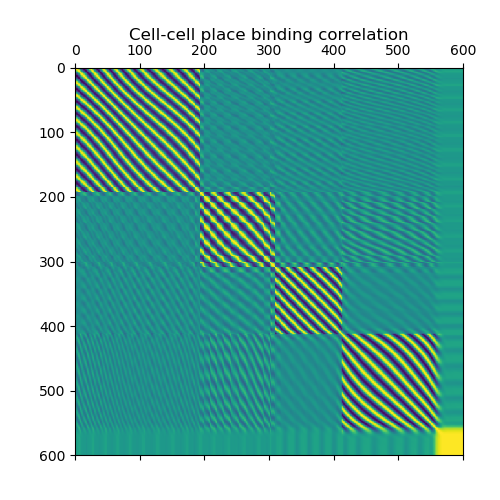

Text(0.5,1.05,'Cell-cell place binding correlation')

In [1550]:
corrs = np.corrcoef(inhibGCN2.placeWeights, rowvar=True)
plt.matshow(corrs)
plt.title("Cell-cell place binding correlation")

In [2247]:
import pickle as pkl
with open(os.getcwd() + "\\perfectmodel.pkl", "wb") as f:
    pkl.dump(inhibGCN2, f)

In [2195]:
inhibGCN2.excitatoryWeightDecay = 100000
inhibGCN2.learnFactorE = 3

In [2196]:
inhibGCN2.negativeLearnFactorE *= 2

In [2197]:
inhibGCN2.placeWeights *= 5
inhibGCN2.globalTonic *= 5

In [2198]:
inhibGCN2.excitatoryWeights["s"]/= 2
inhibGCN2.excitatoryWeights["n"]/= 2

In [2199]:
(results,
histResults,
instResults,
placeResults) = inhibGCN2.learn(10,
                                preSimulateTime=2.,
                                plotting=False,
                                logFreq=(0.01/inhibGCN2.dt),
                                speed=1.,
                                learnInhibitory=False,
                                learnExcitatory=True,
                                learnPlace=False,
                                useExcitatory=True,
                                boosting=True,
                                learnStart=0)

Starting run 0
Starting run 1
Starting run 2
Starting run 3
Starting run 4
Starting run 5
Starting run 6
Starting run 7
Starting run 8
Starting run 9


<IPython.core.display.Javascript object>


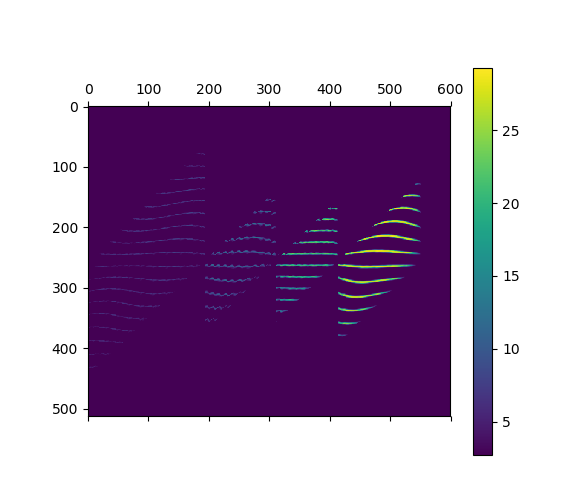

In [2200]:
plt.matshow(torch.exp(torch.exp(inhibGCN2.excitatoryWeights["n"][0])))
plt.colorbar()

<IPython.core.display.Javascript object>


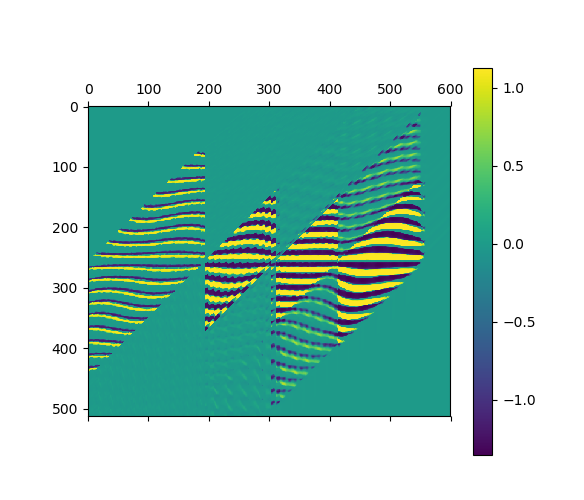

<IPython.core.display.Javascript object>


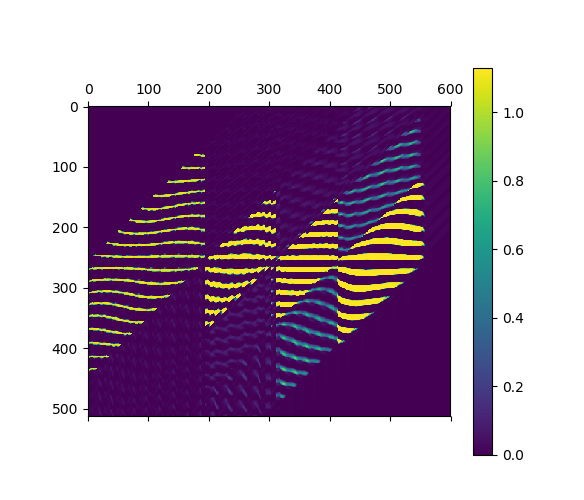

<IPython.core.display.Javascript object>


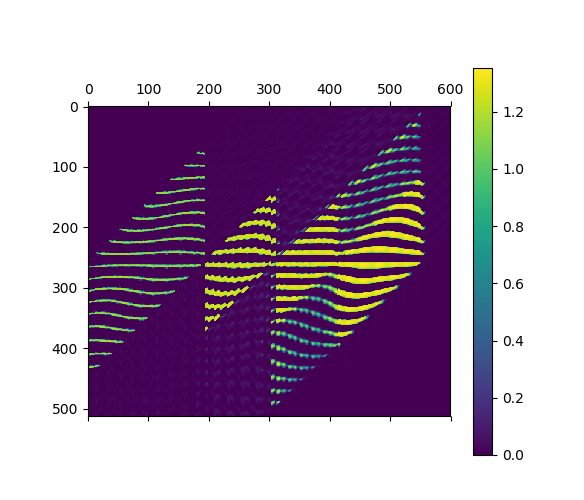

<IPython.core.display.Javascript object>


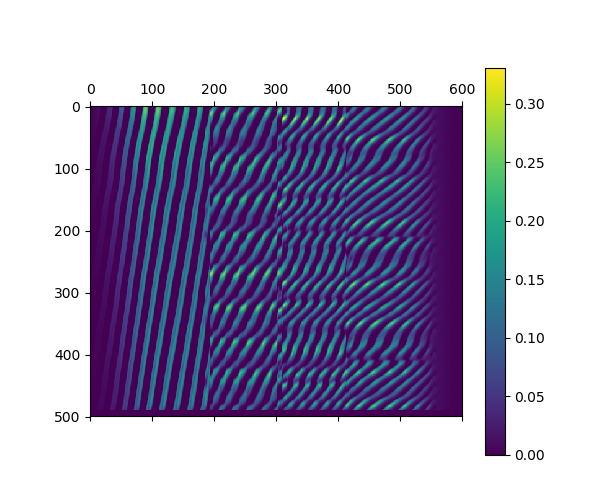

In [2193]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(inhibGCN2.excitatoryWeights["s"][0] - inhibGCN2.excitatoryWeights["n"][0])
plt.colorbar()
plt.matshow(inhibGCN2.excitatoryWeights["s"][0])
plt.colorbar()
plt.matshow(inhibGCN2.excitatoryWeights["n"][0])
plt.colorbar()
plt.matshow(results[-500:])
plt.colorbar()

In [2160]:
plt.rcParams['figure.figsize'] = [5, 5]
simresults, simhistResults, siminstResults = inhibGCN2.simulate(20,
                                                      logFreq=int(0.01/inhibGCN2.dt),
                                                      startFrom = 10.,
                                                      vel=-1.,
                                                      boosting=False)

At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 10.13
At 10.14
At 10.15
At 10.16
At 10.17
At 10.18
At 10.19
At 10.200000000000001
At 10.21
At 10.22
At 10.23
At 10.24
At 10.25
At 10.26
At 10.27
At 10.28
At 10.290000000000001
At 10.3
At 10.31
At 10.32
At 10.33
At 10.34
At 10.35
At 10.36
At 10.370000000000001
At 10.38
At 10.39
At 10.4
At 10.41
At 10.42
At 10.43
At 10.44
At 10.450000000000001
At 10.46
At 10.47
At 10.48
At 10.49
At 10.5
At 10.51
At 10.52
At 10.53
At 10.540000000000001
At 10.55
At 10.56
At 10.57
At 10.58
At 10.59
At 10.6
At 10.61
At 10.620000000000001
At 10.63
At 10.64
At 10.65
At 10.66
At 10.67
At 10.68
At 10.69
At 10.700000000000001
At 10.71
At 10.72
At 10.73
At 10.74
At 10.75
At 10.76
At 10.77
At 10.78
At 10.790000000000001
At 10.8
At 10.81
At 10.82
At 10.83
At 10.84
At 10.85
At 10.86
At 10.870000000000001
At 10.88
At 10.89
At 10.9
At 10.91
At 10.92
At 10.93
At 10.94
At 10.9500

At 18.0
At 18.01
At 18.02
At 18.03
At 18.04
At 18.05
At 18.06
At 18.07
At 18.080000000000002
At 18.09
At 18.1
At 18.11
At 18.12
At 18.13
At 18.14
At 18.150000000000002
At 18.16
At 18.17
At 18.18
At 18.19
At 18.2
At 18.21
At 18.22
At 18.23
At 18.240000000000002
At 18.25
At 18.26
At 18.27
At 18.28
At 18.29
At 18.3
At 18.31
At 18.32
At 18.330000000000002
At 18.34
At 18.35
At 18.36
At 18.37
At 18.38
At 18.39
At 18.400000000000002
At 18.41
At 18.42
At 18.43
At 18.44
At 18.45
At 18.46
At 18.47
At 18.48
At 18.490000000000002
At 18.5
At 18.51
At 18.52
At 18.53
At 18.54
At 18.55
At 18.56
At 18.57
At 18.580000000000002
At 18.59
At 18.6
At 18.61
At 18.62
At 18.63
At 18.64
At 18.650000000000002
At 18.66
At 18.67
At 18.68
At 18.69
At 18.7
At 18.71
At 18.72
At 18.73
At 18.740000000000002
At 18.75
At 18.76
At 18.77
At 18.78
At 18.79
At 18.8
At 18.81
At 18.82
At 18.830000000000002
At 18.84
At 18.85
At 18.86
At 18.87
At 18.88
At 18.89
At 18.900000000000002
At 18.91
At 18.92
At 18.93
At 18.94
At 18.95
A

<IPython.core.display.Javascript object>


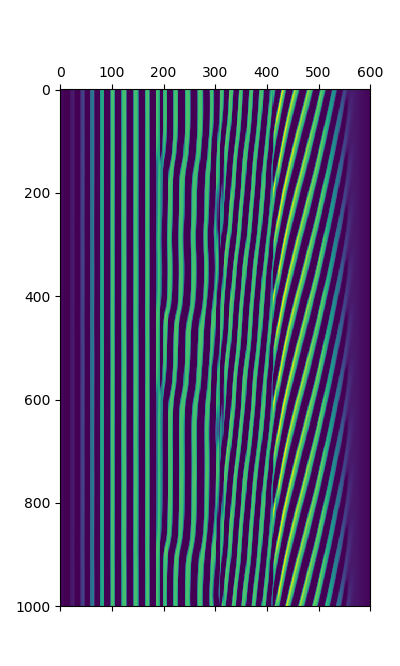

In [2161]:
plt.matshow(simresults[-1000:, :])

2.109004739336493
2.0288461538461537
-104.0


<IPython.core.display.Javascript object>


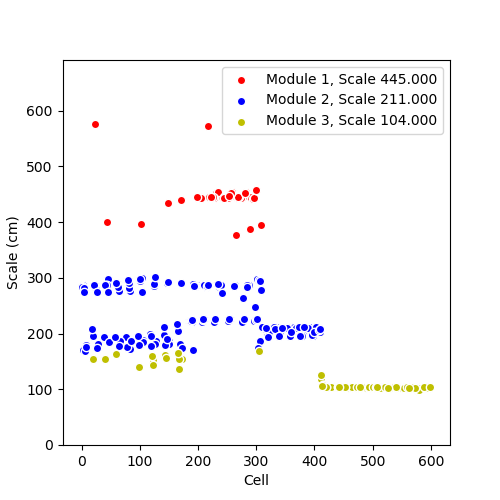

0 1 445.0
1 3 211.0
2 0 104.0
3 2 -1.0


In [2162]:
plt.rcParams['figure.figsize'] = [5, 5]
activityScales = compute_scales(np.asarray(simresults[-1000:, :])/\
                                np.median(np.asarray(simresults[-1000:, :]), axis=0, keepdims=True))
clusters, scales = calculateModuleScales(activityScales, 4)
sortedScales = sorted(scales, reverse=True)
for i in range(len(sortedScales) - 1):
    print(sortedScales[i]/sortedScales[i+1])
fig = plt.figure()
ax = plt.gca()
scales = np.asarray(scales)
moduleNumbers = np.argsort(-scales)
for i, moduleNumber in enumerate(moduleNumbers):
    scale = scales[moduleNumber]
    print(i, moduleNumber, scale)
    if scale <= 0:
        continue
    indices = np.where(clusters == moduleNumber)[0]
    perm = np.random.permutation(len(indices)).astype("int")
    ax.scatter(indices[perm],
               activityScales[indices[perm]],
               c=colors[i],
               label="Module {}, Scale {:4.3f}".format(i + 1, scale),
               edgecolor="white")
plt.xlabel("Cell")
plt.ylabel("Scale (cm)")
plt.ylim((-.1, 1.2*max(activityScales)))
plt.legend()

In [2128]:
orderedClusters = np.zeros(clusters.shape)
for i, moduleNumber in enumerate(moduleNumbers):
    indices = np.where(clusters == moduleNumber)[0]
    orderedClusters[indices] = i

In [1985]:
vels = np.linspace(.1, 1.5, 15)
positiveModuleScales = calculatePathIntegrationSpeeds(vels, inhibGCN2, orderedClusters, simLength=20, dt=0.01)
negativeModuleScales = calculatePathIntegrationSpeeds(-vels, inhibGCN2, orderedClusters, simLength=20, dt=0.01)

At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 10.13
At 10.14
At 10.15
At 10.16
At 10.17
At 10.18
At 10.19
At 10.200000000000001
At 10.21
At 10.22
At 10.23
At 10.24
At 10.25
At 10.26
At 10.27
At 10.28
At 10.290000000000001
At 10.3
At 10.31
At 10.32
At 10.33
At 10.34
At 10.35
At 10.36
At 10.370000000000001
At 10.38
At 10.39
At 10.4
At 10.41
At 10.42
At 10.43
At 10.44
At 10.450000000000001
At 10.46
At 10.47
At 10.48
At 10.49
At 10.5
At 10.51
At 10.52
At 10.53
At 10.540000000000001
At 10.55
At 10.56
At 10.57
At 10.58
At 10.59
At 10.6
At 10.61
At 10.620000000000001
At 10.63
At 10.64
At 10.65
At 10.66
At 10.67
At 10.68
At 10.69
At 10.700000000000001
At 10.71
At 10.72
At 10.73
At 10.74
At 10.75
At 10.76
At 10.77
At 10.78
At 10.790000000000001
At 10.8
At 10.81
At 10.82
At 10.83
At 10.84
At 10.85
At 10.86
At 10.870000000000001
At 10.88
At 10.89
At 10.9
At 10.91
At 10.92
At 10.93
At 10.94
At 10.9500

At 17.95
At 17.96
At 17.97
At 17.98
At 17.990000000000002
At 18.0
At 18.01
At 18.02
At 18.03
At 18.04
At 18.05
At 18.06
At 18.07
At 18.080000000000002
At 18.09
At 18.1
At 18.11
At 18.12
At 18.13
At 18.14
At 18.150000000000002
At 18.16
At 18.17
At 18.18
At 18.19
At 18.2
At 18.21
At 18.22
At 18.23
At 18.240000000000002
At 18.25
At 18.26
At 18.27
At 18.28
At 18.29
At 18.3
At 18.31
At 18.32
At 18.330000000000002
At 18.34
At 18.35
At 18.36
At 18.37
At 18.38
At 18.39
At 18.400000000000002
At 18.41
At 18.42
At 18.43
At 18.44
At 18.45
At 18.46
At 18.47
At 18.48
At 18.490000000000002
At 18.5
At 18.51
At 18.52
At 18.53
At 18.54
At 18.55
At 18.56
At 18.57
At 18.580000000000002
At 18.59
At 18.6
At 18.61
At 18.62
At 18.63
At 18.64
At 18.650000000000002
At 18.66
At 18.67
At 18.68
At 18.69
At 18.7
At 18.71
At 18.72
At 18.73
At 18.740000000000002
At 18.75
At 18.76
At 18.77
At 18.78
At 18.79
At 18.8
At 18.81
At 18.82
At 18.830000000000002
At 18.84
At 18.85
At 18.86
At 18.87
At 18.88
At 18.89
At 18.9000

At 16.31
At 16.32
At 16.330000000000002
At 16.34
At 16.35
At 16.36
At 16.37
At 16.38
At 16.39
At 16.4
At 16.41
At 16.42
At 16.43
At 16.44
At 16.45
At 16.46
At 16.47
At 16.48
At 16.490000000000002
At 16.5
At 16.51
At 16.52
At 16.53
At 16.54
At 16.55
At 16.56
At 16.57
At 16.580000000000002
At 16.59
At 16.6
At 16.61
At 16.62
At 16.63
At 16.64
At 16.65
At 16.66
At 16.67
At 16.68
At 16.69
At 16.7
At 16.71
At 16.72
At 16.73
At 16.740000000000002
At 16.75
At 16.76
At 16.77
At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.95
At 16.96
At 16.97
At 16.98
At 16.990000000000002
At 17.0
At 17.01
At 17.02
At 17.03
At 17.04
At 17.05
At 17.06
At 17.07
At 17.080000000000002
At 17.09
At 17.1
At 17.11
At 17.12
At 17.13
At 17.14
At 17.150000000000002
At 17.16
At 17.17
At 17.18
At 17.19
At 17.2
At 17.21
At 17.22
At 17.23
At 17.240000000000002
At 17.25
At 17.26
At 17.27
At 17.28
At 17.29
A

At 14.16
At 14.17
At 14.18
At 14.19
At 14.200000000000001
At 14.21
At 14.22
At 14.23
At 14.24
At 14.25
At 14.26
At 14.27
At 14.280000000000001
At 14.290000000000001
At 14.3
At 14.31
At 14.32
At 14.33
At 14.34
At 14.35
At 14.36
At 14.370000000000001
At 14.38
At 14.39
At 14.4
At 14.41
At 14.42
At 14.43
At 14.44
At 14.450000000000001
At 14.46
At 14.47
At 14.48
At 14.49
At 14.5
At 14.51
At 14.52
At 14.530000000000001
At 14.540000000000001
At 14.55
At 14.56
At 14.57
At 14.58
At 14.59
At 14.6
At 14.61
At 14.620000000000001
At 14.63
At 14.64
At 14.65
At 14.66
At 14.67
At 14.68
At 14.69
At 14.700000000000001
At 14.71
At 14.72
At 14.73
At 14.74
At 14.75
At 14.76
At 14.77
At 14.780000000000001
At 14.790000000000001
At 14.8
At 14.81
At 14.82
At 14.83
At 14.84
At 14.85
At 14.86
At 14.870000000000001
At 14.88
At 14.89
At 14.9
At 14.91
At 14.92
At 14.93
At 14.94
At 14.950000000000001
At 14.96
At 14.97
At 14.98
At 14.99
At 15.0
At 15.01
At 15.02
At 15.030000000000001
At 15.040000000000001
At 15.05
At

At 12.05
At 12.06
At 12.07
At 12.08
At 12.09
At 12.1
At 12.11
At 12.120000000000001
At 12.13
At 12.14
At 12.15
At 12.16
At 12.17
At 12.18
At 12.19
At 12.200000000000001
At 12.21
At 12.22
At 12.23
At 12.24
At 12.25
At 12.26
At 12.27
At 12.280000000000001
At 12.290000000000001
At 12.3
At 12.31
At 12.32
At 12.33
At 12.34
At 12.35
At 12.36
At 12.370000000000001
At 12.38
At 12.39
At 12.4
At 12.41
At 12.42
At 12.43
At 12.44
At 12.450000000000001
At 12.46
At 12.47
At 12.48
At 12.49
At 12.5
At 12.51
At 12.52
At 12.530000000000001
At 12.540000000000001
At 12.55
At 12.56
At 12.57
At 12.58
At 12.59
At 12.6
At 12.61
At 12.620000000000001
At 12.63
At 12.64
At 12.65
At 12.66
At 12.67
At 12.68
At 12.69
At 12.700000000000001
At 12.71
At 12.72
At 12.73
At 12.74
At 12.75
At 12.76
At 12.77
At 12.780000000000001
At 12.790000000000001
At 12.8
At 12.81
At 12.82
At 12.83
At 12.84
At 12.85
At 12.86
At 12.870000000000001
At 12.88
At 12.89
At 12.9
At 12.91
At 12.92
At 12.93
At 12.94
At 12.950000000000001
At 12.

At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 10.13
At 10.14
At 10.15
At 10.16
At 10.17
At 10.18
At 10.19
At 10.200000000000001
At 10.21
At 10.22
At 10.23
At 10.24
At 10.25
At 10.26
At 10.27
At 10.28
At 10.290000000000001
At 10.3
At 10.31
At 10.32
At 10.33
At 10.34
At 10.35
At 10.36
At 10.370000000000001
At 10.38
At 10.39
At 10.4
At 10.41
At 10.42
At 10.43
At 10.44
At 10.450000000000001
At 10.46
At 10.47
At 10.48
At 10.49
At 10.5
At 10.51
At 10.52
At 10.53
At 10.540000000000001
At 10.55
At 10.56
At 10.57
At 10.58
At 10.59
At 10.6
At 10.61
At 10.620000000000001
At 10.63
At 10.64
At 10.65
At 10.66
At 10.67
At 10.68
At 10.69
At 10.700000000000001
At 10.71
At 10.72
At 10.73
At 10.74
At 10.75
At 10.76
At 10.77
At 10.78
At 10.790000000000001
At 10.8
At 10.81
At 10.82
At 10.83
At 10.84
At 10.85
At 10.86
At 10.870000000000001
At 10.88
At 10.89
At 10.9
At 10.91
At 10.92
At 10.93
At 10.94
At 10.9500

At 18.330000000000002
At 18.34
At 18.35
At 18.36
At 18.37
At 18.38
At 18.39
At 18.400000000000002
At 18.41
At 18.42
At 18.43
At 18.44
At 18.45
At 18.46
At 18.47
At 18.48
At 18.490000000000002
At 18.5
At 18.51
At 18.52
At 18.53
At 18.54
At 18.55
At 18.56
At 18.57
At 18.580000000000002
At 18.59
At 18.6
At 18.61
At 18.62
At 18.63
At 18.64
At 18.650000000000002
At 18.66
At 18.67
At 18.68
At 18.69
At 18.7
At 18.71
At 18.72
At 18.73
At 18.740000000000002
At 18.75
At 18.76
At 18.77
At 18.78
At 18.79
At 18.8
At 18.81
At 18.82
At 18.830000000000002
At 18.84
At 18.85
At 18.86
At 18.87
At 18.88
At 18.89
At 18.900000000000002
At 18.91
At 18.92
At 18.93
At 18.94
At 18.95
At 18.96
At 18.97
At 18.98
At 18.990000000000002
At 19.0
At 19.01
At 19.02
At 19.03
At 19.04
At 19.05
At 19.06
At 19.07
At 19.080000000000002
At 19.09
At 19.1
At 19.11
At 19.12
At 19.13
At 19.14
At 19.150000000000002
At 19.16
At 19.17
At 19.18
At 19.19
At 19.2
At 19.21
At 19.22
At 19.23
At 19.240000000000002
At 19.25
At 19.26
At 19

At 16.03
At 16.04
At 16.05
At 16.06
At 16.07
At 16.080000000000002
At 16.09
At 16.1
At 16.11
At 16.12
At 16.13
At 16.14
At 16.15
At 16.16
At 16.17
At 16.18
At 16.19
At 16.2
At 16.21
At 16.22
At 16.23
At 16.240000000000002
At 16.25
At 16.26
At 16.27
At 16.28
At 16.29
At 16.3
At 16.31
At 16.32
At 16.330000000000002
At 16.34
At 16.35
At 16.36
At 16.37
At 16.38
At 16.39
At 16.4
At 16.41
At 16.42
At 16.43
At 16.44
At 16.45
At 16.46
At 16.47
At 16.48
At 16.490000000000002
At 16.5
At 16.51
At 16.52
At 16.53
At 16.54
At 16.55
At 16.56
At 16.57
At 16.580000000000002
At 16.59
At 16.6
At 16.61
At 16.62
At 16.63
At 16.64
At 16.65
At 16.66
At 16.67
At 16.68
At 16.69
At 16.7
At 16.71
At 16.72
At 16.73
At 16.740000000000002
At 16.75
At 16.76
At 16.77
At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.95
At 16.96
At 16.97
At 16.98
At 16.990000000000002
At 17.0
At 17.01
At 17.02
At 17.

At 13.96
At 13.97
At 13.98
At 13.99
At 14.0
At 14.01
At 14.02
At 14.030000000000001
At 14.040000000000001
At 14.05
At 14.06
At 14.07
At 14.08
At 14.09
At 14.1
At 14.11
At 14.120000000000001
At 14.13
At 14.14
At 14.15
At 14.16
At 14.17
At 14.18
At 14.19
At 14.200000000000001
At 14.21
At 14.22
At 14.23
At 14.24
At 14.25
At 14.26
At 14.27
At 14.280000000000001
At 14.290000000000001
At 14.3
At 14.31
At 14.32
At 14.33
At 14.34
At 14.35
At 14.36
At 14.370000000000001
At 14.38
At 14.39
At 14.4
At 14.41
At 14.42
At 14.43
At 14.44
At 14.450000000000001
At 14.46
At 14.47
At 14.48
At 14.49
At 14.5
At 14.51
At 14.52
At 14.530000000000001
At 14.540000000000001
At 14.55
At 14.56
At 14.57
At 14.58
At 14.59
At 14.6
At 14.61
At 14.620000000000001
At 14.63
At 14.64
At 14.65
At 14.66
At 14.67
At 14.68
At 14.69
At 14.700000000000001
At 14.71
At 14.72
At 14.73
At 14.74
At 14.75
At 14.76
At 14.77
At 14.780000000000001
At 14.790000000000001
At 14.8
At 14.81
At 14.82
At 14.83
At 14.84
At 14.85
At 14.86
At 14.

At 12.120000000000001
At 12.13
At 12.14
At 12.15
At 12.16
At 12.17
At 12.18
At 12.19
At 12.200000000000001
At 12.21
At 12.22
At 12.23
At 12.24
At 12.25
At 12.26
At 12.27
At 12.280000000000001
At 12.290000000000001
At 12.3
At 12.31
At 12.32
At 12.33
At 12.34
At 12.35
At 12.36
At 12.370000000000001
At 12.38
At 12.39
At 12.4
At 12.41
At 12.42
At 12.43
At 12.44
At 12.450000000000001
At 12.46
At 12.47
At 12.48
At 12.49
At 12.5
At 12.51
At 12.52
At 12.530000000000001
At 12.540000000000001
At 12.55
At 12.56
At 12.57
At 12.58
At 12.59
At 12.6
At 12.61
At 12.620000000000001
At 12.63
At 12.64
At 12.65
At 12.66
At 12.67
At 12.68
At 12.69
At 12.700000000000001
At 12.71
At 12.72
At 12.73
At 12.74
At 12.75
At 12.76
At 12.77
At 12.780000000000001
At 12.790000000000001
At 12.8
At 12.81
At 12.82
At 12.83
At 12.84
At 12.85
At 12.86
At 12.870000000000001
At 12.88
At 12.89
At 12.9
At 12.91
At 12.92
At 12.93
At 12.94
At 12.950000000000001
At 12.96
At 12.97
At 12.98
At 12.99
At 13.0
At 13.01
At 13.02
At 13.

At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 10.13
At 10.14
At 10.15
At 10.16
At 10.17
At 10.18
At 10.19
At 10.200000000000001
At 10.21
At 10.22
At 10.23
At 10.24
At 10.25
At 10.26
At 10.27
At 10.28
At 10.290000000000001
At 10.3
At 10.31
At 10.32
At 10.33
At 10.34
At 10.35
At 10.36
At 10.370000000000001
At 10.38
At 10.39
At 10.4
At 10.41
At 10.42
At 10.43
At 10.44
At 10.450000000000001
At 10.46
At 10.47
At 10.48
At 10.49
At 10.5
At 10.51
At 10.52
At 10.53
At 10.540000000000001
At 10.55
At 10.56
At 10.57
At 10.58
At 10.59
At 10.6
At 10.61
At 10.620000000000001
At 10.63
At 10.64
At 10.65
At 10.66
At 10.67
At 10.68
At 10.69
At 10.700000000000001
At 10.71
At 10.72
At 10.73
At 10.74
At 10.75
At 10.76
At 10.77
At 10.78
At 10.790000000000001
At 10.8
At 10.81
At 10.82
At 10.83
At 10.84
At 10.85
At 10.86
At 10.870000000000001
At 10.88
At 10.89
At 10.9
At 10.91
At 10.92
At 10.93
At 10.94
At 10.9500

At 18.12
At 18.13
At 18.14
At 18.150000000000002
At 18.16
At 18.17
At 18.18
At 18.19
At 18.2
At 18.21
At 18.22
At 18.23
At 18.240000000000002
At 18.25
At 18.26
At 18.27
At 18.28
At 18.29
At 18.3
At 18.31
At 18.32
At 18.330000000000002
At 18.34
At 18.35
At 18.36
At 18.37
At 18.38
At 18.39
At 18.400000000000002
At 18.41
At 18.42
At 18.43
At 18.44
At 18.45
At 18.46
At 18.47
At 18.48
At 18.490000000000002
At 18.5
At 18.51
At 18.52
At 18.53
At 18.54
At 18.55
At 18.56
At 18.57
At 18.580000000000002
At 18.59
At 18.6
At 18.61
At 18.62
At 18.63
At 18.64
At 18.650000000000002
At 18.66
At 18.67
At 18.68
At 18.69
At 18.7
At 18.71
At 18.72
At 18.73
At 18.740000000000002
At 18.75
At 18.76
At 18.77
At 18.78
At 18.79
At 18.8
At 18.81
At 18.82
At 18.830000000000002
At 18.84
At 18.85
At 18.86
At 18.87
At 18.88
At 18.89
At 18.900000000000002
At 18.91
At 18.92
At 18.93
At 18.94
At 18.95
At 18.96
At 18.97
At 18.98
At 18.990000000000002
At 19.0
At 19.01
At 19.02
At 19.03
At 19.04
At 19.05
At 19.06
At 19.07


At 16.21
At 16.22
At 16.23
At 16.240000000000002
At 16.25
At 16.26
At 16.27
At 16.28
At 16.29
At 16.3
At 16.31
At 16.32
At 16.330000000000002
At 16.34
At 16.35
At 16.36
At 16.37
At 16.38
At 16.39
At 16.4
At 16.41
At 16.42
At 16.43
At 16.44
At 16.45
At 16.46
At 16.47
At 16.48
At 16.490000000000002
At 16.5
At 16.51
At 16.52
At 16.53
At 16.54
At 16.55
At 16.56
At 16.57
At 16.580000000000002
At 16.59
At 16.6
At 16.61
At 16.62
At 16.63
At 16.64
At 16.65
At 16.66
At 16.67
At 16.68
At 16.69
At 16.7
At 16.71
At 16.72
At 16.73
At 16.740000000000002
At 16.75
At 16.76
At 16.77
At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.95
At 16.96
At 16.97
At 16.98
At 16.990000000000002
At 17.0
At 17.01
At 17.02
At 17.03
At 17.04
At 17.05
At 17.06
At 17.07
At 17.080000000000002
At 17.09
At 17.1
At 17.11
At 17.12
At 17.13
At 17.14
At 17.150000000000002
At 17.16
At 17.17
At 17.18
At 17.19
A

At 14.17
At 14.18
At 14.19
At 14.200000000000001
At 14.21
At 14.22
At 14.23
At 14.24
At 14.25
At 14.26
At 14.27
At 14.280000000000001
At 14.290000000000001
At 14.3
At 14.31
At 14.32
At 14.33
At 14.34
At 14.35
At 14.36
At 14.370000000000001
At 14.38
At 14.39
At 14.4
At 14.41
At 14.42
At 14.43
At 14.44
At 14.450000000000001
At 14.46
At 14.47
At 14.48
At 14.49
At 14.5
At 14.51
At 14.52
At 14.530000000000001
At 14.540000000000001
At 14.55
At 14.56
At 14.57
At 14.58
At 14.59
At 14.6
At 14.61
At 14.620000000000001
At 14.63
At 14.64
At 14.65
At 14.66
At 14.67
At 14.68
At 14.69
At 14.700000000000001
At 14.71
At 14.72
At 14.73
At 14.74
At 14.75
At 14.76
At 14.77
At 14.780000000000001
At 14.790000000000001
At 14.8
At 14.81
At 14.82
At 14.83
At 14.84
At 14.85
At 14.86
At 14.870000000000001
At 14.88
At 14.89
At 14.9
At 14.91
At 14.92
At 14.93
At 14.94
At 14.950000000000001
At 14.96
At 14.97
At 14.98
At 14.99
At 15.0
At 15.01
At 15.02
At 15.030000000000001
At 15.040000000000001
At 15.05
At 15.06
At

At 12.05
At 12.06
At 12.07
At 12.08
At 12.09
At 12.1
At 12.11
At 12.120000000000001
At 12.13
At 12.14
At 12.15
At 12.16
At 12.17
At 12.18
At 12.19
At 12.200000000000001
At 12.21
At 12.22
At 12.23
At 12.24
At 12.25
At 12.26
At 12.27
At 12.280000000000001
At 12.290000000000001
At 12.3
At 12.31
At 12.32
At 12.33
At 12.34
At 12.35
At 12.36
At 12.370000000000001
At 12.38
At 12.39
At 12.4
At 12.41
At 12.42
At 12.43
At 12.44
At 12.450000000000001
At 12.46
At 12.47
At 12.48
At 12.49
At 12.5
At 12.51
At 12.52
At 12.530000000000001
At 12.540000000000001
At 12.55
At 12.56
At 12.57
At 12.58
At 12.59
At 12.6
At 12.61
At 12.620000000000001
At 12.63
At 12.64
At 12.65
At 12.66
At 12.67
At 12.68
At 12.69
At 12.700000000000001
At 12.71
At 12.72
At 12.73
At 12.74
At 12.75
At 12.76
At 12.77
At 12.780000000000001
At 12.790000000000001
At 12.8
At 12.81
At 12.82
At 12.83
At 12.84
At 12.85
At 12.86
At 12.870000000000001
At 12.88
At 12.89
At 12.9
At 12.91
At 12.92
At 12.93
At 12.94
At 12.950000000000001
At 12.

At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 10.13
At 10.14
At 10.15
At 10.16
At 10.17
At 10.18
At 10.19
At 10.200000000000001
At 10.21
At 10.22
At 10.23
At 10.24
At 10.25
At 10.26
At 10.27
At 10.28
At 10.290000000000001
At 10.3
At 10.31
At 10.32
At 10.33
At 10.34
At 10.35
At 10.36
At 10.370000000000001
At 10.38
At 10.39
At 10.4
At 10.41
At 10.42
At 10.43
At 10.44
At 10.450000000000001
At 10.46
At 10.47
At 10.48
At 10.49
At 10.5
At 10.51
At 10.52
At 10.53
At 10.540000000000001
At 10.55
At 10.56
At 10.57
At 10.58
At 10.59
At 10.6
At 10.61
At 10.620000000000001
At 10.63
At 10.64
At 10.65
At 10.66
At 10.67
At 10.68
At 10.69
At 10.700000000000001
At 10.71
At 10.72
At 10.73
At 10.74
At 10.75
At 10.76
At 10.77
At 10.78
At 10.790000000000001
At 10.8
At 10.81
At 10.82
At 10.83
At 10.84
At 10.85
At 10.86
At 10.870000000000001
At 10.88
At 10.89
At 10.9
At 10.91
At 10.92
At 10.93
At 10.94
At 10.9500

At 18.3
At 18.31
At 18.32
At 18.330000000000002
At 18.34
At 18.35
At 18.36
At 18.37
At 18.38
At 18.39
At 18.400000000000002
At 18.41
At 18.42
At 18.43
At 18.44
At 18.45
At 18.46
At 18.47
At 18.48
At 18.490000000000002
At 18.5
At 18.51
At 18.52
At 18.53
At 18.54
At 18.55
At 18.56
At 18.57
At 18.580000000000002
At 18.59
At 18.6
At 18.61
At 18.62
At 18.63
At 18.64
At 18.650000000000002
At 18.66
At 18.67
At 18.68
At 18.69
At 18.7
At 18.71
At 18.72
At 18.73
At 18.740000000000002
At 18.75
At 18.76
At 18.77
At 18.78
At 18.79
At 18.8
At 18.81
At 18.82
At 18.830000000000002
At 18.84
At 18.85
At 18.86
At 18.87
At 18.88
At 18.89
At 18.900000000000002
At 18.91
At 18.92
At 18.93
At 18.94
At 18.95
At 18.96
At 18.97
At 18.98
At 18.990000000000002
At 19.0
At 19.01
At 19.02
At 19.03
At 19.04
At 19.05
At 19.06
At 19.07
At 19.080000000000002
At 19.09
At 19.1
At 19.11
At 19.12
At 19.13
At 19.14
At 19.150000000000002
At 19.16
At 19.17
At 19.18
At 19.19
At 19.2
At 19.21
At 19.22
At 19.23
At 19.2400000000000

At 16.18
At 16.19
At 16.2
At 16.21
At 16.22
At 16.23
At 16.240000000000002
At 16.25
At 16.26
At 16.27
At 16.28
At 16.29
At 16.3
At 16.31
At 16.32
At 16.330000000000002
At 16.34
At 16.35
At 16.36
At 16.37
At 16.38
At 16.39
At 16.4
At 16.41
At 16.42
At 16.43
At 16.44
At 16.45
At 16.46
At 16.47
At 16.48
At 16.490000000000002
At 16.5
At 16.51
At 16.52
At 16.53
At 16.54
At 16.55
At 16.56
At 16.57
At 16.580000000000002
At 16.59
At 16.6
At 16.61
At 16.62
At 16.63
At 16.64
At 16.65
At 16.66
At 16.67
At 16.68
At 16.69
At 16.7
At 16.71
At 16.72
At 16.73
At 16.740000000000002
At 16.75
At 16.76
At 16.77
At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.95
At 16.96
At 16.97
At 16.98
At 16.990000000000002
At 17.0
At 17.01
At 17.02
At 17.03
At 17.04
At 17.05
At 17.06
At 17.07
At 17.080000000000002
At 17.09
At 17.1
At 17.11
At 17.12
At 17.13
At 17.14
At 17.150000000000002
At 17.16
At

At 14.15
At 14.16
At 14.17
At 14.18
At 14.19
At 14.200000000000001
At 14.21
At 14.22
At 14.23
At 14.24
At 14.25
At 14.26
At 14.27
At 14.280000000000001
At 14.290000000000001
At 14.3
At 14.31
At 14.32
At 14.33
At 14.34
At 14.35
At 14.36
At 14.370000000000001
At 14.38
At 14.39
At 14.4
At 14.41
At 14.42
At 14.43
At 14.44
At 14.450000000000001
At 14.46
At 14.47
At 14.48
At 14.49
At 14.5
At 14.51
At 14.52
At 14.530000000000001
At 14.540000000000001
At 14.55
At 14.56
At 14.57
At 14.58
At 14.59
At 14.6
At 14.61
At 14.620000000000001
At 14.63
At 14.64
At 14.65
At 14.66
At 14.67
At 14.68
At 14.69
At 14.700000000000001
At 14.71
At 14.72
At 14.73
At 14.74
At 14.75
At 14.76
At 14.77
At 14.780000000000001
At 14.790000000000001
At 14.8
At 14.81
At 14.82
At 14.83
At 14.84
At 14.85
At 14.86
At 14.870000000000001
At 14.88
At 14.89
At 14.9
At 14.91
At 14.92
At 14.93
At 14.94
At 14.950000000000001
At 14.96
At 14.97
At 14.98
At 14.99
At 15.0
At 15.01
At 15.02
At 15.030000000000001
At 15.040000000000001
At

At 12.200000000000001
At 12.21
At 12.22
At 12.23
At 12.24
At 12.25
At 12.26
At 12.27
At 12.280000000000001
At 12.290000000000001
At 12.3
At 12.31
At 12.32
At 12.33
At 12.34
At 12.35
At 12.36
At 12.370000000000001
At 12.38
At 12.39
At 12.4
At 12.41
At 12.42
At 12.43
At 12.44
At 12.450000000000001
At 12.46
At 12.47
At 12.48
At 12.49
At 12.5
At 12.51
At 12.52
At 12.530000000000001
At 12.540000000000001
At 12.55
At 12.56
At 12.57
At 12.58
At 12.59
At 12.6
At 12.61
At 12.620000000000001
At 12.63
At 12.64
At 12.65
At 12.66
At 12.67
At 12.68
At 12.69
At 12.700000000000001
At 12.71
At 12.72
At 12.73
At 12.74
At 12.75
At 12.76
At 12.77
At 12.780000000000001
At 12.790000000000001
At 12.8
At 12.81
At 12.82
At 12.83
At 12.84
At 12.85
At 12.86
At 12.870000000000001
At 12.88
At 12.89
At 12.9
At 12.91
At 12.92
At 12.93
At 12.94
At 12.950000000000001
At 12.96
At 12.97
At 12.98
At 12.99
At 13.0
At 13.01
At 13.02
At 13.030000000000001
At 13.040000000000001
At 13.05
At 13.06
At 13.07
At 13.08
At 13.09
At

At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 10.13
At 10.14
At 10.15
At 10.16
At 10.17
At 10.18
At 10.19
At 10.200000000000001
At 10.21
At 10.22
At 10.23
At 10.24
At 10.25
At 10.26
At 10.27
At 10.28
At 10.290000000000001
At 10.3
At 10.31
At 10.32
At 10.33
At 10.34
At 10.35
At 10.36
At 10.370000000000001
At 10.38
At 10.39
At 10.4
At 10.41
At 10.42
At 10.43
At 10.44
At 10.450000000000001
At 10.46
At 10.47
At 10.48
At 10.49
At 10.5
At 10.51
At 10.52
At 10.53
At 10.540000000000001
At 10.55
At 10.56
At 10.57
At 10.58
At 10.59
At 10.6
At 10.61
At 10.620000000000001
At 10.63
At 10.64
At 10.65
At 10.66
At 10.67
At 10.68
At 10.69
At 10.700000000000001
At 10.71
At 10.72
At 10.73
At 10.74
At 10.75
At 10.76
At 10.77
At 10.78
At 10.790000000000001
At 10.8
At 10.81
At 10.82
At 10.83
At 10.84
At 10.85
At 10.86
At 10.870000000000001
At 10.88
At 10.89
At 10.9
At 10.91
At 10.92
At 10.93
At 10.94
At 10.9500

At 18.07
At 18.080000000000002
At 18.09
At 18.1
At 18.11
At 18.12
At 18.13
At 18.14
At 18.150000000000002
At 18.16
At 18.17
At 18.18
At 18.19
At 18.2
At 18.21
At 18.22
At 18.23
At 18.240000000000002
At 18.25
At 18.26
At 18.27
At 18.28
At 18.29
At 18.3
At 18.31
At 18.32
At 18.330000000000002
At 18.34
At 18.35
At 18.36
At 18.37
At 18.38
At 18.39
At 18.400000000000002
At 18.41
At 18.42
At 18.43
At 18.44
At 18.45
At 18.46
At 18.47
At 18.48
At 18.490000000000002
At 18.5
At 18.51
At 18.52
At 18.53
At 18.54
At 18.55
At 18.56
At 18.57
At 18.580000000000002
At 18.59
At 18.6
At 18.61
At 18.62
At 18.63
At 18.64
At 18.650000000000002
At 18.66
At 18.67
At 18.68
At 18.69
At 18.7
At 18.71
At 18.72
At 18.73
At 18.740000000000002
At 18.75
At 18.76
At 18.77
At 18.78
At 18.79
At 18.8
At 18.81
At 18.82
At 18.830000000000002
At 18.84
At 18.85
At 18.86
At 18.87
At 18.88
At 18.89
At 18.900000000000002
At 18.91
At 18.92
At 18.93
At 18.94
At 18.95
At 18.96
At 18.97
At 18.98
At 18.990000000000002
At 19.0
At 19.

At 15.9
At 15.91
At 15.92
At 15.93
At 15.94
At 15.950000000000001
At 15.96
At 15.97
At 15.98
At 15.99
At 16.0
At 16.01
At 16.02
At 16.03
At 16.04
At 16.05
At 16.06
At 16.07
At 16.080000000000002
At 16.09
At 16.1
At 16.11
At 16.12
At 16.13
At 16.14
At 16.15
At 16.16
At 16.17
At 16.18
At 16.19
At 16.2
At 16.21
At 16.22
At 16.23
At 16.240000000000002
At 16.25
At 16.26
At 16.27
At 16.28
At 16.29
At 16.3
At 16.31
At 16.32
At 16.330000000000002
At 16.34
At 16.35
At 16.36
At 16.37
At 16.38
At 16.39
At 16.4
At 16.41
At 16.42
At 16.43
At 16.44
At 16.45
At 16.46
At 16.47
At 16.48
At 16.490000000000002
At 16.5
At 16.51
At 16.52
At 16.53
At 16.54
At 16.55
At 16.56
At 16.57
At 16.580000000000002
At 16.59
At 16.6
At 16.61
At 16.62
At 16.63
At 16.64
At 16.65
At 16.66
At 16.67
At 16.68
At 16.69
At 16.7
At 16.71
At 16.72
At 16.73
At 16.740000000000002
At 16.75
At 16.76
At 16.77
At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.

At 14.41
At 14.42
At 14.43
At 14.44
At 14.450000000000001
At 14.46
At 14.47
At 14.48
At 14.49
At 14.5
At 14.51
At 14.52
At 14.530000000000001
At 14.540000000000001
At 14.55
At 14.56
At 14.57
At 14.58
At 14.59
At 14.6
At 14.61
At 14.620000000000001
At 14.63
At 14.64
At 14.65
At 14.66
At 14.67
At 14.68
At 14.69
At 14.700000000000001
At 14.71
At 14.72
At 14.73
At 14.74
At 14.75
At 14.76
At 14.77
At 14.780000000000001
At 14.790000000000001
At 14.8
At 14.81
At 14.82
At 14.83
At 14.84
At 14.85
At 14.86
At 14.870000000000001
At 14.88
At 14.89
At 14.9
At 14.91
At 14.92
At 14.93
At 14.94
At 14.950000000000001
At 14.96
At 14.97
At 14.98
At 14.99
At 15.0
At 15.01
At 15.02
At 15.030000000000001
At 15.040000000000001
At 15.05
At 15.06
At 15.07
At 15.08
At 15.09
At 15.1
At 15.11
At 15.120000000000001
At 15.13
At 15.14
At 15.15
At 15.16
At 15.17
At 15.18
At 15.19
At 15.200000000000001
At 15.21
At 15.22
At 15.23
At 15.24
At 15.25
At 15.26
At 15.27
At 15.280000000000001
At 15.290000000000001
At 15.3
At

At 12.200000000000001
At 12.21
At 12.22
At 12.23
At 12.24
At 12.25
At 12.26
At 12.27
At 12.280000000000001
At 12.290000000000001
At 12.3
At 12.31
At 12.32
At 12.33
At 12.34
At 12.35
At 12.36
At 12.370000000000001
At 12.38
At 12.39
At 12.4
At 12.41
At 12.42
At 12.43
At 12.44
At 12.450000000000001
At 12.46
At 12.47
At 12.48
At 12.49
At 12.5
At 12.51
At 12.52
At 12.530000000000001
At 12.540000000000001
At 12.55
At 12.56
At 12.57
At 12.58
At 12.59
At 12.6
At 12.61
At 12.620000000000001
At 12.63
At 12.64
At 12.65
At 12.66
At 12.67
At 12.68
At 12.69
At 12.700000000000001
At 12.71
At 12.72
At 12.73
At 12.74
At 12.75
At 12.76
At 12.77
At 12.780000000000001
At 12.790000000000001
At 12.8
At 12.81
At 12.82
At 12.83
At 12.84
At 12.85
At 12.86
At 12.870000000000001
At 12.88
At 12.89
At 12.9
At 12.91
At 12.92
At 12.93
At 12.94
At 12.950000000000001
At 12.96
At 12.97
At 12.98
At 12.99
At 13.0
At 13.01
At 13.02
At 13.030000000000001
At 13.040000000000001
At 13.05
At 13.06
At 13.07
At 13.08
At 13.09
At

At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 10.13
At 10.14
At 10.15
At 10.16
At 10.17
At 10.18
At 10.19
At 10.200000000000001
At 10.21
At 10.22
At 10.23
At 10.24
At 10.25
At 10.26
At 10.27
At 10.28
At 10.290000000000001
At 10.3
At 10.31
At 10.32
At 10.33
At 10.34
At 10.35
At 10.36
At 10.370000000000001
At 10.38
At 10.39
At 10.4
At 10.41
At 10.42
At 10.43
At 10.44
At 10.450000000000001
At 10.46
At 10.47
At 10.48
At 10.49
At 10.5
At 10.51
At 10.52
At 10.53
At 10.540000000000001
At 10.55
At 10.56
At 10.57
At 10.58
At 10.59
At 10.6
At 10.61
At 10.620000000000001
At 10.63
At 10.64
At 10.65
At 10.66
At 10.67
At 10.68
At 10.69
At 10.700000000000001
At 10.71
At 10.72
At 10.73
At 10.74
At 10.75
At 10.76
At 10.77
At 10.78
At 10.790000000000001
At 10.8
At 10.81
At 10.82
At 10.83
At 10.84
At 10.85
At 10.86
At 10.870000000000001
At 10.88
At 10.89
At 10.9
At 10.91
At 10.92
At 10.93
At 10.94
At 10.9500

At 18.13
At 18.14
At 18.150000000000002
At 18.16
At 18.17
At 18.18
At 18.19
At 18.2
At 18.21
At 18.22
At 18.23
At 18.240000000000002
At 18.25
At 18.26
At 18.27
At 18.28
At 18.29
At 18.3
At 18.31
At 18.32
At 18.330000000000002
At 18.34
At 18.35
At 18.36
At 18.37
At 18.38
At 18.39
At 18.400000000000002
At 18.41
At 18.42
At 18.43
At 18.44
At 18.45
At 18.46
At 18.47
At 18.48
At 18.490000000000002
At 18.5
At 18.51
At 18.52
At 18.53
At 18.54
At 18.55
At 18.56
At 18.57
At 18.580000000000002
At 18.59
At 18.6
At 18.61
At 18.62
At 18.63
At 18.64
At 18.650000000000002
At 18.66
At 18.67
At 18.68
At 18.69
At 18.7
At 18.71
At 18.72
At 18.73
At 18.740000000000002
At 18.75
At 18.76
At 18.77
At 18.78
At 18.79
At 18.8
At 18.81
At 18.82
At 18.830000000000002
At 18.84
At 18.85
At 18.86
At 18.87
At 18.88
At 18.89
At 18.900000000000002
At 18.91
At 18.92
At 18.93
At 18.94
At 18.95
At 18.96
At 18.97
At 18.98
At 18.990000000000002
At 19.0
At 19.01
At 19.02
At 19.03
At 19.04
At 19.05
At 19.06
At 19.07
At 19.080

At 15.950000000000001
At 15.96
At 15.97
At 15.98
At 15.99
At 16.0
At 16.01
At 16.02
At 16.03
At 16.04
At 16.05
At 16.06
At 16.07
At 16.080000000000002
At 16.09
At 16.1
At 16.11
At 16.12
At 16.13
At 16.14
At 16.15
At 16.16
At 16.17
At 16.18
At 16.19
At 16.2
At 16.21
At 16.22
At 16.23
At 16.240000000000002
At 16.25
At 16.26
At 16.27
At 16.28
At 16.29
At 16.3
At 16.31
At 16.32
At 16.330000000000002
At 16.34
At 16.35
At 16.36
At 16.37
At 16.38
At 16.39
At 16.4
At 16.41
At 16.42
At 16.43
At 16.44
At 16.45
At 16.46
At 16.47
At 16.48
At 16.490000000000002
At 16.5
At 16.51
At 16.52
At 16.53
At 16.54
At 16.55
At 16.56
At 16.57
At 16.580000000000002
At 16.59
At 16.6
At 16.61
At 16.62
At 16.63
At 16.64
At 16.65
At 16.66
At 16.67
At 16.68
At 16.69
At 16.7
At 16.71
At 16.72
At 16.73
At 16.740000000000002
At 16.75
At 16.76
At 16.77
At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.

At 14.44
At 14.450000000000001
At 14.46
At 14.47
At 14.48
At 14.49
At 14.5
At 14.51
At 14.52
At 14.530000000000001
At 14.540000000000001
At 14.55
At 14.56
At 14.57
At 14.58
At 14.59
At 14.6
At 14.61
At 14.620000000000001
At 14.63
At 14.64
At 14.65
At 14.66
At 14.67
At 14.68
At 14.69
At 14.700000000000001
At 14.71
At 14.72
At 14.73
At 14.74
At 14.75
At 14.76
At 14.77
At 14.780000000000001
At 14.790000000000001
At 14.8
At 14.81
At 14.82
At 14.83
At 14.84
At 14.85
At 14.86
At 14.870000000000001
At 14.88
At 14.89
At 14.9
At 14.91
At 14.92
At 14.93
At 14.94
At 14.950000000000001
At 14.96
At 14.97
At 14.98
At 14.99
At 15.0
At 15.01
At 15.02
At 15.030000000000001
At 15.040000000000001
At 15.05
At 15.06
At 15.07
At 15.08
At 15.09
At 15.1
At 15.11
At 15.120000000000001
At 15.13
At 15.14
At 15.15
At 15.16
At 15.17
At 15.18
At 15.19
At 15.200000000000001
At 15.21
At 15.22
At 15.23
At 15.24
At 15.25
At 15.26
At 15.27
At 15.280000000000001
At 15.290000000000001
At 15.3
At 15.31
At 15.32
At 15.33
At

At 12.21
At 12.22
At 12.23
At 12.24
At 12.25
At 12.26
At 12.27
At 12.280000000000001
At 12.290000000000001
At 12.3
At 12.31
At 12.32
At 12.33
At 12.34
At 12.35
At 12.36
At 12.370000000000001
At 12.38
At 12.39
At 12.4
At 12.41
At 12.42
At 12.43
At 12.44
At 12.450000000000001
At 12.46
At 12.47
At 12.48
At 12.49
At 12.5
At 12.51
At 12.52
At 12.530000000000001
At 12.540000000000001
At 12.55
At 12.56
At 12.57
At 12.58
At 12.59
At 12.6
At 12.61
At 12.620000000000001
At 12.63
At 12.64
At 12.65
At 12.66
At 12.67
At 12.68
At 12.69
At 12.700000000000001
At 12.71
At 12.72
At 12.73
At 12.74
At 12.75
At 12.76
At 12.77
At 12.780000000000001
At 12.790000000000001
At 12.8
At 12.81
At 12.82
At 12.83
At 12.84
At 12.85
At 12.86
At 12.870000000000001
At 12.88
At 12.89
At 12.9
At 12.91
At 12.92
At 12.93
At 12.94
At 12.950000000000001
At 12.96
At 12.97
At 12.98
At 12.99
At 13.0
At 13.01
At 13.02
At 13.030000000000001
At 13.040000000000001
At 13.05
At 13.06
At 13.07
At 13.08
At 13.09
At 13.1
At 13.11
At 13.1

At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 10.13
At 10.14
At 10.15
At 10.16
At 10.17
At 10.18
At 10.19
At 10.200000000000001
At 10.21
At 10.22
At 10.23
At 10.24
At 10.25
At 10.26
At 10.27
At 10.28
At 10.290000000000001
At 10.3
At 10.31
At 10.32
At 10.33
At 10.34
At 10.35
At 10.36
At 10.370000000000001
At 10.38
At 10.39
At 10.4
At 10.41
At 10.42
At 10.43
At 10.44
At 10.450000000000001
At 10.46
At 10.47
At 10.48
At 10.49
At 10.5
At 10.51
At 10.52
At 10.53
At 10.540000000000001
At 10.55
At 10.56
At 10.57
At 10.58
At 10.59
At 10.6
At 10.61
At 10.620000000000001
At 10.63
At 10.64
At 10.65
At 10.66
At 10.67
At 10.68
At 10.69
At 10.700000000000001
At 10.71
At 10.72
At 10.73
At 10.74
At 10.75
At 10.76
At 10.77
At 10.78
At 10.790000000000001
At 10.8
At 10.81
At 10.82
At 10.83
At 10.84
At 10.85
At 10.86
At 10.870000000000001
At 10.88
At 10.89
At 10.9
At 10.91
At 10.92
At 10.93
At 10.94
At 10.9500

At 18.150000000000002
At 18.16
At 18.17
At 18.18
At 18.19
At 18.2
At 18.21
At 18.22
At 18.23
At 18.240000000000002
At 18.25
At 18.26
At 18.27
At 18.28
At 18.29
At 18.3
At 18.31
At 18.32
At 18.330000000000002
At 18.34
At 18.35
At 18.36
At 18.37
At 18.38
At 18.39
At 18.400000000000002
At 18.41
At 18.42
At 18.43
At 18.44
At 18.45
At 18.46
At 18.47
At 18.48
At 18.490000000000002
At 18.5
At 18.51
At 18.52
At 18.53
At 18.54
At 18.55
At 18.56
At 18.57
At 18.580000000000002
At 18.59
At 18.6
At 18.61
At 18.62
At 18.63
At 18.64
At 18.650000000000002
At 18.66
At 18.67
At 18.68
At 18.69
At 18.7
At 18.71
At 18.72
At 18.73
At 18.740000000000002
At 18.75
At 18.76
At 18.77
At 18.78
At 18.79
At 18.8
At 18.81
At 18.82
At 18.830000000000002
At 18.84
At 18.85
At 18.86
At 18.87
At 18.88
At 18.89
At 18.900000000000002
At 18.91
At 18.92
At 18.93
At 18.94
At 18.95
At 18.96
At 18.97
At 18.98
At 18.990000000000002
At 19.0
At 19.01
At 19.02
At 19.03
At 19.04
At 19.05
At 19.06
At 19.07
At 19.080000000000002
At 19

At 15.97
At 15.98
At 15.99
At 16.0
At 16.01
At 16.02
At 16.03
At 16.04
At 16.05
At 16.06
At 16.07
At 16.080000000000002
At 16.09
At 16.1
At 16.11
At 16.12
At 16.13
At 16.14
At 16.15
At 16.16
At 16.17
At 16.18
At 16.19
At 16.2
At 16.21
At 16.22
At 16.23
At 16.240000000000002
At 16.25
At 16.26
At 16.27
At 16.28
At 16.29
At 16.3
At 16.31
At 16.32
At 16.330000000000002
At 16.34
At 16.35
At 16.36
At 16.37
At 16.38
At 16.39
At 16.4
At 16.41
At 16.42
At 16.43
At 16.44
At 16.45
At 16.46
At 16.47
At 16.48
At 16.490000000000002
At 16.5
At 16.51
At 16.52
At 16.53
At 16.54
At 16.55
At 16.56
At 16.57
At 16.580000000000002
At 16.59
At 16.6
At 16.61
At 16.62
At 16.63
At 16.64
At 16.65
At 16.66
At 16.67
At 16.68
At 16.69
At 16.7
At 16.71
At 16.72
At 16.73
At 16.740000000000002
At 16.75
At 16.76
At 16.77
At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.95
At 16.96
At 16.97
At 16.98
A

At 14.450000000000001
At 14.46
At 14.47
At 14.48
At 14.49
At 14.5
At 14.51
At 14.52
At 14.530000000000001
At 14.540000000000001
At 14.55
At 14.56
At 14.57
At 14.58
At 14.59
At 14.6
At 14.61
At 14.620000000000001
At 14.63
At 14.64
At 14.65
At 14.66
At 14.67
At 14.68
At 14.69
At 14.700000000000001
At 14.71
At 14.72
At 14.73
At 14.74
At 14.75
At 14.76
At 14.77
At 14.780000000000001
At 14.790000000000001
At 14.8
At 14.81
At 14.82
At 14.83
At 14.84
At 14.85
At 14.86
At 14.870000000000001
At 14.88
At 14.89
At 14.9
At 14.91
At 14.92
At 14.93
At 14.94
At 14.950000000000001
At 14.96
At 14.97
At 14.98
At 14.99
At 15.0
At 15.01
At 15.02
At 15.030000000000001
At 15.040000000000001
At 15.05
At 15.06
At 15.07
At 15.08
At 15.09
At 15.1
At 15.11
At 15.120000000000001
At 15.13
At 15.14
At 15.15
At 15.16
At 15.17
At 15.18
At 15.19
At 15.200000000000001
At 15.21
At 15.22
At 15.23
At 15.24
At 15.25
At 15.26
At 15.27
At 15.280000000000001
At 15.290000000000001
At 15.3
At 15.31
At 15.32
At 15.33
At 15.34
At

At 12.94
At 12.950000000000001
At 12.96
At 12.97
At 12.98
At 12.99
At 13.0
At 13.01
At 13.02
At 13.030000000000001
At 13.040000000000001
At 13.05
At 13.06
At 13.07
At 13.08
At 13.09
At 13.1
At 13.11
At 13.120000000000001
At 13.13
At 13.14
At 13.15
At 13.16
At 13.17
At 13.18
At 13.19
At 13.200000000000001
At 13.21
At 13.22
At 13.23
At 13.24
At 13.25
At 13.26
At 13.27
At 13.280000000000001
At 13.290000000000001
At 13.3
At 13.31
At 13.32
At 13.33
At 13.34
At 13.35
At 13.36
At 13.370000000000001
At 13.38
At 13.39
At 13.4
At 13.41
At 13.42
At 13.43
At 13.44
At 13.450000000000001
At 13.46
At 13.47
At 13.48
At 13.49
At 13.5
At 13.51
At 13.52
At 13.530000000000001
At 13.540000000000001
At 13.55
At 13.56
At 13.57
At 13.58
At 13.59
At 13.6
At 13.61
At 13.620000000000001
At 13.63
At 13.64
At 13.65
At 13.66
At 13.67
At 13.68
At 13.69
At 13.700000000000001
At 13.71
At 13.72
At 13.73
At 13.74
At 13.75
At 13.76
At 13.77
At 13.780000000000001
At 13.790000000000001
At 13.8
At 13.81
At 13.82
At 13.83
At

At 10.71
At 10.72
At 10.73
At 10.74
At 10.75
At 10.76
At 10.77
At 10.78
At 10.790000000000001
At 10.8
At 10.81
At 10.82
At 10.83
At 10.84
At 10.85
At 10.86
At 10.870000000000001
At 10.88
At 10.89
At 10.9
At 10.91
At 10.92
At 10.93
At 10.94
At 10.950000000000001
At 10.96
At 10.97
At 10.98
At 10.99
At 11.0
At 11.01
At 11.02
At 11.03
At 11.040000000000001
At 11.05
At 11.06
At 11.07
At 11.08
At 11.09
At 11.1
At 11.11
At 11.120000000000001
At 11.13
At 11.14
At 11.15
At 11.16
At 11.17
At 11.18
At 11.19
At 11.200000000000001
At 11.21
At 11.22
At 11.23
At 11.24
At 11.25
At 11.26
At 11.27
At 11.28
At 11.290000000000001
At 11.3
At 11.31
At 11.32
At 11.33
At 11.34
At 11.35
At 11.36
At 11.370000000000001
At 11.38
At 11.39
At 11.4
At 11.41
At 11.42
At 11.43
At 11.44
At 11.450000000000001
At 11.46
At 11.47
At 11.48
At 11.49
At 11.5
At 11.51
At 11.52
At 11.53
At 11.540000000000001
At 11.55
At 11.56
At 11.57
At 11.58
At 11.59
At 11.6
At 11.61
At 11.620000000000001
At 11.63
At 11.64
At 11.65
At 11.66
A

At 18.8
At 18.81
At 18.82
At 18.830000000000002
At 18.84
At 18.85
At 18.86
At 18.87
At 18.88
At 18.89
At 18.900000000000002
At 18.91
At 18.92
At 18.93
At 18.94
At 18.95
At 18.96
At 18.97
At 18.98
At 18.990000000000002
At 19.0
At 19.01
At 19.02
At 19.03
At 19.04
At 19.05
At 19.06
At 19.07
At 19.080000000000002
At 19.09
At 19.1
At 19.11
At 19.12
At 19.13
At 19.14
At 19.150000000000002
At 19.16
At 19.17
At 19.18
At 19.19
At 19.2
At 19.21
At 19.22
At 19.23
At 19.240000000000002
At 19.25
At 19.26
At 19.27
At 19.28
At 19.29
At 19.3
At 19.31
At 19.32
At 19.330000000000002
At 19.34
At 19.35
At 19.36
At 19.37
At 19.38
At 19.39
At 19.400000000000002
At 19.41
At 19.42
At 19.43
At 19.44
At 19.45
At 19.46
At 19.47
At 19.48
At 19.490000000000002
At 19.5
At 19.51
At 19.52
At 19.53
At 19.54
At 19.55
At 19.56
At 19.57
At 19.580000000000002
At 19.59
At 19.6
At 19.61
At 19.62
At 19.63
At 19.64
At 19.650000000000002
At 19.66
At 19.67
At 19.68
At 19.69
At 19.7
At 19.71
At 19.72
At 19.73
At 19.7400000000000

At 16.57
At 16.580000000000002
At 16.59
At 16.6
At 16.61
At 16.62
At 16.63
At 16.64
At 16.65
At 16.66
At 16.67
At 16.68
At 16.69
At 16.7
At 16.71
At 16.72
At 16.73
At 16.740000000000002
At 16.75
At 16.76
At 16.77
At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.95
At 16.96
At 16.97
At 16.98
At 16.990000000000002
At 17.0
At 17.01
At 17.02
At 17.03
At 17.04
At 17.05
At 17.06
At 17.07
At 17.080000000000002
At 17.09
At 17.1
At 17.11
At 17.12
At 17.13
At 17.14
At 17.150000000000002
At 17.16
At 17.17
At 17.18
At 17.19
At 17.2
At 17.21
At 17.22
At 17.23
At 17.240000000000002
At 17.25
At 17.26
At 17.27
At 17.28
At 17.29
At 17.3
At 17.31
At 17.32
At 17.330000000000002
At 17.34
At 17.35
At 17.36
At 17.37
At 17.38
At 17.39
At 17.400000000000002
At 17.41
At 17.42
At 17.43
At 17.44
At 17.45
At 17.46
At 17.47
At 17.48
At 17.490000000000002
At 17.5
At 17.51
At 17.52
At 17.53
At 17.

<IPython.core.display.Javascript object>


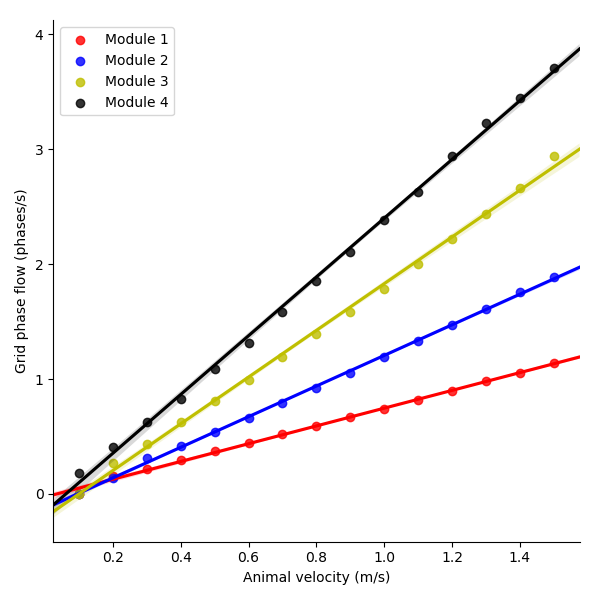

In [2052]:
g = sns.JointGrid(vels, 1/positiveModuleScales[:, 0]*1/inhibGCN2.dt, ratio=100)
for i in range(positiveModuleScales.shape[1]):
    g.y = 1/positiveModuleScales[:, i]*1/inhibGCN2.dt
    
    g.plot_joint(sns.regplot, label="Module {}".format(i + 1), color=colors[i])
    g.annotate(stats.pearsonr)
    g.ax_marg_x.set_axis_off()
    g.ax_marg_y.set_axis_off()

    plt.xlabel("Animal velocity (m/s)")
    plt.ylabel("Grid phase flow (phases/s)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


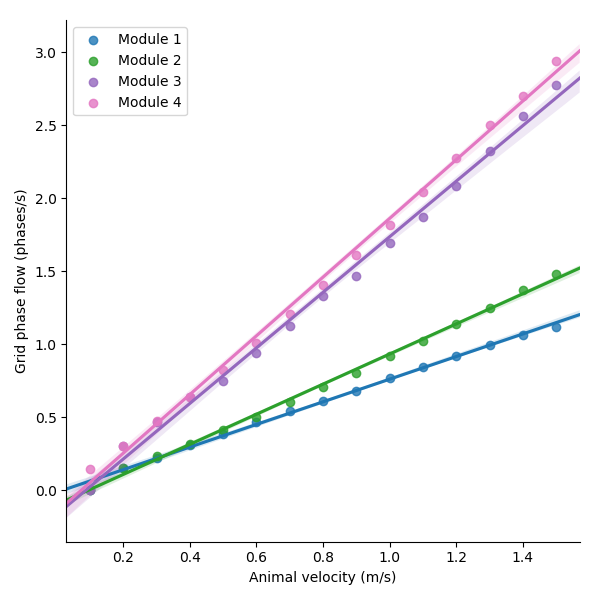

In [1988]:
g = sns.JointGrid(vels[:], 1/positiveModuleScales[:, 0]*1/inhibGCN2.dt, ratio=100)
for i in range(negativeModuleScales.shape[1]):
    g.y = 1/negativeModuleScales[:, i]*1/inhibGCN2.dt
    g.plot_joint(sns.regplot, label="Module {}".format(i + 1), c=colors[i])
    g.annotate(stats.pearsonr)
    g.ax_marg_x.set_axis_off()
    g.ax_marg_y.set_axis_off()
#     plt.figure()
#     fit = np.polyfit(vels, 1/positiveModuleScales[:, i]*1/inhibGCN2.dt, 1)
#     fit_fn = np.poly1d(fit) 
#     # fit_fn is now a function which takes in x and returns an estimate for y

#     plt.plot(vels, 1/positiveModuleScales[:, i]*1/inhibGCN2.dt, 'blue', vels, fit_fn(vels), '--k')

    plt.xlabel("Animal velocity (m/s)")
    plt.ylabel("Grid phase flow (phases/s)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


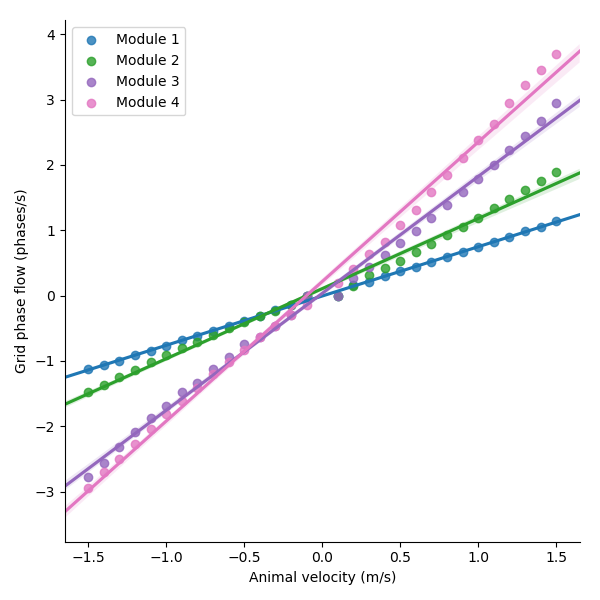

In [1989]:
totalVels = np.concatenate([-vels, vels])
totalModuleScales = np.concatenate([-negativeModuleScales, positiveModuleScales])

g = sns.JointGrid(totalVels[:], 1/totalModuleScales[:, i]*1/inhibGCN2.dt, ratio=100)
for i in range(totalModuleScales.shape[1]):
    g.y = 1/totalModuleScales[:, i]*1/inhibGCN2.dt
    g.plot_joint(sns.regplot, label="Module {}".format(i + 1), c=colors[i])
    g.annotate(stats.pearsonr)
    g.ax_marg_x.set_axis_off()
    g.ax_marg_y.set_axis_off()
#     plt.figure()
#     fit = np.polyfit(vels, 1/positiveModuleScales[:, i]*1/inhibGCN2.dt, 1)
#     fit_fn = np.poly1d(fit) 
#     # fit_fn is now a function which takes in x and returns an estimate for y

#     plt.plot(vels, 1/positiveModuleScales[:, i]*1/inhibGCN2.dt, 'blue', vels, fit_fn(vels), '--k')

    plt.xlabel("Animal velocity (m/s)")
    plt.ylabel("Grid phase flow (phases/s)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


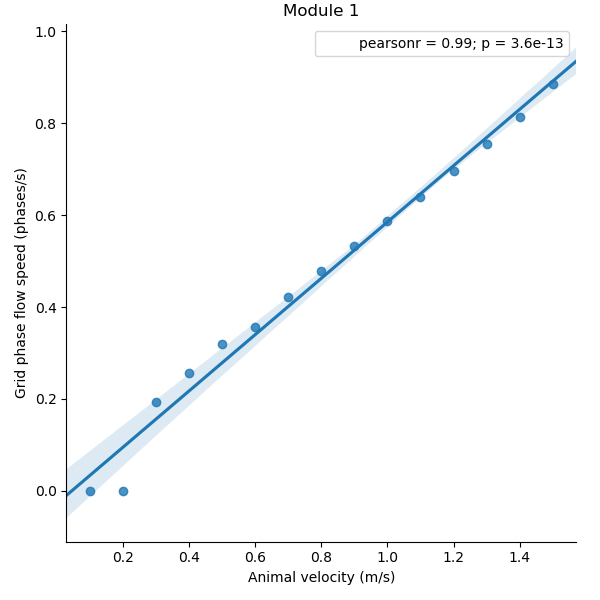

<IPython.core.display.Javascript object>


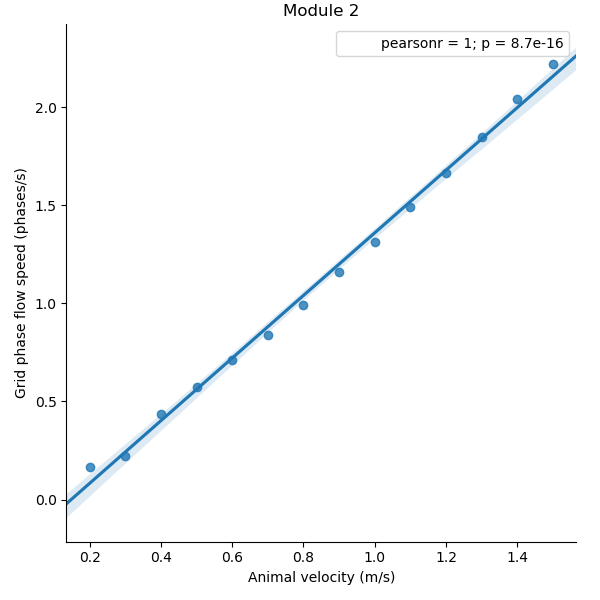

<IPython.core.display.Javascript object>


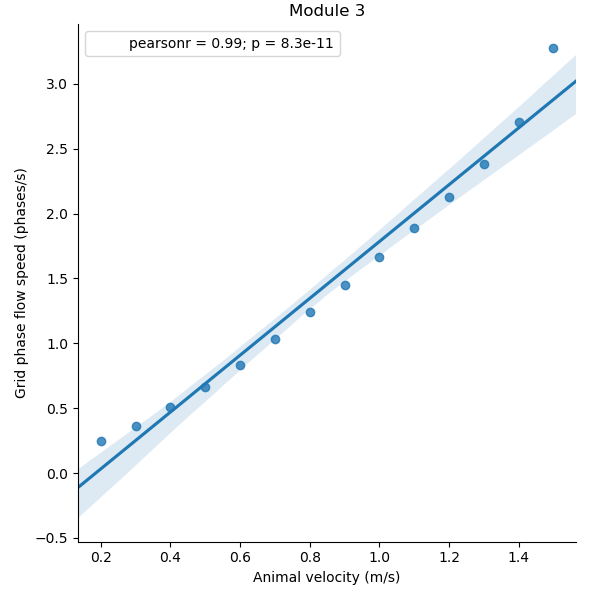

In [1053]:
for i in range(moduleScales.shape[1]):
    g = sns.JointGrid(vels, 1/negativeModuleScales[:, i]*1/inhibGCN2.dt, ratio=100)
    g.plot_joint(sns.regplot)
    g.annotate(stats.pearsonr)
    g.ax_marg_x.set_axis_off()
    g.ax_marg_y.set_axis_off()
    plt.xlabel("Animal velocity (m/s)")
    plt.ylabel("Grid phase flow speed (phases/s)")
    plt.title("Module {}".format(i+ 1))
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


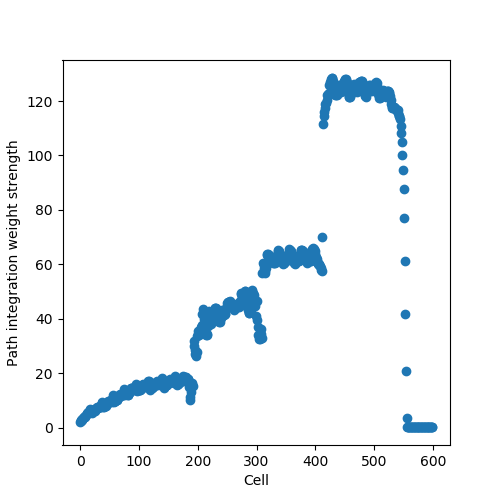

In [1675]:
testEnvelope = torch.sum(inhibGCN2.excitatoryWeights["s"][0] +
                                      inhibGCN2.excitatoryWeights["n"][0],
                                      dim = 0)

plt.figure()
plt.scatter(np.arange(testEnvelope.shape[0]), testEnvelope)
plt.xlabel("Cell")
plt.ylabel("Path integration weight strength")
plt.show()

<IPython.core.display.Javascript object>


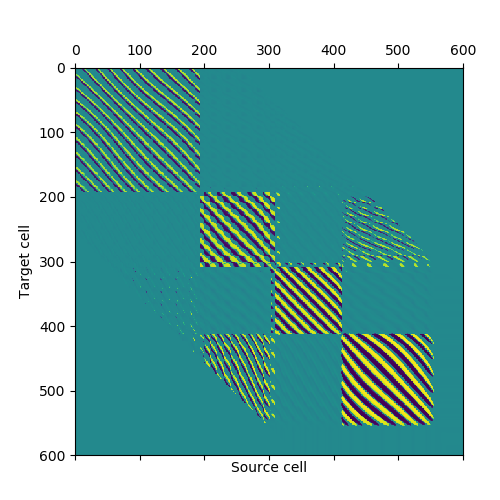

Text(0,0.5,'Target cell')

In [2189]:
weights = np.zeros((inhibGCN2.numX, inhibGCN2.numX))
stride = inhibGCN2.excitatoryWeights["n"].shape[-2]//2
inputWeights = inhibGCN2.excitatoryWeights["n"] - inhibGCN2.excitatoryWeights["s"]
for i in range(inhibGCN2.excitatoryWeights["n"].shape[-1]):
    lowerBound = max(i-stride, 0)
    upperBound = min(i + stride + 1, inhibGCN2.numX)
    weightUpperBound = min(stride - i  + inhibGCN2.numX, 2*stride+1)
    weightLowerBound = max(stride - i, 0)
    weights[lowerBound:upperBound, i] = inputWeights[0, weightLowerBound:weightUpperBound, i]
    
plt.matshow(weights)
plt.xlabel("Source cell")
plt.ylabel("Target cell")

<IPython.core.display.Javascript object>


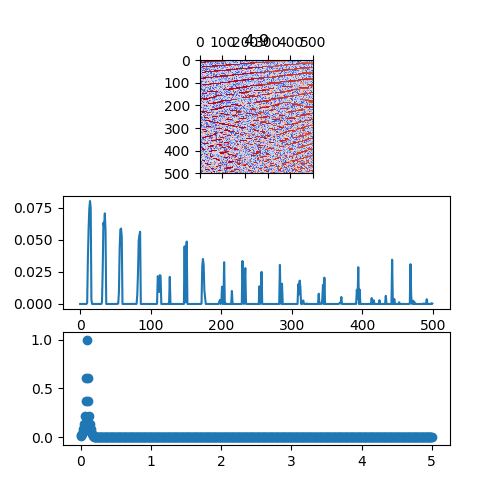

Starting run 0


UnboundLocalError: local variable 'output' referenced before assignment

In [61]:
plt.rcParams['figure.figsize'] = [5, 5]
inhibGCN.learn(1, plotting=True, plotInterval=10, speed=1., preSimulateTime=50.)

In [ ]:
alphas = np.asarray([20,
                    10,
                    15,
                    5,
                    20,
                    20,
                    10,
                    15,
                    40,
                    40,
                    10,
                    5,
                    5,
                    40,
                    15,
                    0.5,
                    5.,
                    2.,
                    1.,
                    1.,
                    ])

boostEffects = np.asarray([100,
                          200,
                          200,
                          200,
                          200,
                          400,
                          100,
                          100,
                          100,
                          400,
                          400,
                          100,
                          400,
                          200,
                          400,
                          50,
                          50.,
                          50.,
                          50.,
                          400.,
                          ])

scales = np.asarray([43.75,
                    37.3,
                    30,
                    60,
                    21.6,
                    14.5,
                    74,
                    55,
                    33.5,
                    9,
                    23,
                    106.5,
                    34.5,
                    15,
                    17.5,
                    700,
                    150.,
                    282.,
                    400.,
                    103.,
                    ])


fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_trisurf(1./(alphas)**.7,
                       1./(boostEffects)**.7,
                       scales,
                       linewidth=0,
                       #cmap=cm.coolwarm,
                       antialiased=True)


ax.set_xlabel("Moving average constant")
ax.set_ylabel("Boost effect")
ax.set_zlabel("Scale")
plt.title("Scale vs. boosting")

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


ax.view_init(15, 210)
plt.savefig("ScaleSurface.png", dpi = 250)
plt.draw()
plt.show()